In [3]:
import model_mobster as model_mobster_mv
import numpy as np
import pandas as pd
import pyro.distributions as dist
import torch

import matplotlib.pyplot as plt

from utils.plot_functions import *
from utils.BoundedPareto import BoundedPareto
from utils.create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2

/Users/elenarivaroli/miniconda3/envs/mobster/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def beta_lk(mb,idx,  d, a_beta, b_beta):
    """
    Compute beta-binomial likelihood for a single dimension of a single cluster.
    """
    betabin = dist.BetaBinomial(a_beta, b_beta, total_count=mb.DP[idx,d]).log_prob(mb.NV[idx,d])
    return betabin # simply does log(weights) + log(density)

def expon_lk(mb, idx,  d):
    """
    Compute exponential likelihood for a single dimension of a single cluster.
    """
    exp = dist.Exponential(mb.rate_expon).log_prob(mb.NV[idx,d])
    return exp # simply does log(weights) + log(density)

def pareto_binomial_pmf(mb, NV, DP, alpha):
    integration_points=2000
    # Generate integration points across all rows at once
    t = torch.linspace(mb.pareto_L, mb.pareto_H, integration_points).unsqueeze(0)  # Shape (1, integration_points)
    NV_expanded = NV.unsqueeze(-1)  # Shape (NV.shape[0], NV.shape[1], 1)
    DP_expanded = DP.unsqueeze(-1)  # Shape (NV.shape[0], DP.shape[1], 1)
    binom_vals = dist.Binomial(total_count=DP_expanded, probs=t).log_prob(NV_expanded).exp()
    pareto_vals = BoundedPareto(mb.pareto_L, alpha, mb.pareto_H).log_prob(t).exp()  # Shape (1, integration_points)
    integrand = binom_vals * pareto_vals

    pmf_x = torch.trapz(integrand, t, dim=-1).log()  # Shape (NV.shape[0], NV.shape[1])

    return pmf_x.tolist()  # Convert the result to a list

def pareto_lk(mb, idx, d, alpha):
    paretobin = torch.tensor(pareto_binomial_pmf(mb, NV=mb.NV[idx, d], DP=mb.DP[idx, d], alpha=alpha))
    return paretobin # tensor of len N (if D = 1, only N)

### 2 beta-pareto components

In [4]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 1.5
L_pareto = 0.01
H_pareto = 0.5
phi_beta = 0.2
k_beta = 100
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Sample S2
phi_beta_x = 0.5
k_beta_x = 150
phi_beta_y = 0.5
k_beta_y= 150
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

torch.Size([1500, 2])
torch.Size([1500, 2])


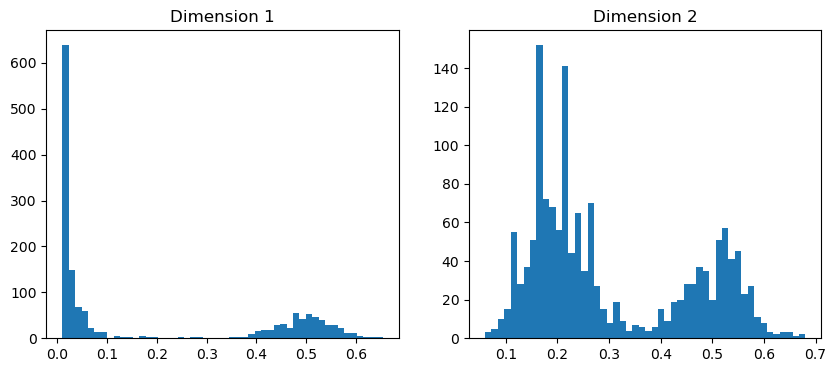

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [6]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))

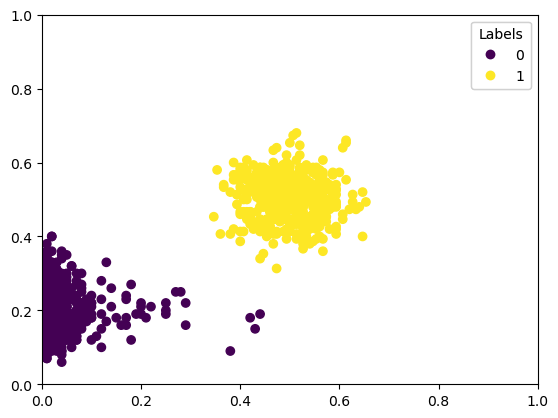

In [7]:
fig, ax = plt.subplots()

scatter = ax.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Labels")
ax.add_artist(legend1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])

plt.show()

No GPU available.
RUN WITH K = 2 AND SEED = 40
Minimum detected VAF: tensor(0.0300)


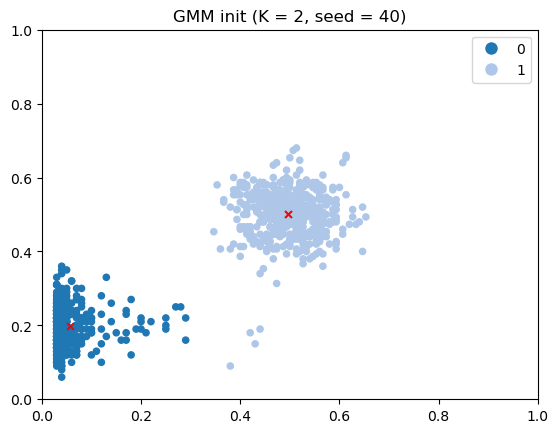

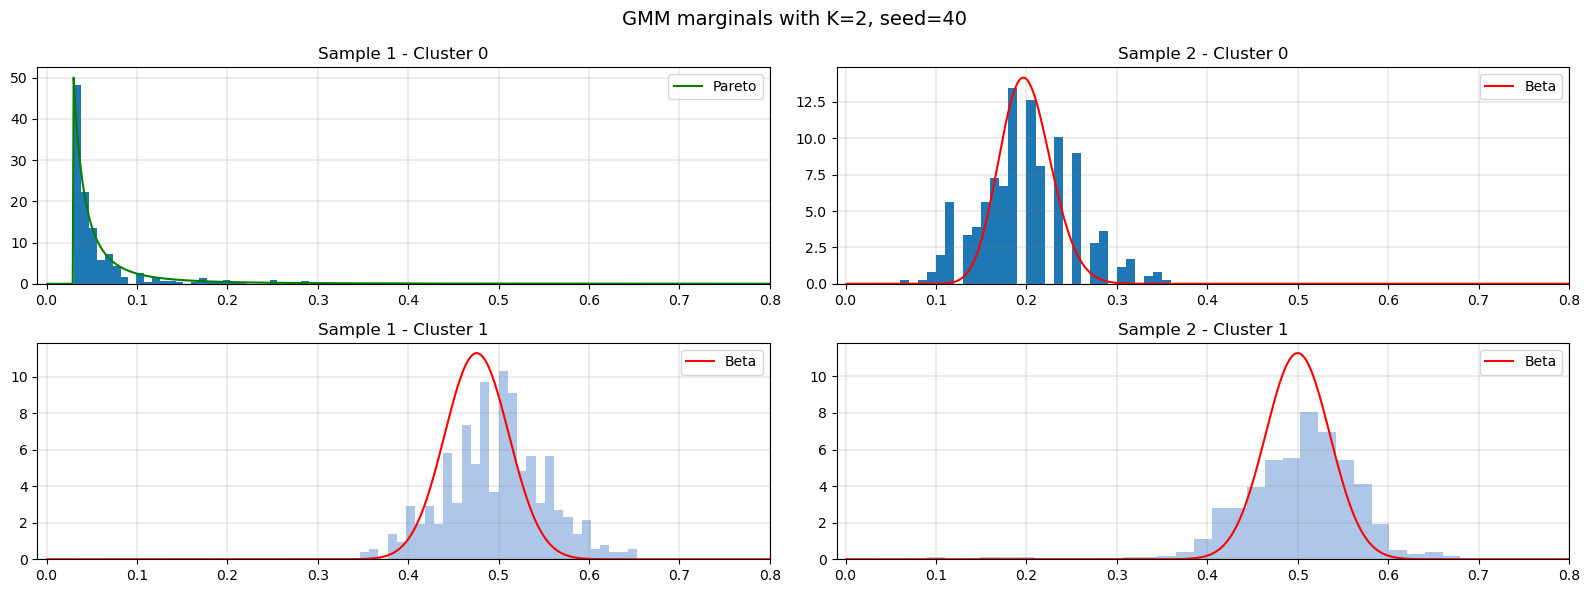

Iteration 0: Loss = 5927132.074033776
Iteration 50: Loss = 5477288.101618246
Iteration 100: Loss = 5360770.6779089635
Iteration 150: Loss = 5319583.722174897
Iteration 200: Loss = 5303036.912128488
Iteration 250: Loss = 5294674.495267324
Iteration 300: Loss = 5289440.042436588
Iteration 350: Loss = 5285098.020931035


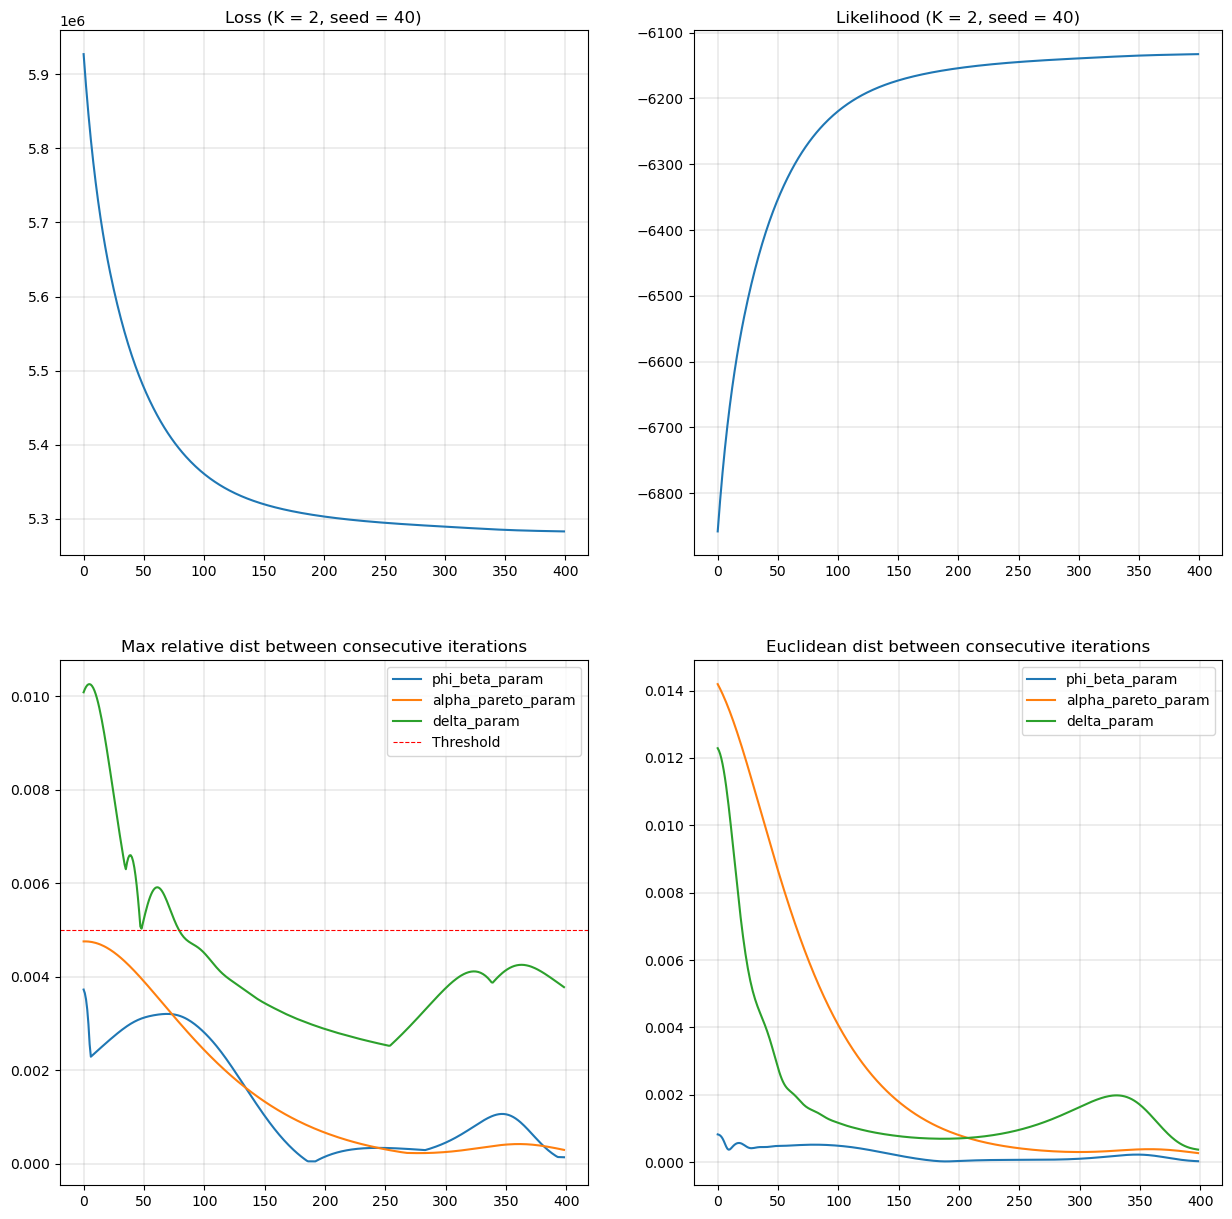

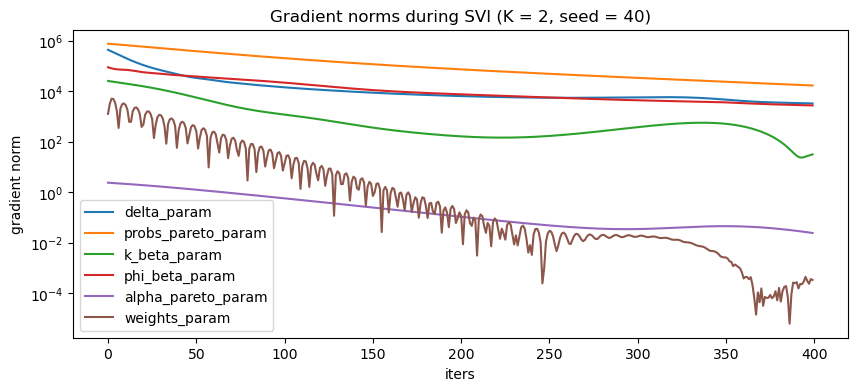

Inference lk:  -6132.546798690182
Final lk (integr):  tensor(-6237.0962, grad_fn=<SumBackward0>)
n_params:  30
n:  tensor(861)
lk:  tensor(-6237.0962, grad_fn=<SumBackward0>)
bic: 12676.935546875 



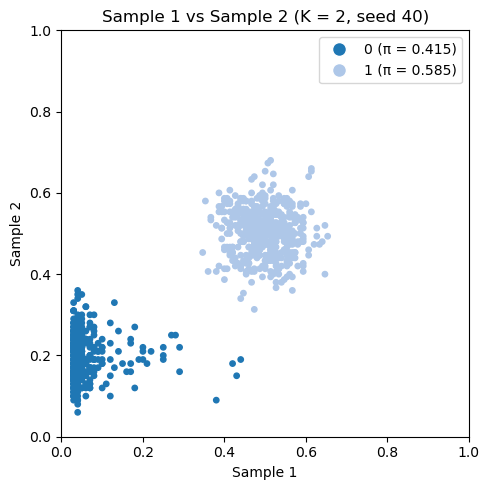

Time taken for K = 2 and seed = 40: 14.974 seconds
RUN WITH K = 2 AND SEED = 41
Minimum detected VAF: tensor(0.0300)


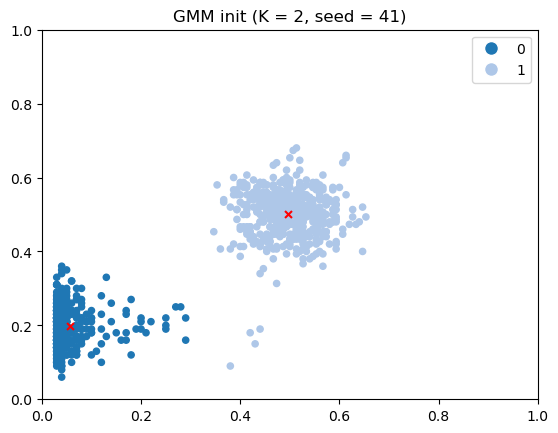

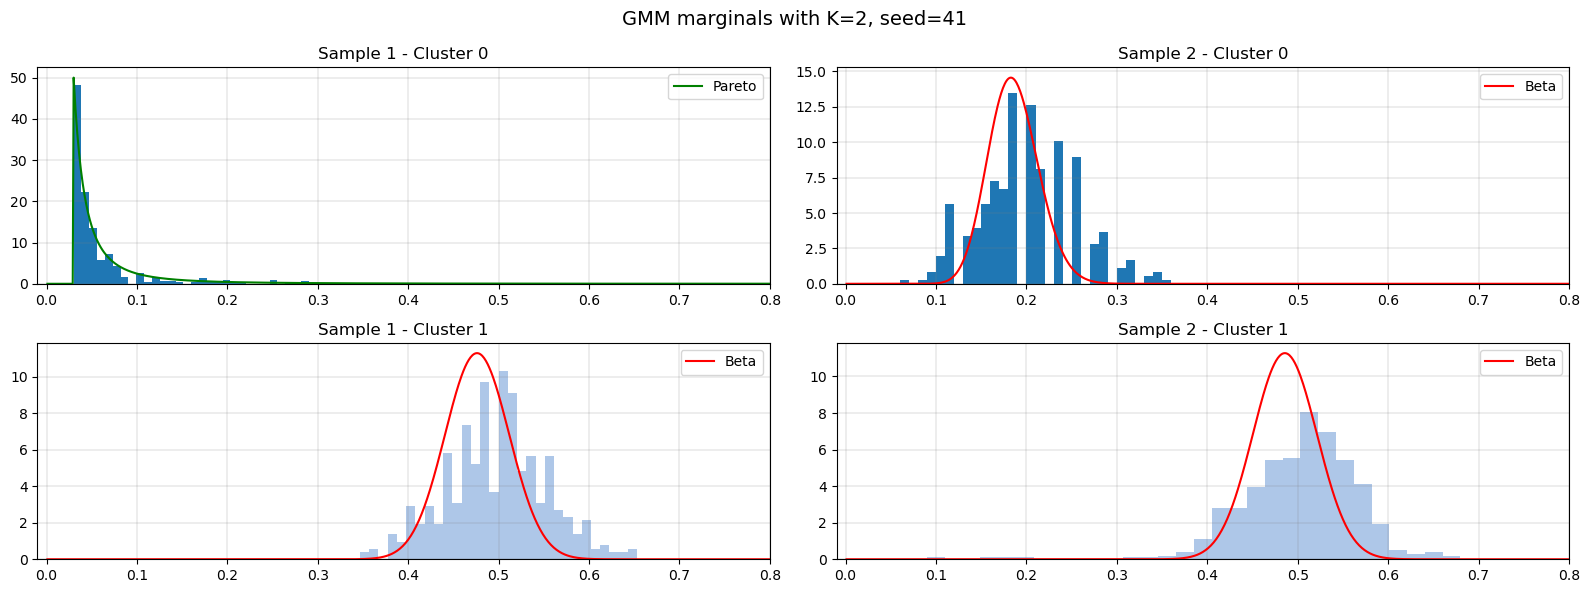

Iteration 0: Loss = 5977869.993978862
Iteration 50: Loss = 5522725.196063138
Iteration 100: Loss = 5410048.9101907695
Iteration 150: Loss = 5367038.229122173
Iteration 200: Loss = 5346853.712174798
Iteration 250: Loss = 5335568.859161459
Iteration 300: Loss = 5326777.773691394
Iteration 350: Loss = 5312522.225458453
Iteration 400: Loss = 5288595.091316933
Iteration 450: Loss = 5283308.807458974
Iteration 500: Loss = 5282530.533328803
Iteration 550: Loss = 5281991.046778084
Iteration 600: Loss = 5281560.904018916


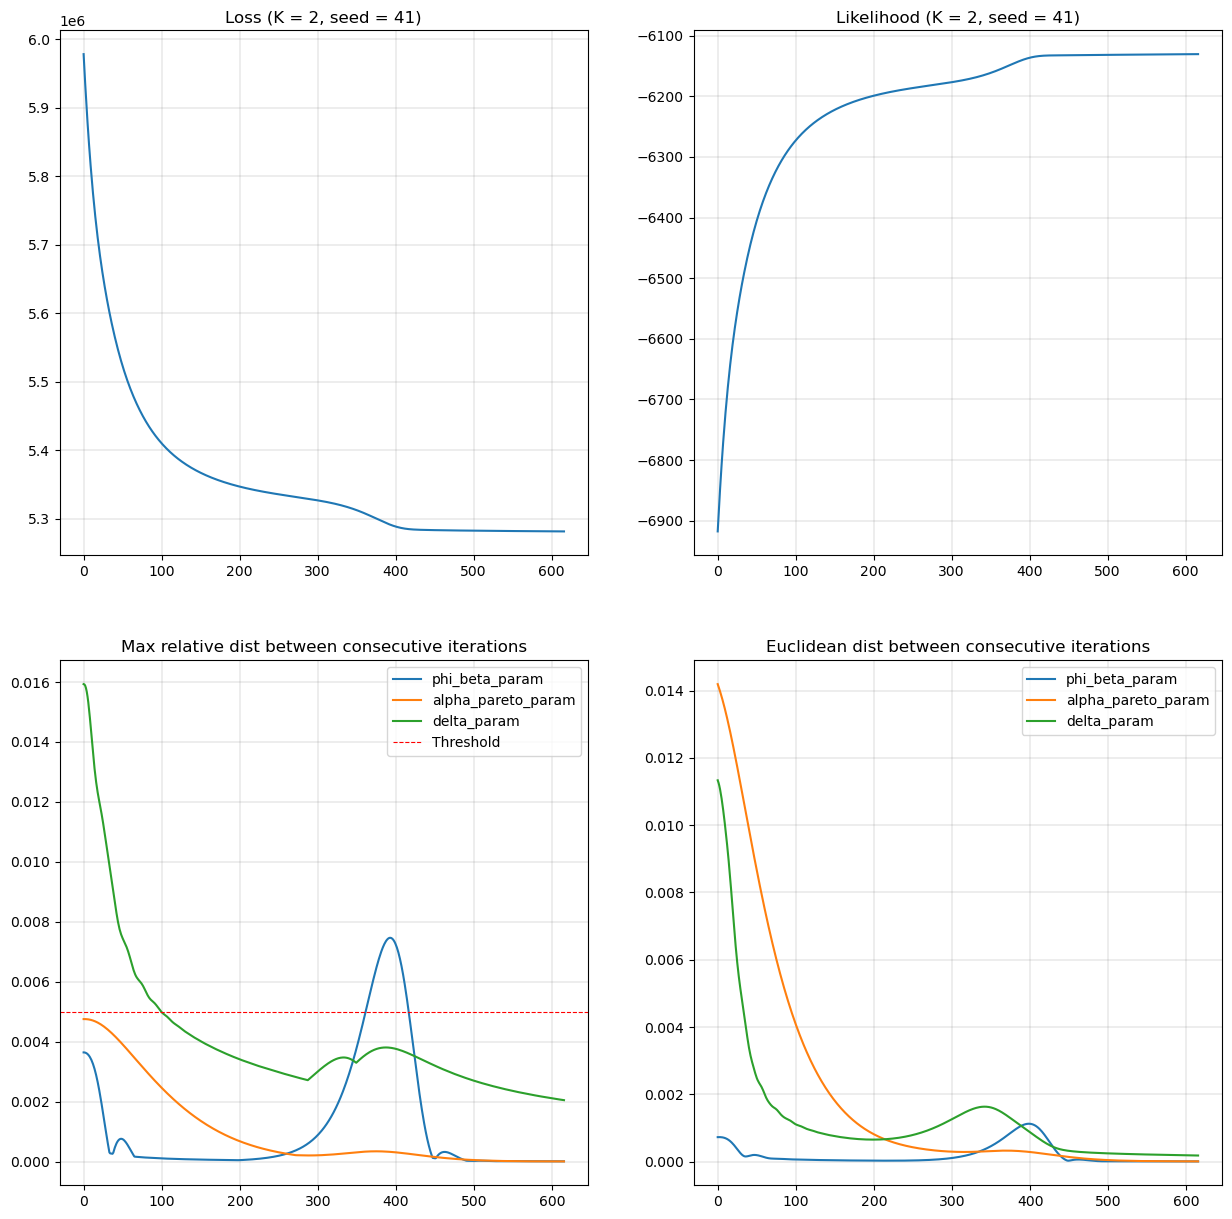

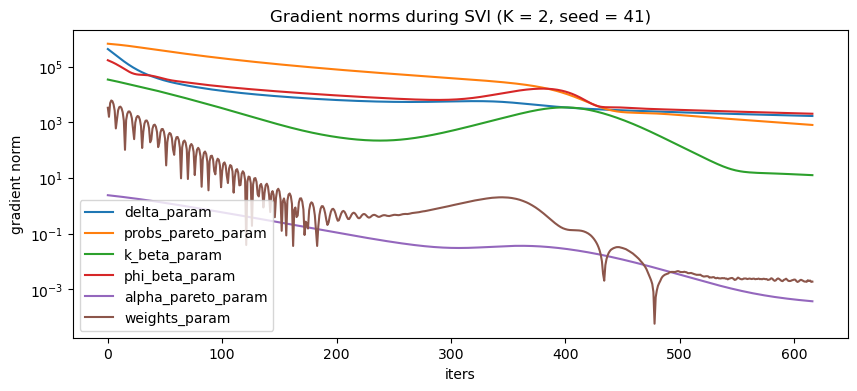

Inference lk:  -6130.634385857559
Final lk (integr):  tensor(-6237.3076, grad_fn=<SumBackward0>)
n_params:  30
n:  tensor(861)
lk:  tensor(-6237.3076, grad_fn=<SumBackward0>)
bic: 12677.3583984375 



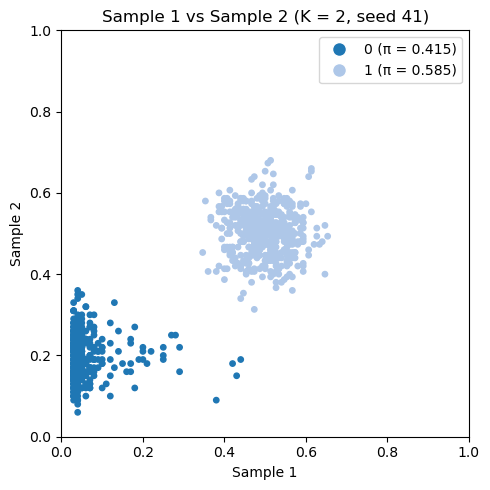

Time taken for K = 2 and seed = 41: 4.208 seconds


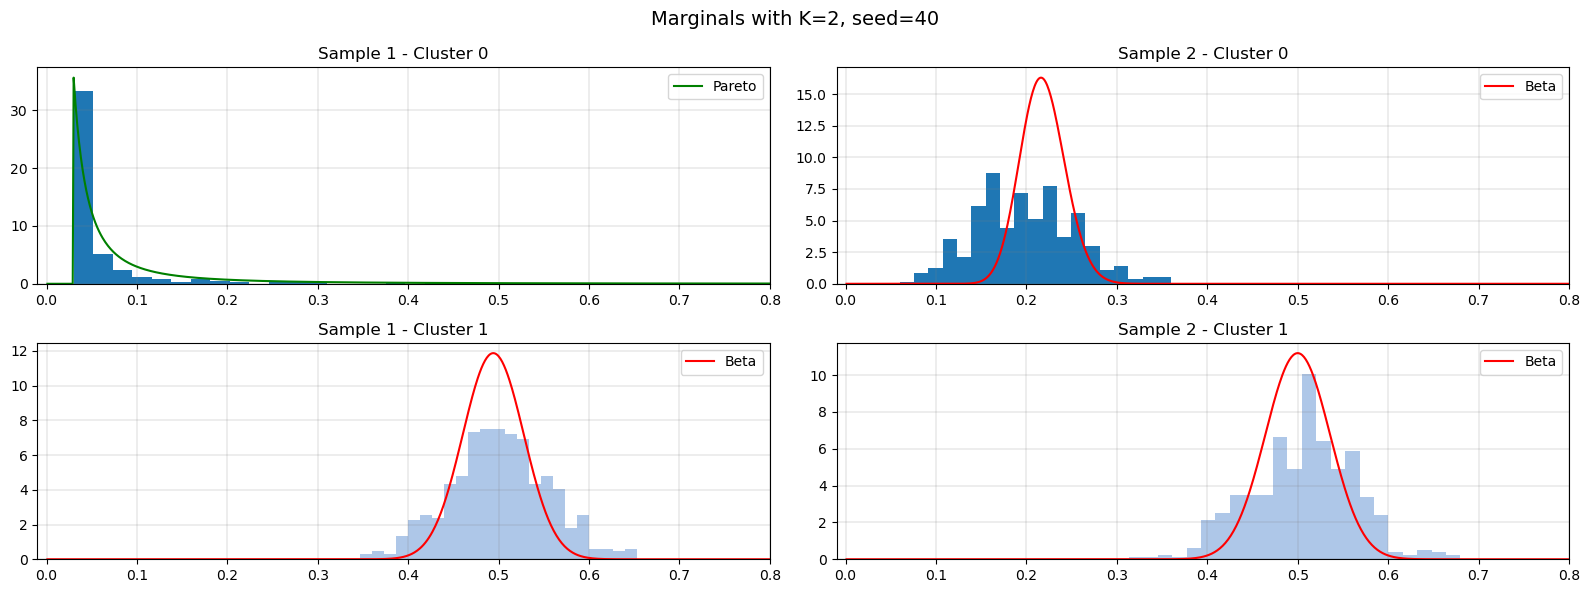

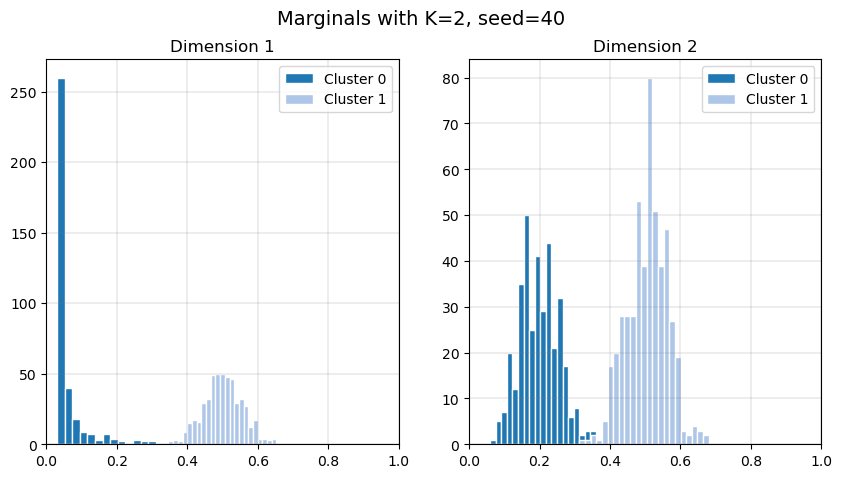

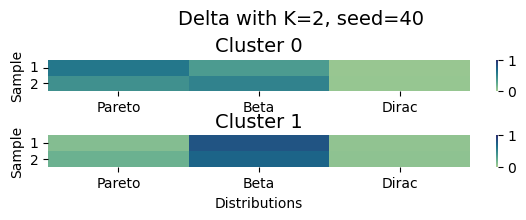

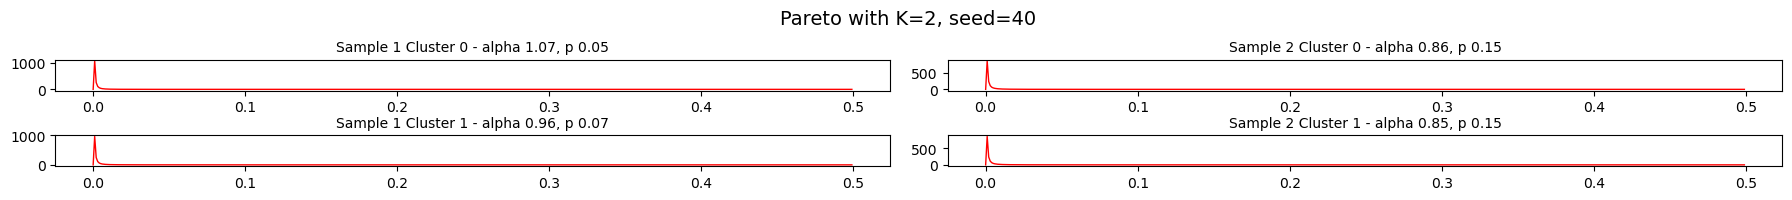

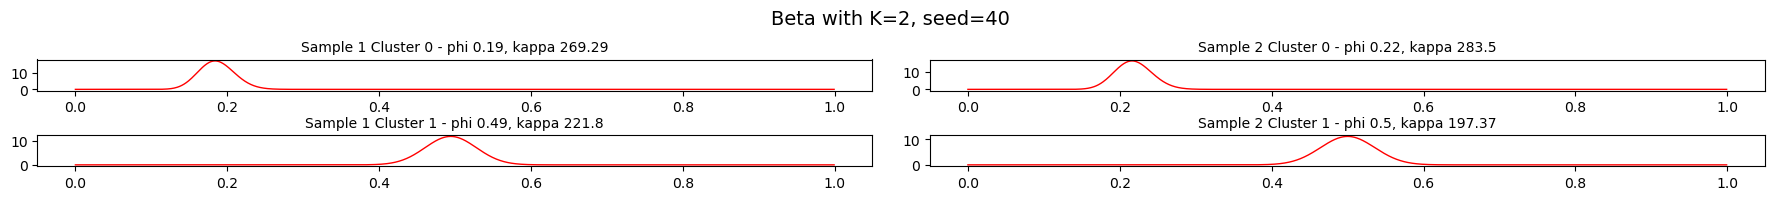

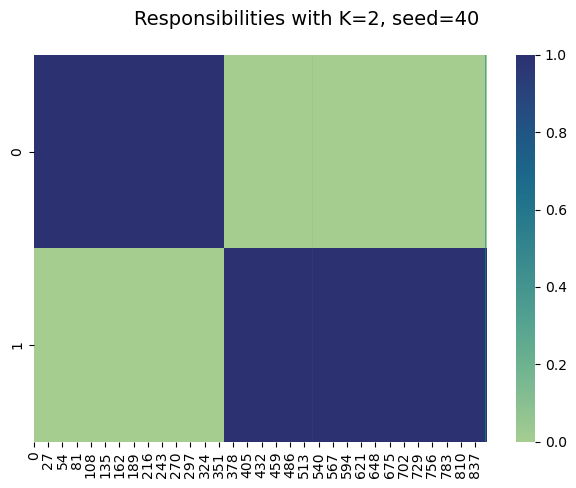

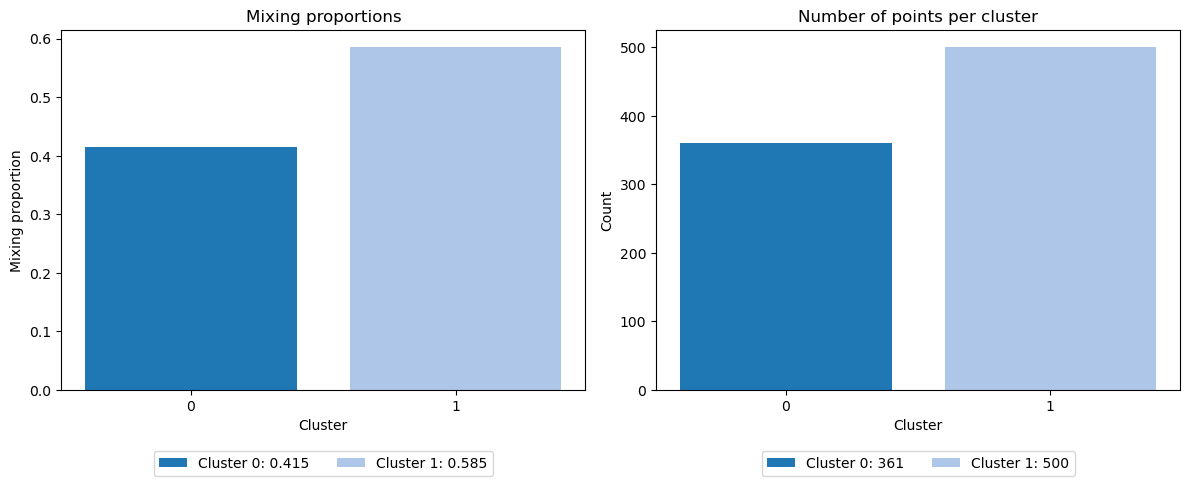

RUN WITH K = 3 AND SEED = 40
Minimum detected VAF: tensor(0.0300)


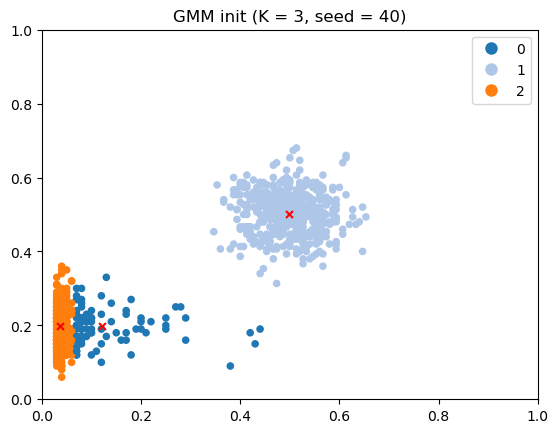

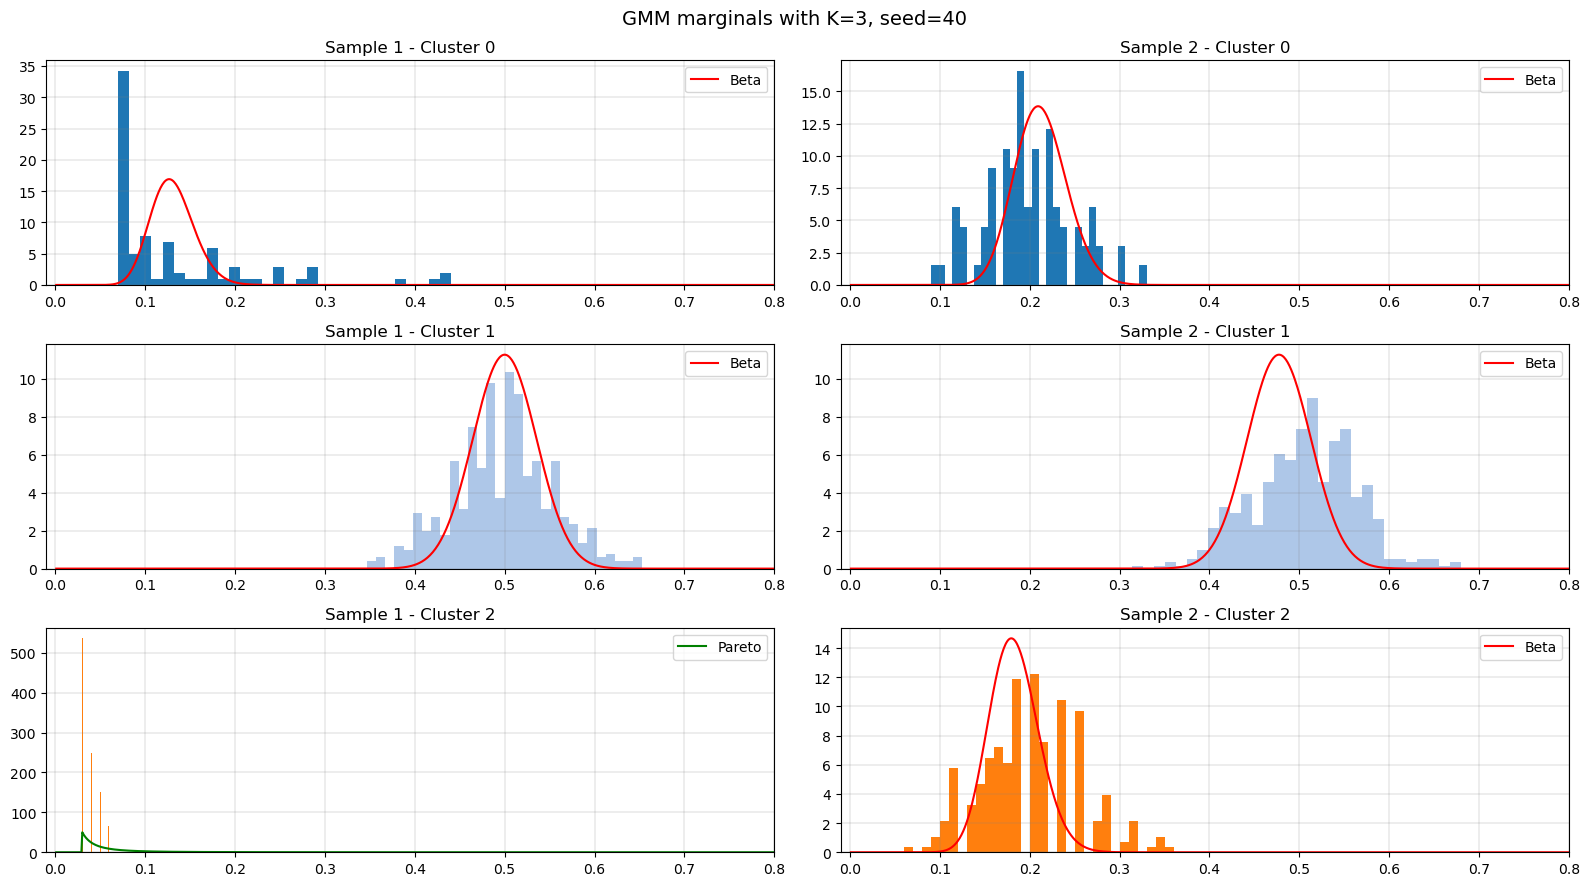

Iteration 0: Loss = 5999797.049953652
Iteration 50: Loss = 5492107.668812134
Iteration 100: Loss = 5366838.977635877
Iteration 150: Loss = 5317615.79379971
Iteration 200: Loss = 5298290.452224914
Iteration 250: Loss = 5292002.354631488
Iteration 300: Loss = 5288988.431342249
Iteration 350: Loss = 5287195.08857503


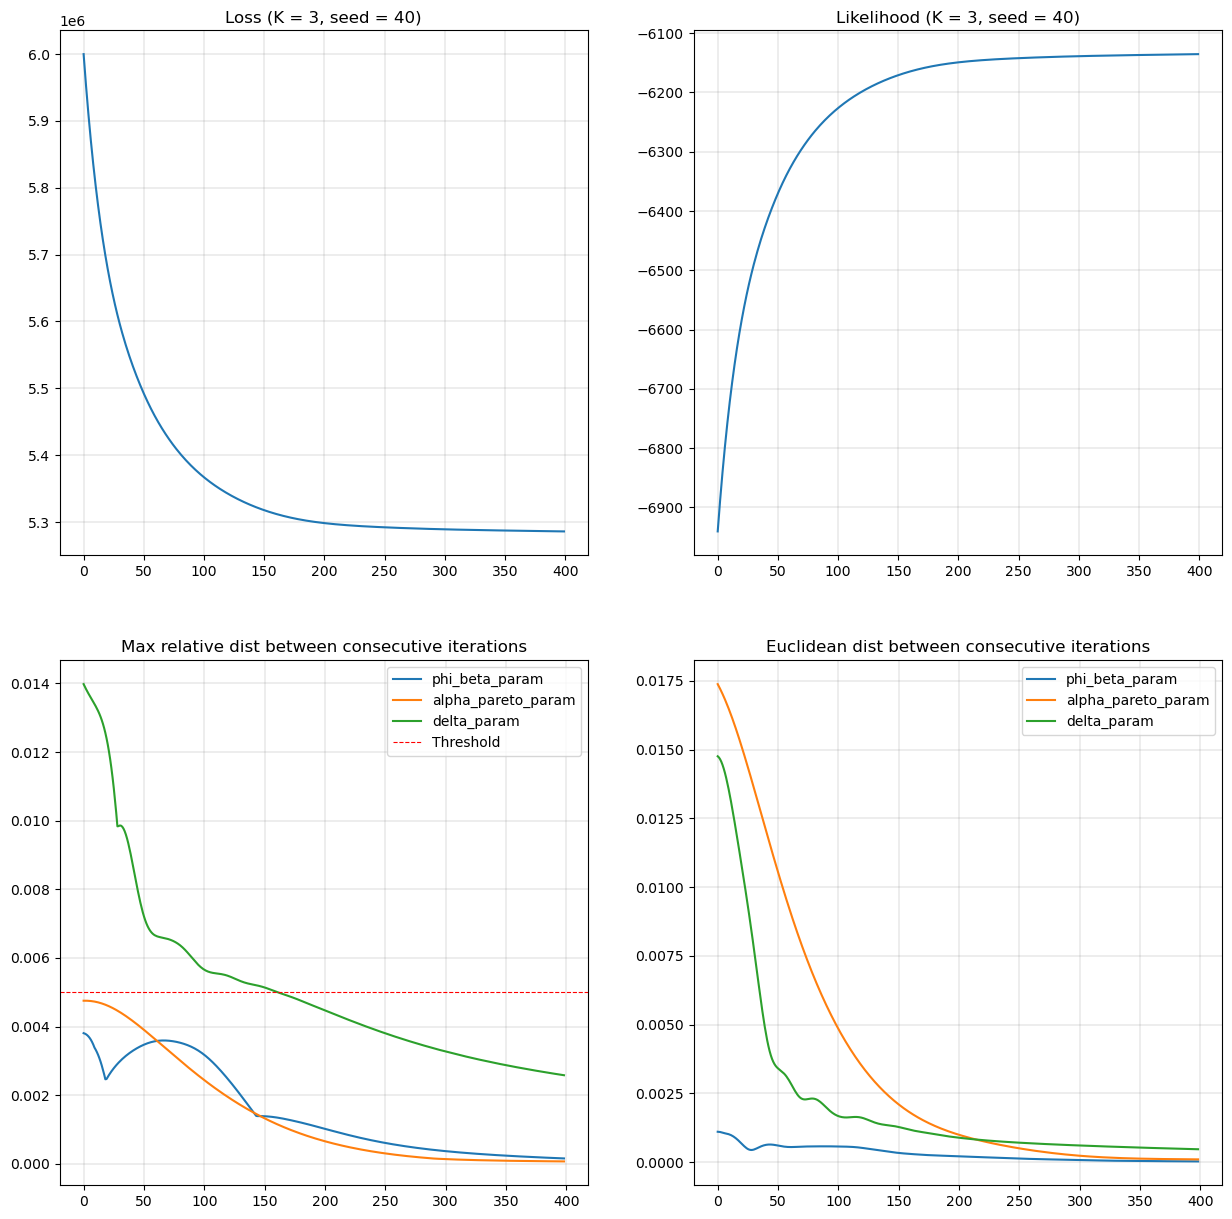

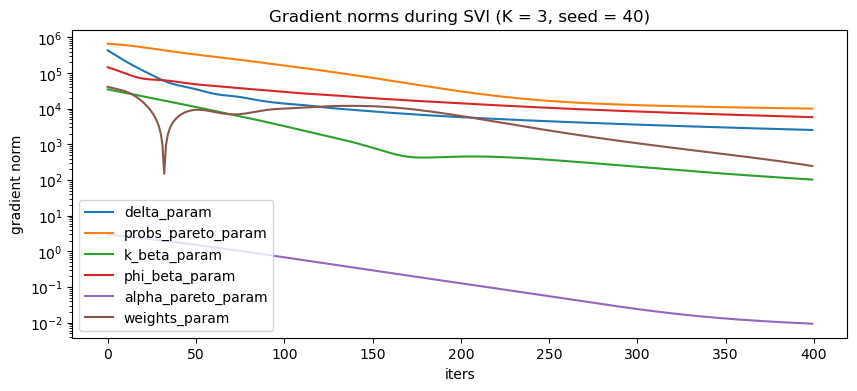

Inference lk:  -6135.4098284883985
Final lk (integr):  tensor(-6196.6831, grad_fn=<SumBackward0>)
n_params:  45
n:  tensor(861)
lk:  tensor(-6196.6831, grad_fn=<SumBackward0>)
bic: 12697.48046875 



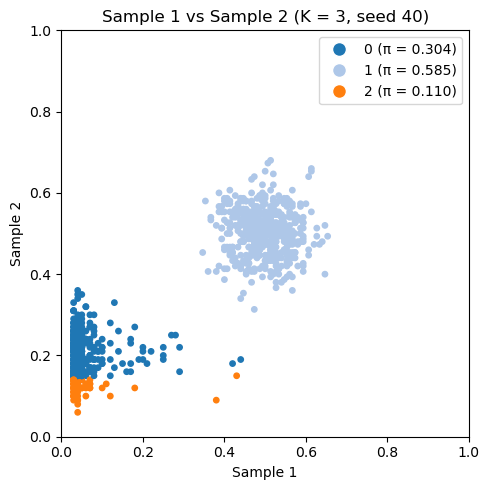

Time taken for K = 3 and seed = 40: 3.648 seconds
RUN WITH K = 3 AND SEED = 41
Minimum detected VAF: tensor(0.0300)


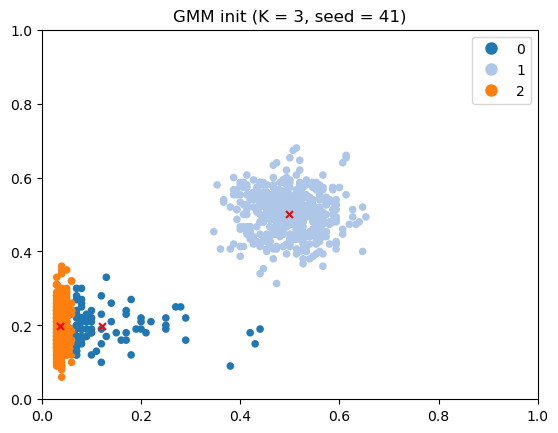

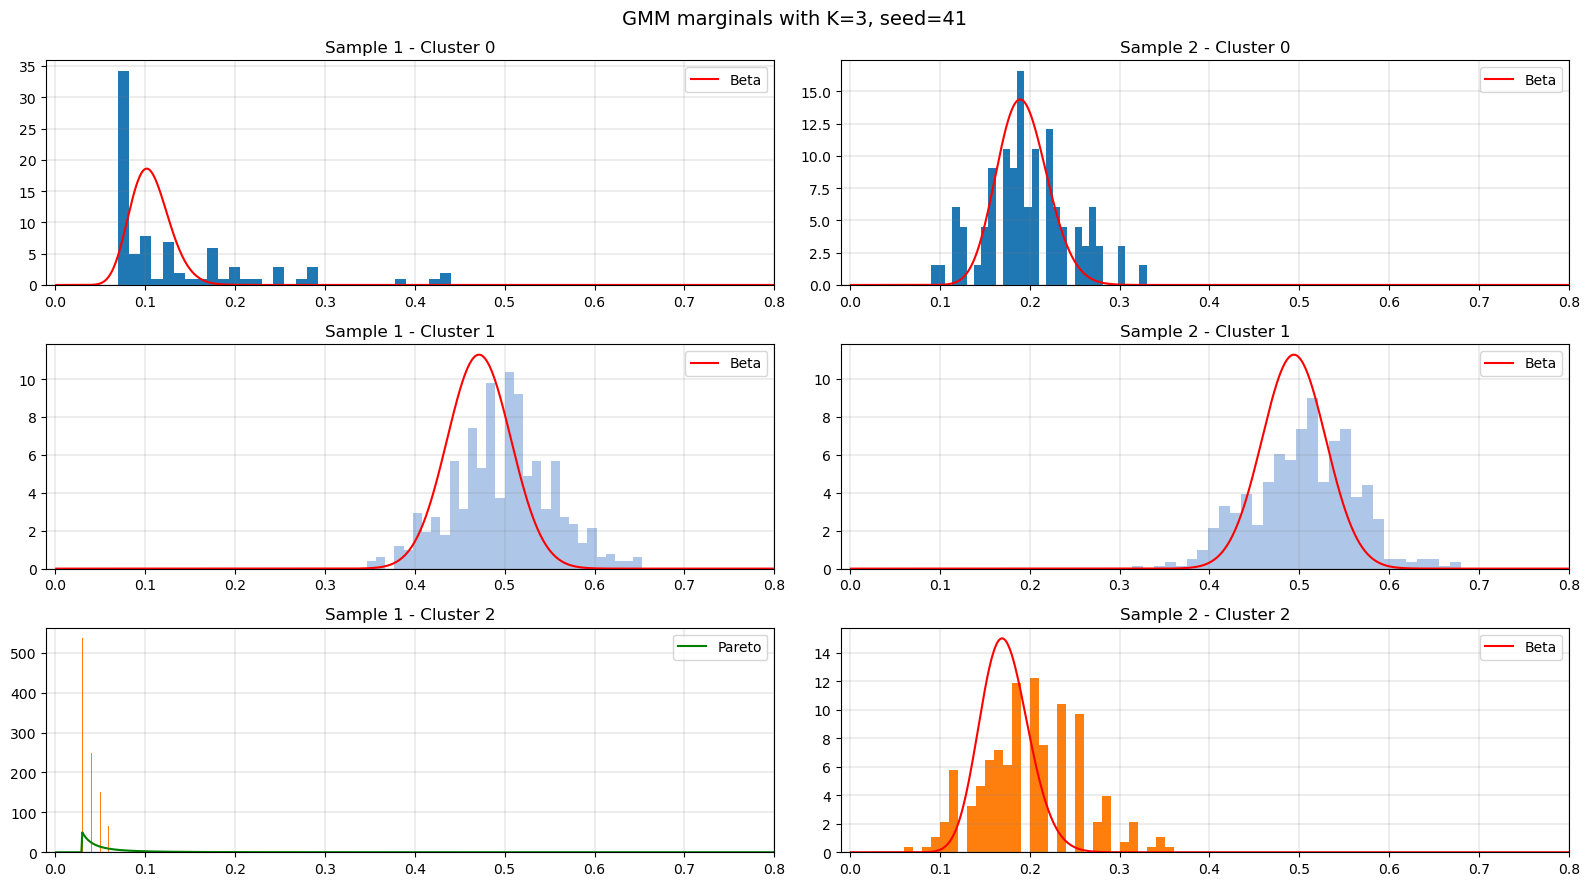

Iteration 0: Loss = 6011050.490330183
Iteration 50: Loss = 5485311.473572015
Iteration 100: Loss = 5354797.042953713
Iteration 150: Loss = 5310083.438894062
Iteration 200: Loss = 5292672.09372401
Iteration 250: Loss = 5283901.781826414
Iteration 300: Loss = 5280666.432829847
Iteration 350: Loss = 5278984.303257458
Iteration 400: Loss = 5277901.045264876
Iteration 450: Loss = 5277115.333007623
Iteration 500: Loss = 5276515.76242196


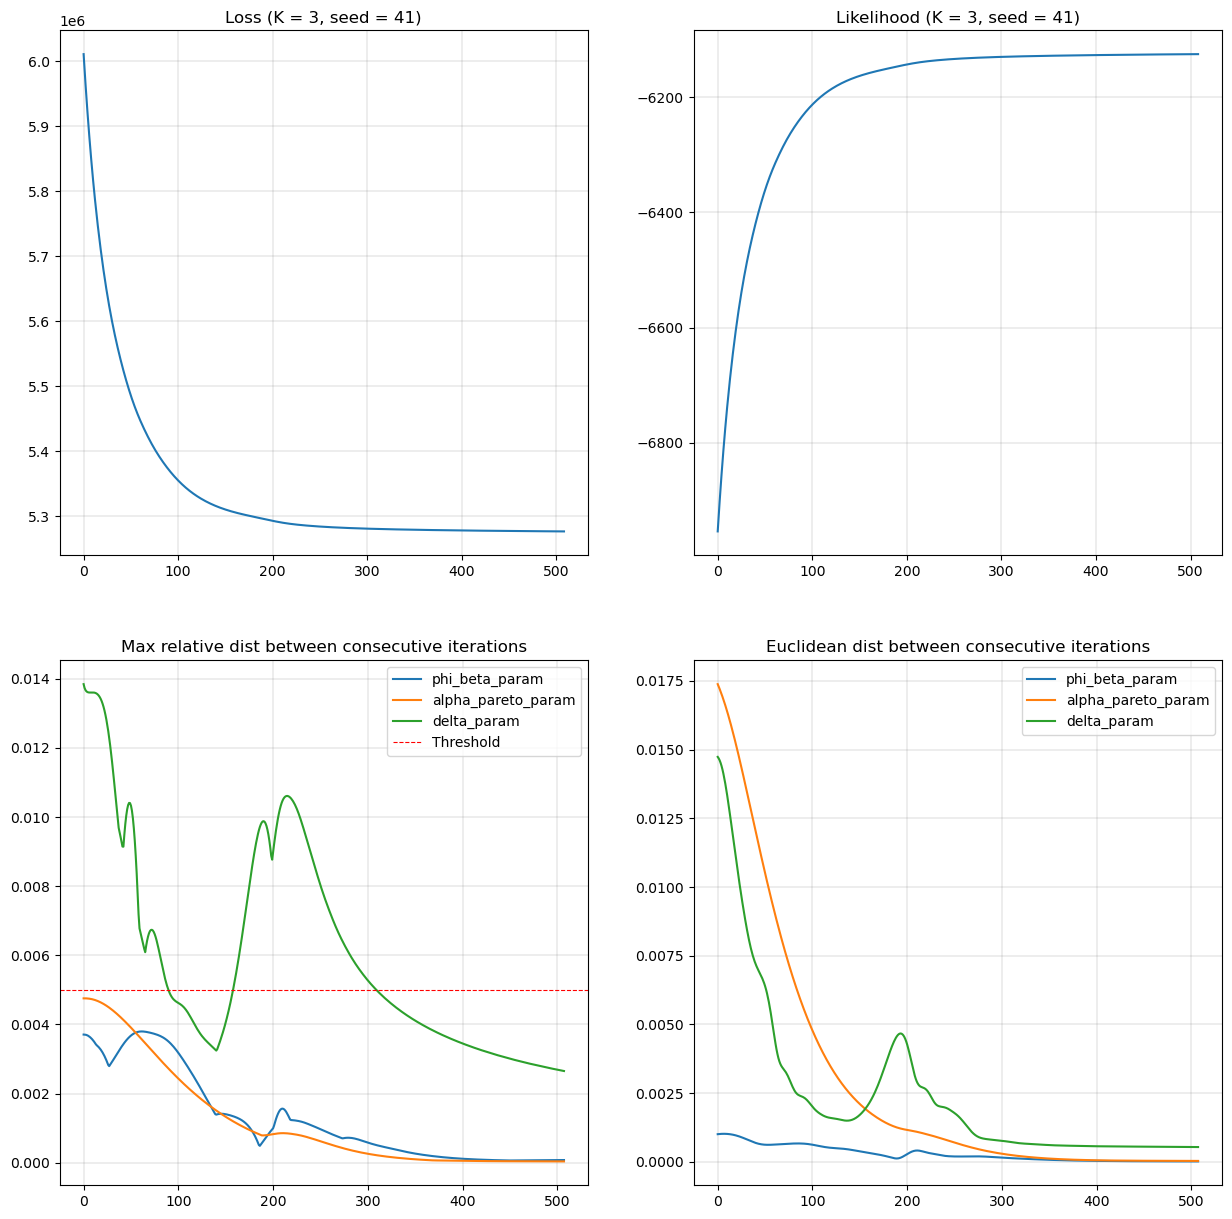

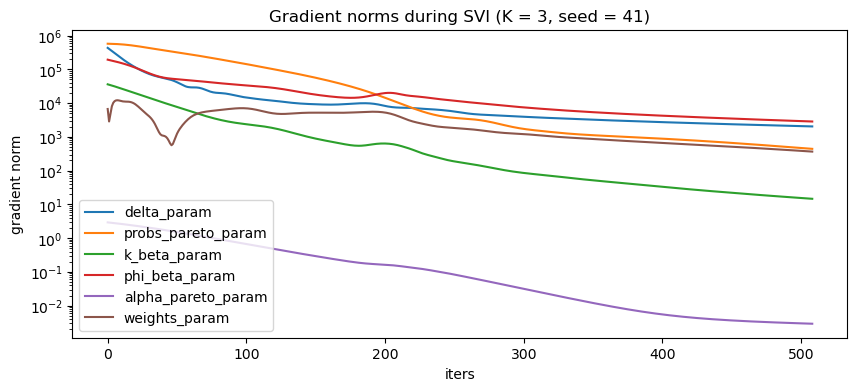

Inference lk:  -6124.927633940034
Final lk (integr):  tensor(-6265.4268, grad_fn=<SumBackward0>)
n_params:  45
n:  tensor(861)
lk:  tensor(-6265.4268, grad_fn=<SumBackward0>)
bic: 12834.9677734375 



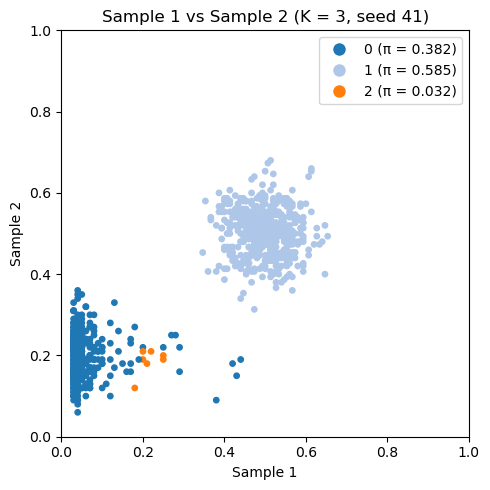

Time taken for K = 3 and seed = 41: 4.159 seconds


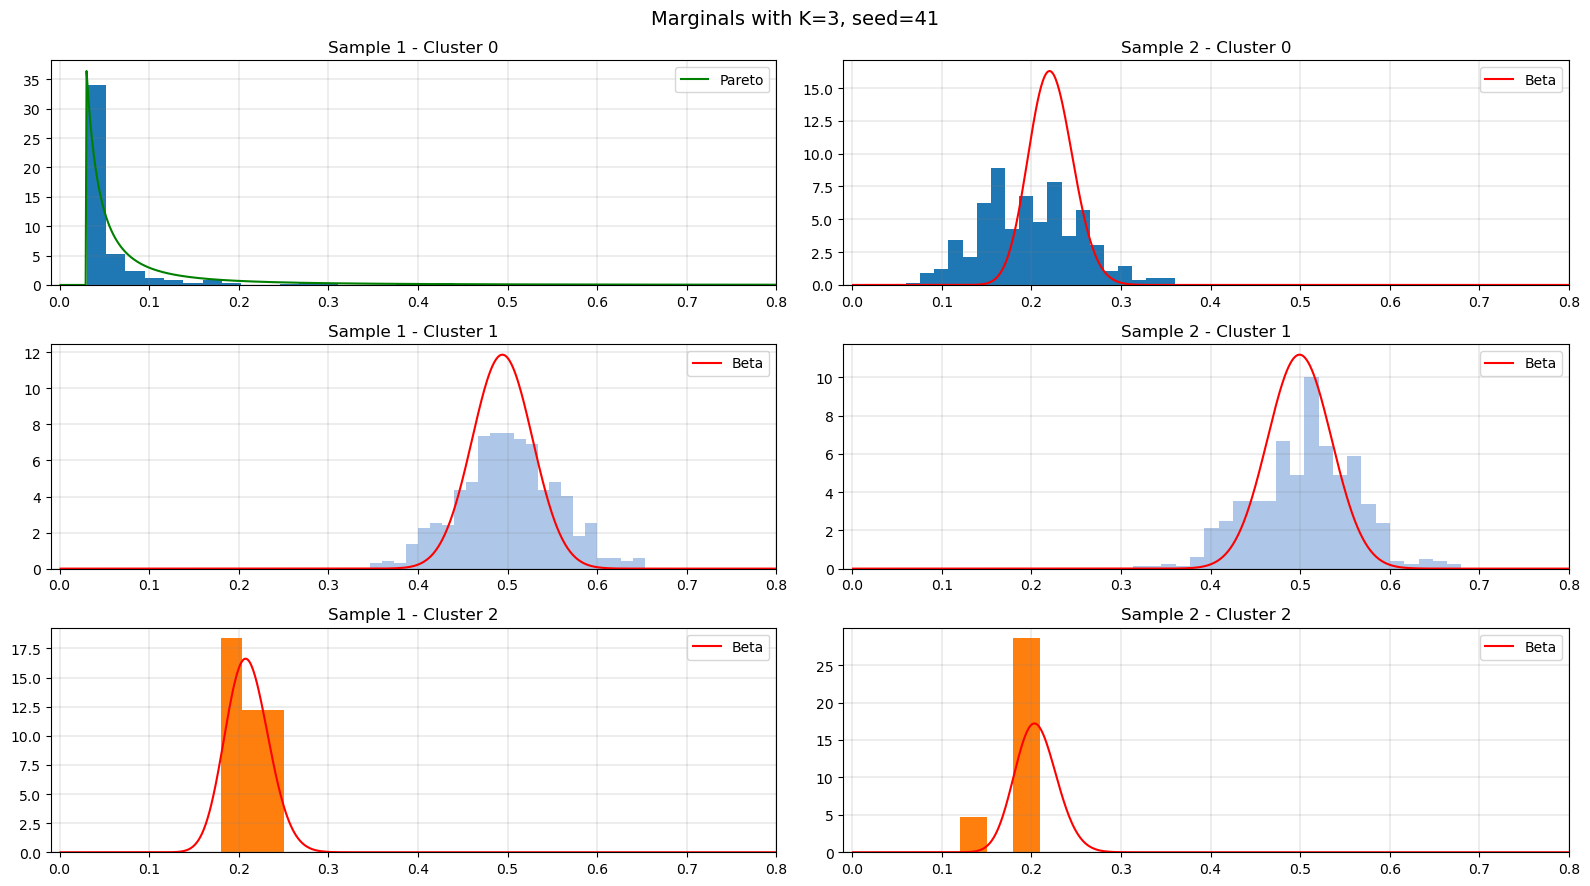

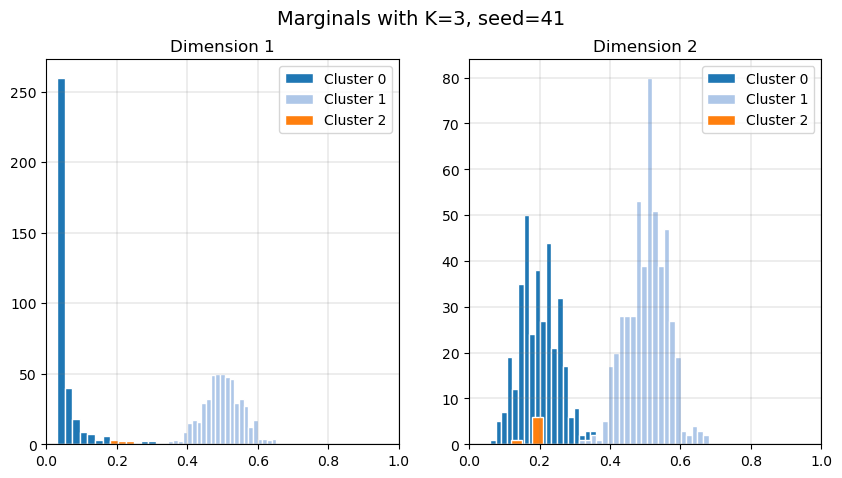

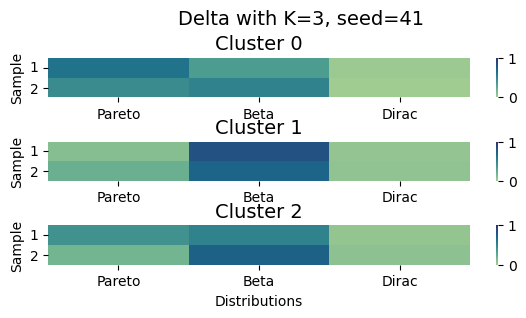

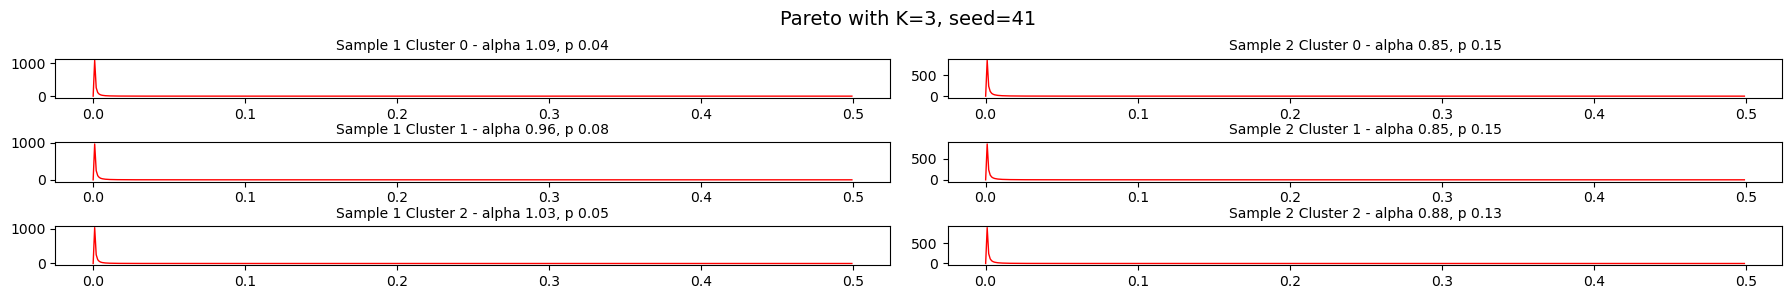

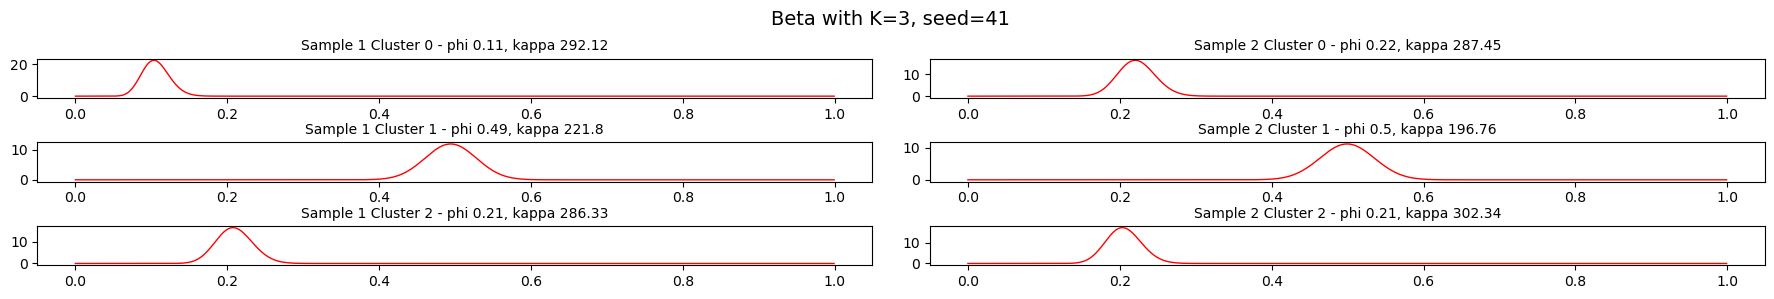

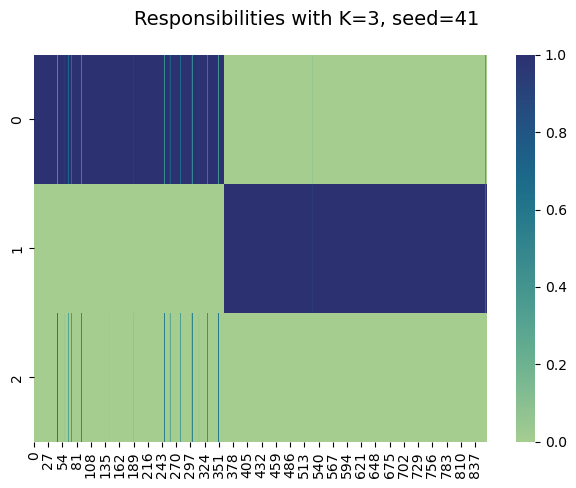

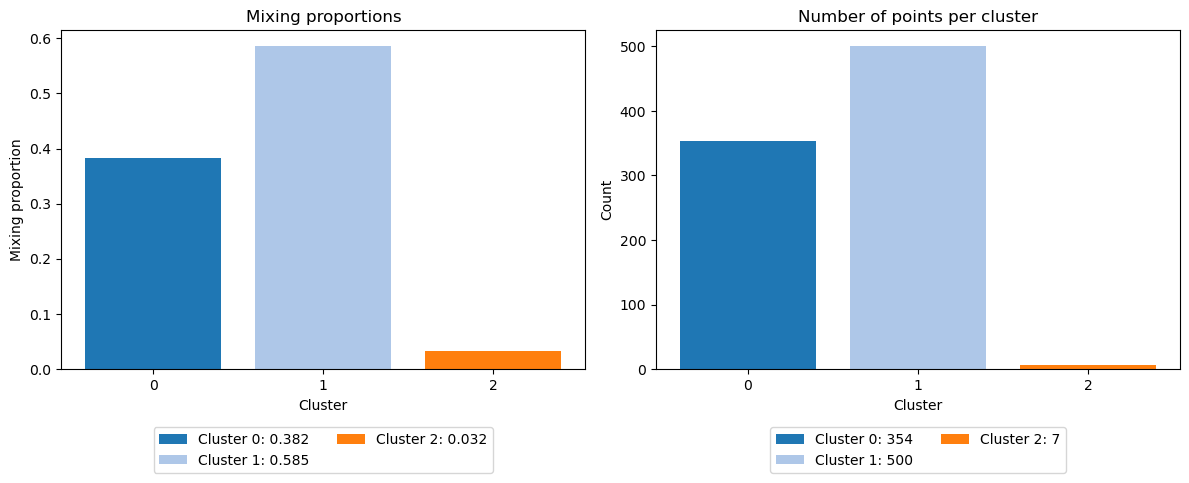

Selected number of clusters is 2 with seed 40


In [8]:
K_list = [2,3]
seed_list = [40,41]
mb_list, best_K, best_seed = model_mobster_mv.fit(NV, DP, num_iter = 2000, K = K_list, seed = seed_list, lr = 0.01)

In [9]:
for i in range(len(mb_list)):
    print("K = ", mb_list[i].K)
    bic = mb_list[i].final_dict['bic']
    print("\t BIC: ", bic.item())
    print("\t Loss: ", mb_list[i].final_dict['final_loss'])
    print("\t Likelihood: ", mb_list[i].final_dict['final_likelihood'].item())

K =  2
	 BIC:  19915.1328125
	 Loss:  14701635.329233885
	 Likelihood:  -9803.98828125
K =  3
	 BIC:  19948.232421875
	 Loss:  14611973.55798769
	 Likelihood:  -9743.75


### 3 components (1 private)

In [9]:
N1 = 1000
N2 = 1000
N3 = 1000
seed = 123
# Sample S1
alpha_pareto = 1.5
L_pareto = 0.01
H_pareto = 0.5
phi_beta = 0.2
k_beta = 100
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Sample S2
phi_beta_x = 0.5
k_beta_x = 150
phi_beta_y = 0.5
k_beta_y= 150
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

phi_beta_x = 1e-15
k_beta_x = 150
phi_beta_y = 0.2
k_beta_y= 150
n3=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV2[:,0] = torch.tensor(0, dtype=NV2.dtype)
NV = torch.concat((NV,NV2))
DP = torch.concat((DP,DP2))

torch.Size([2000, 2])
torch.Size([2000, 2])


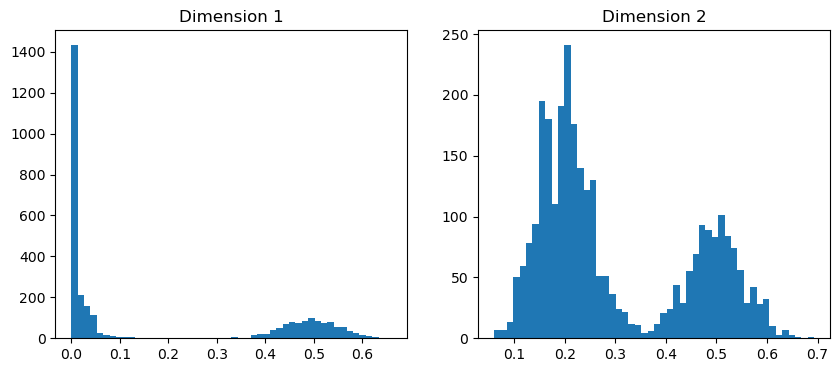

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [10]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

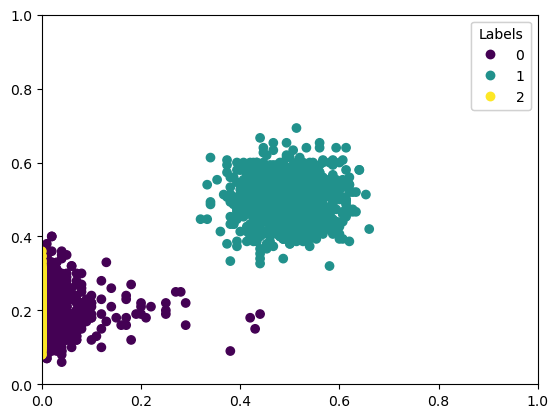

In [11]:
fig, ax = plt.subplots()

scatter = ax.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Labels")
ax.add_artist(legend1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])

plt.show()

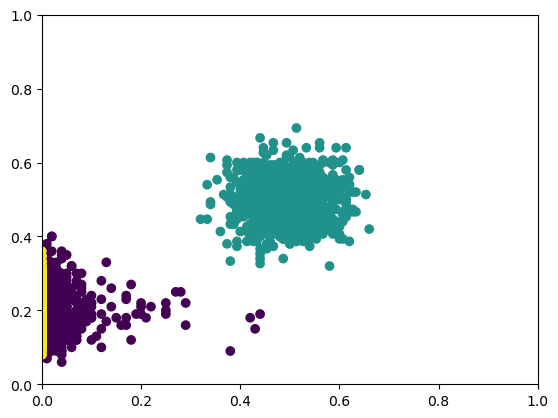

In [12]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

No GPU available.
RUN WITH K = 3 AND SEED = 40
Minimum detected VAF: tensor(0.0300)


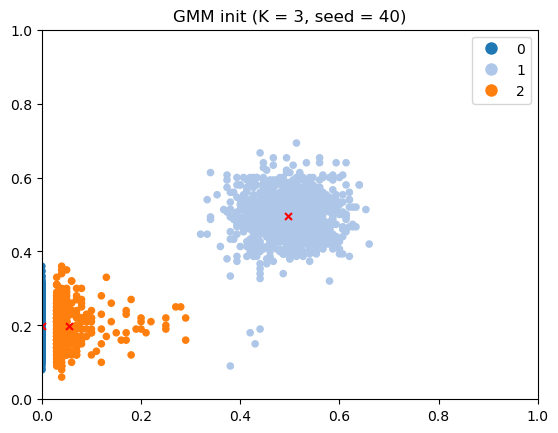

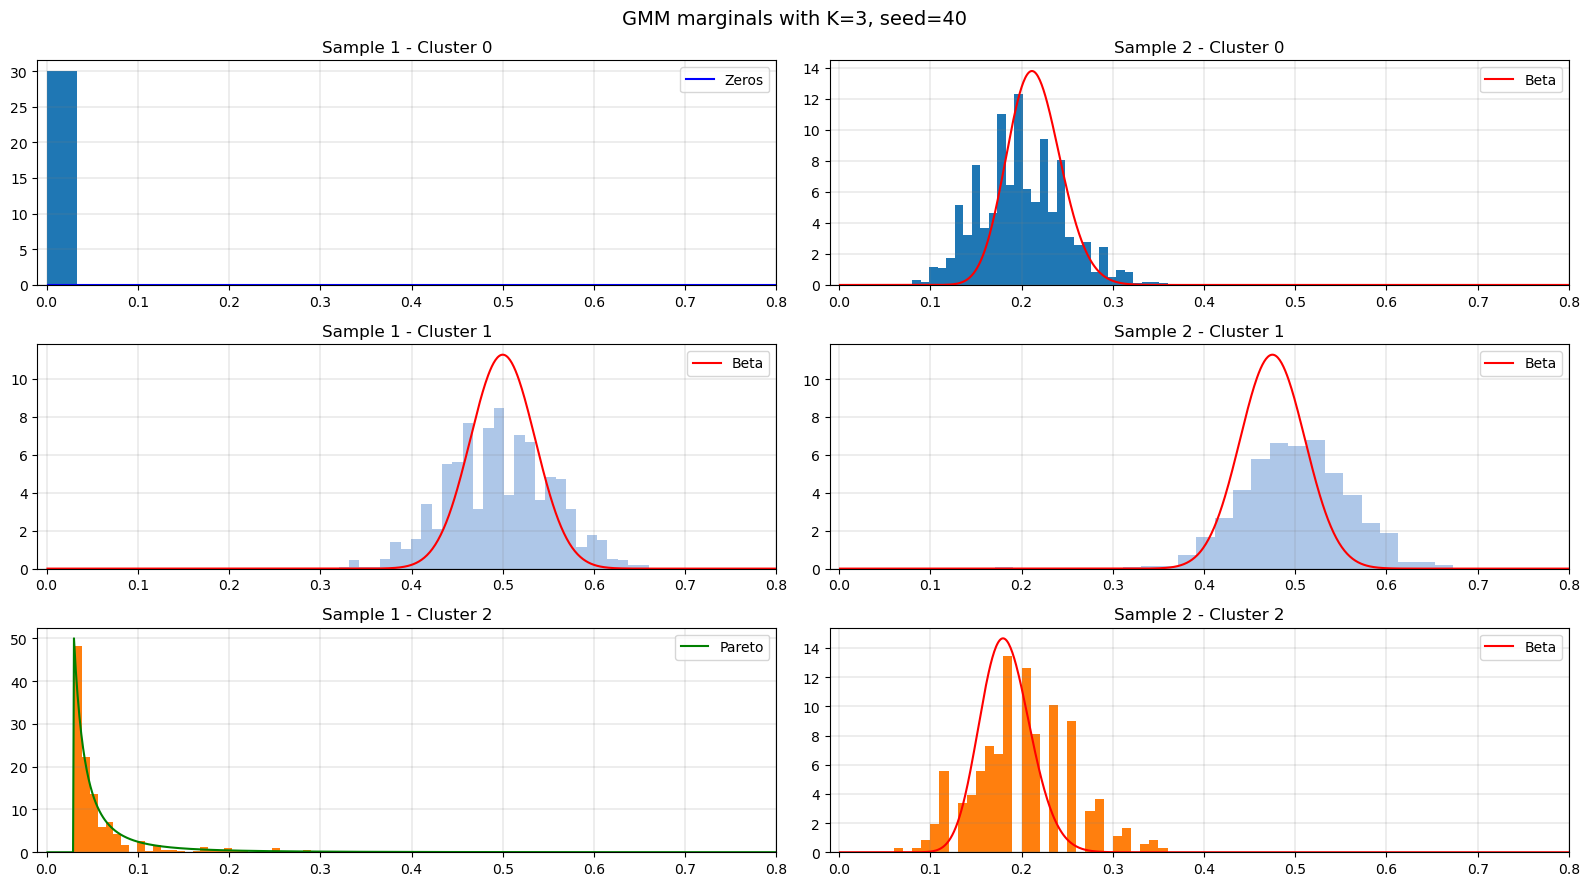

Iteration 0: Loss = 37868365.06187254
Iteration 50: Loss = 35829063.6855011
Iteration 100: Loss = 35422507.61656743
Iteration 150: Loss = 35247719.32732112
Iteration 200: Loss = 35183472.635578394
Iteration 250: Loss = 35158178.87709689
Iteration 300: Loss = 35142512.03575419
Iteration 350: Loss = 35133830.97526994


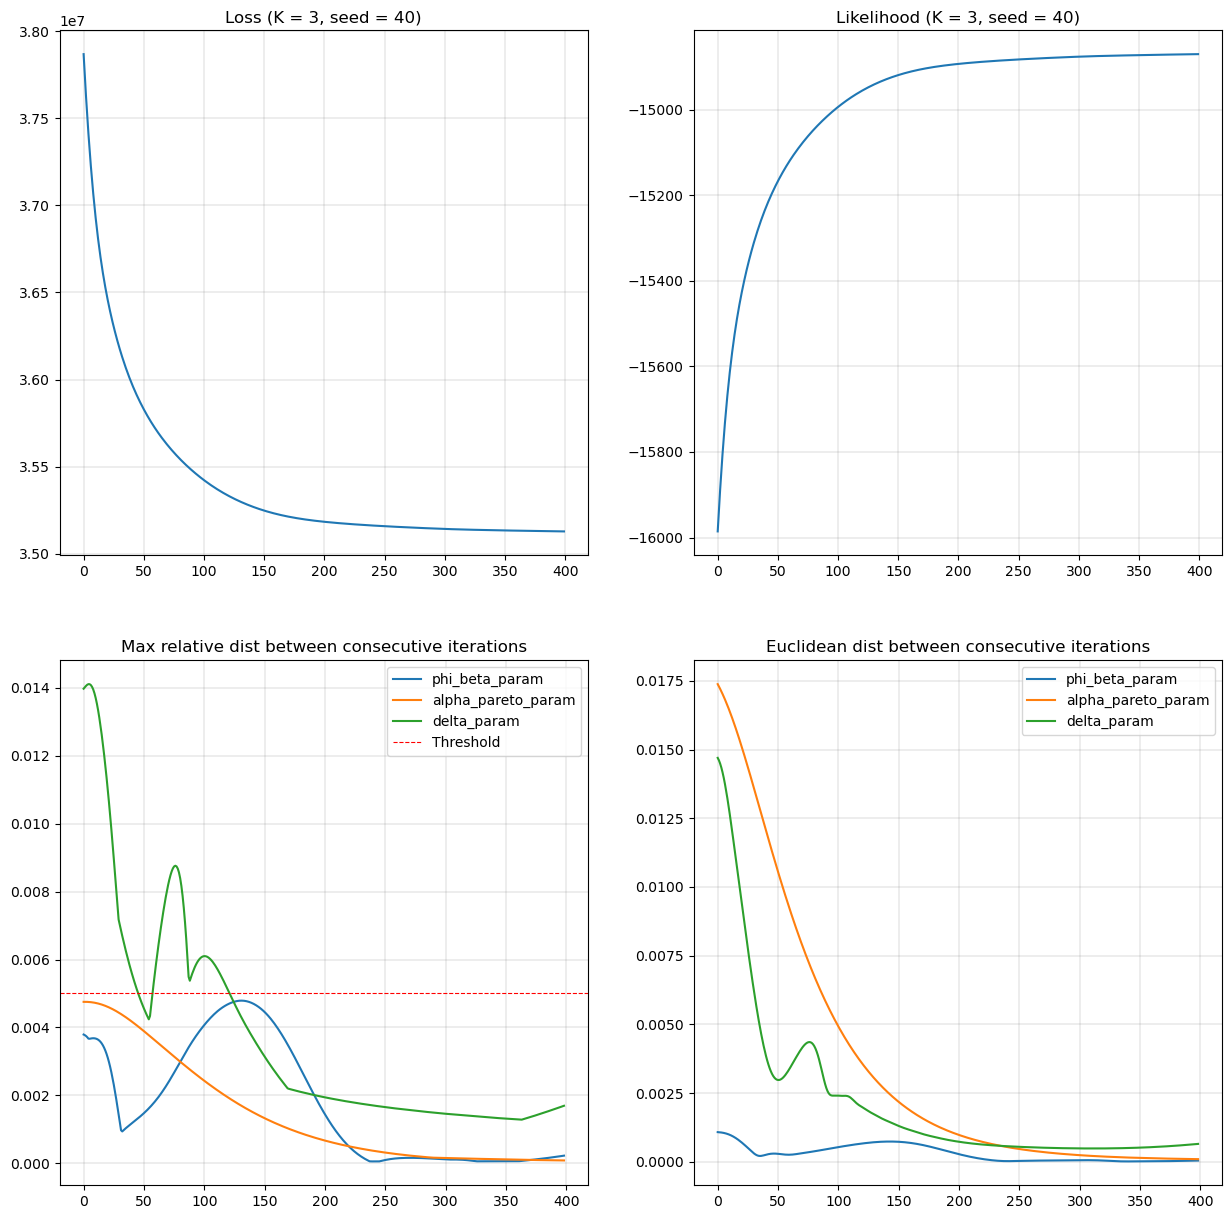

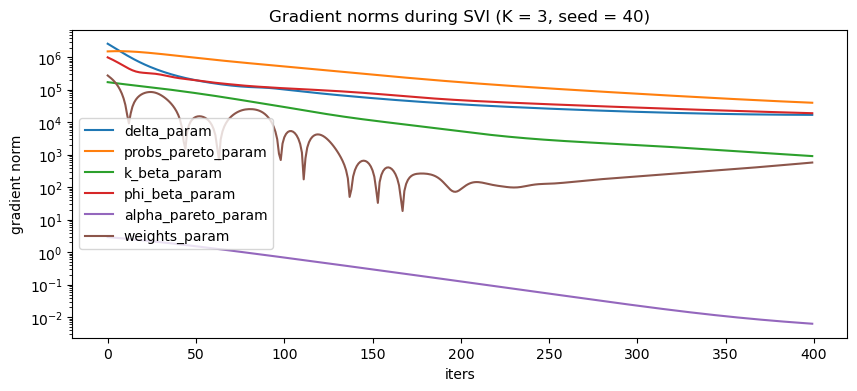

Inference lk:  -14870.374270052363
Final lk (integr):  tensor(-14933.7998, grad_fn=<SumBackward0>)
n_params:  45
n:  tensor(2361)
lk:  tensor(-14933.7998, grad_fn=<SumBackward0>)
bic: 30217.107421875 



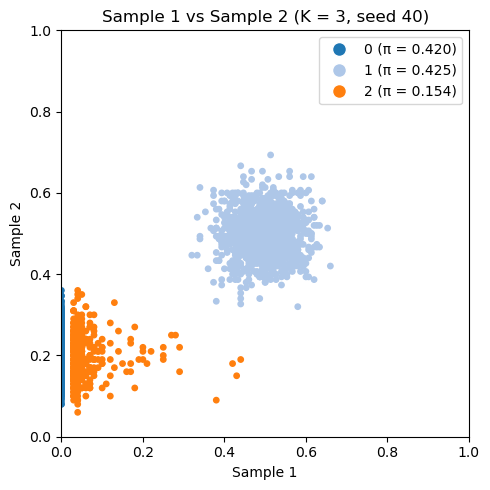

Time taken for K = 3 and seed = 40: 5.334 seconds
RUN WITH K = 3 AND SEED = 41
Minimum detected VAF: tensor(0.0300)


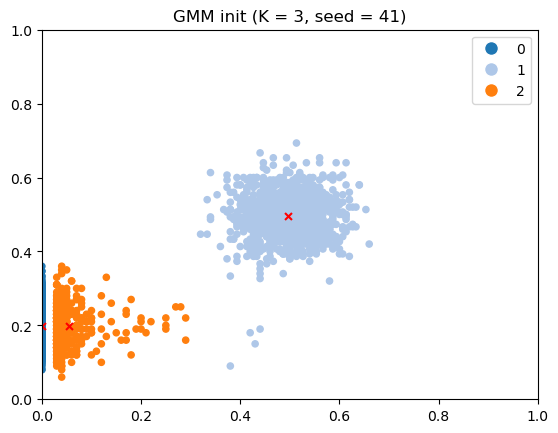

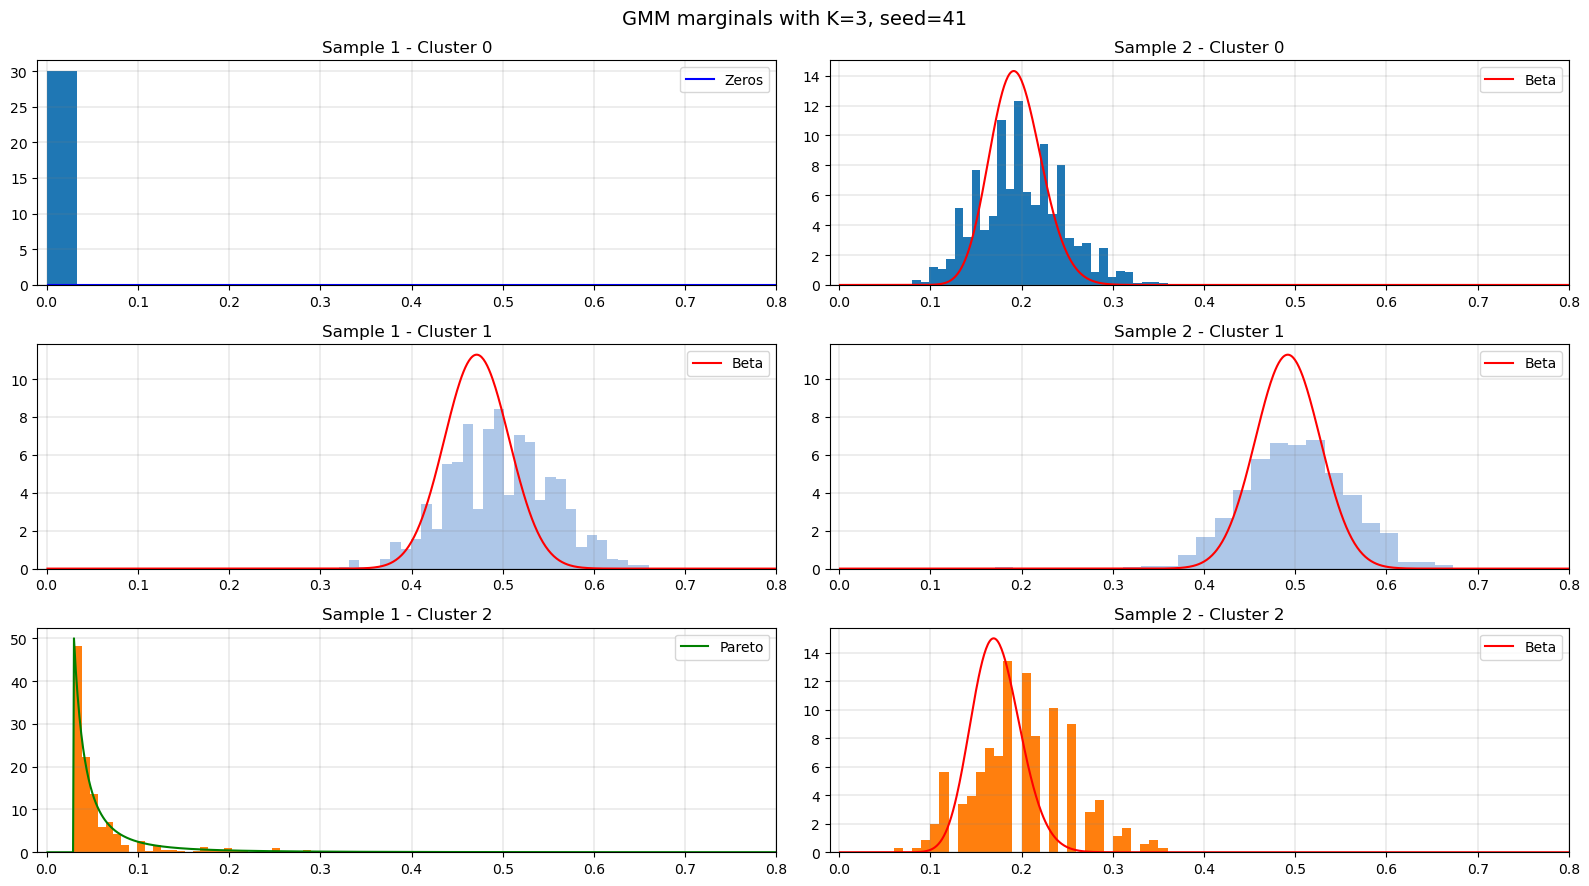

Iteration 0: Loss = 37932015.796774775
Iteration 50: Loss = 35772694.31586167
Iteration 100: Loss = 35356144.377627075
Iteration 150: Loss = 35226212.98334929
Iteration 200: Loss = 35177123.21096365
Iteration 250: Loss = 35153524.25807451
Iteration 300: Loss = 35140615.690179005
Iteration 350: Loss = 35132955.65518896


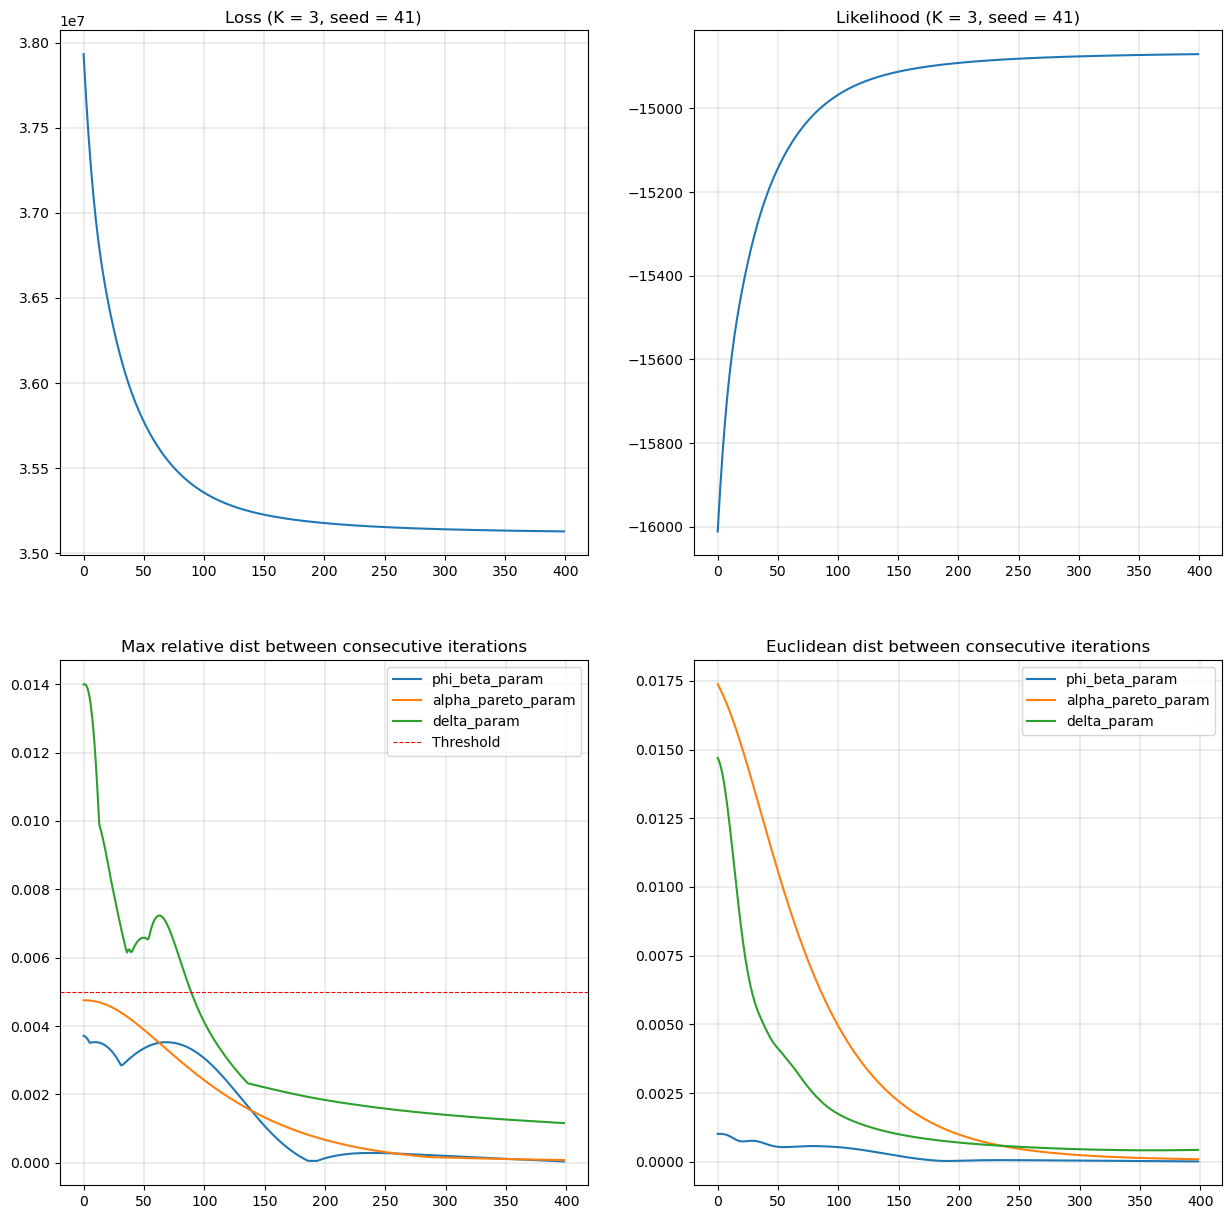

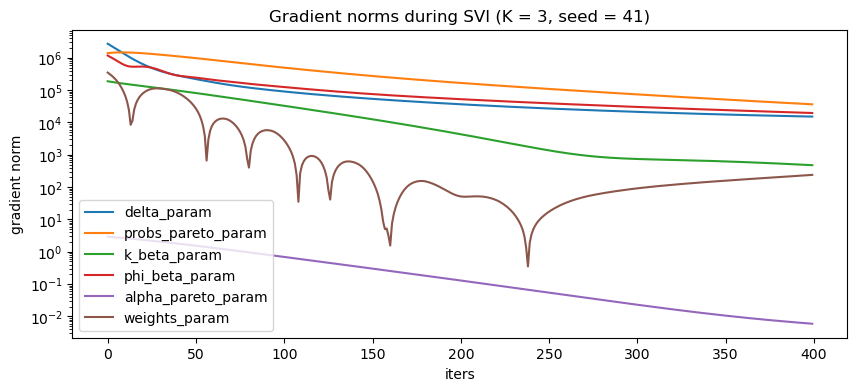

Inference lk:  -14870.23997398582
Final lk (integr):  tensor(-14933.1611, grad_fn=<SumBackward0>)
n_params:  45
n:  tensor(2361)
lk:  tensor(-14933.1611, grad_fn=<SumBackward0>)
bic: 30215.830078125 



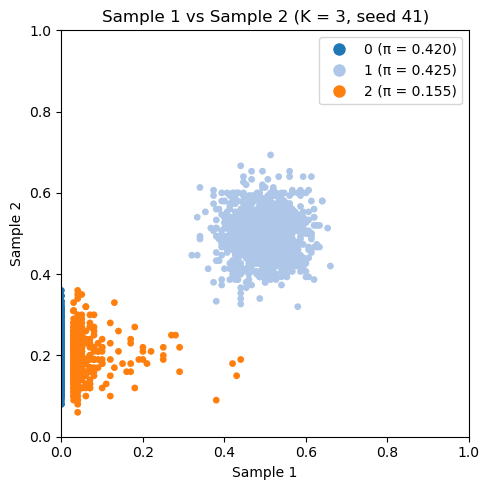

Time taken for K = 3 and seed = 41: 5.038 seconds


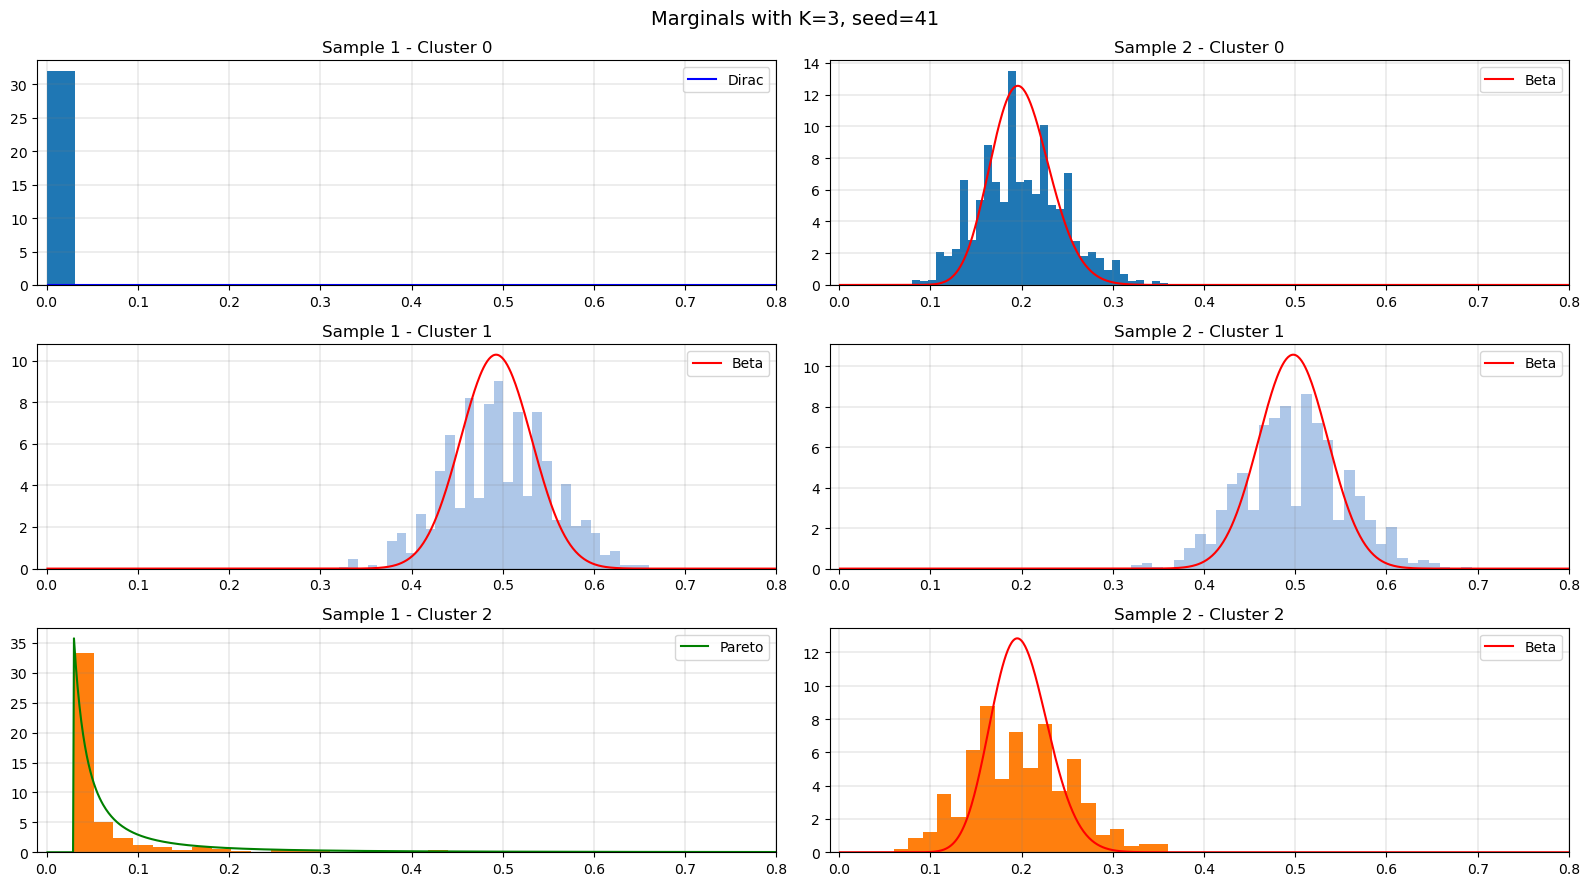

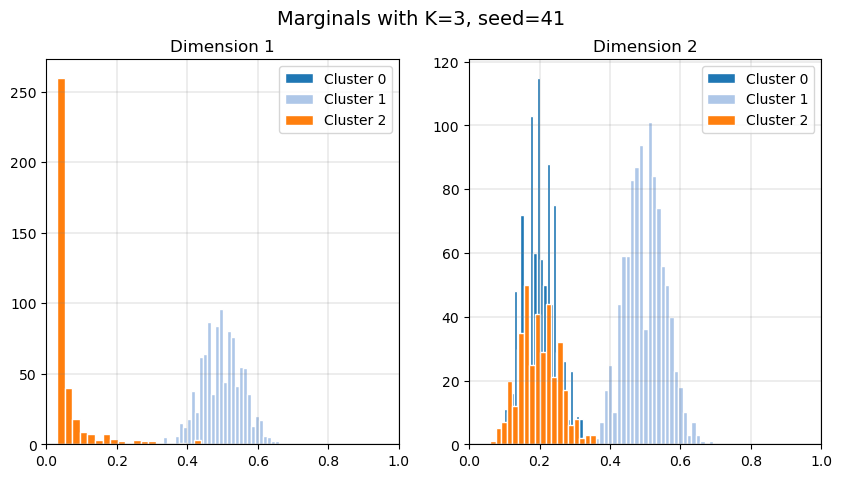

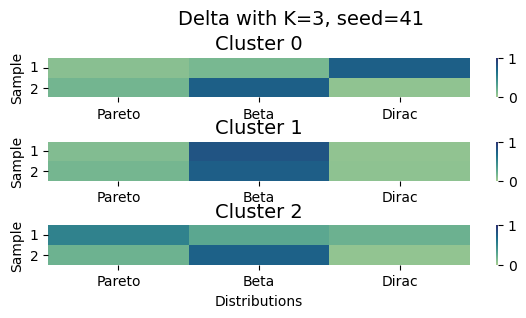

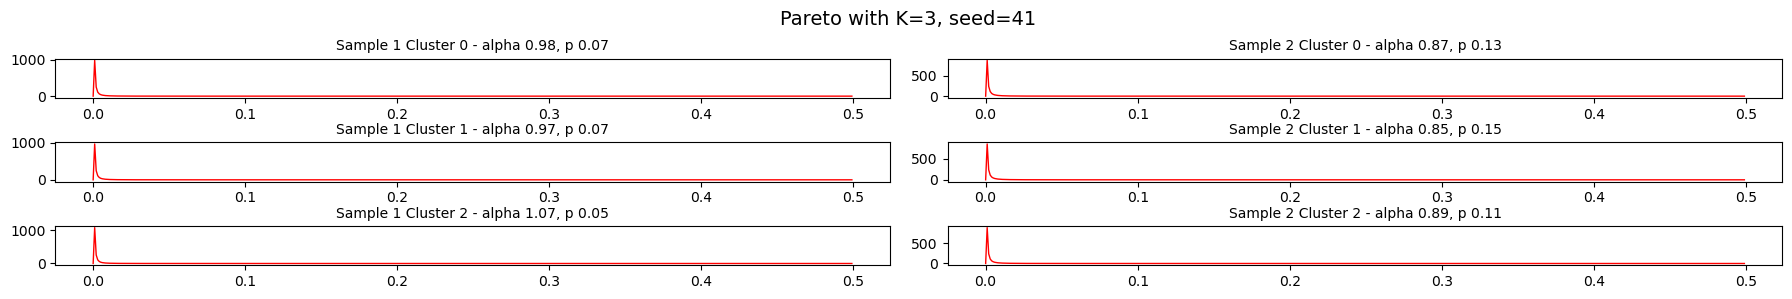

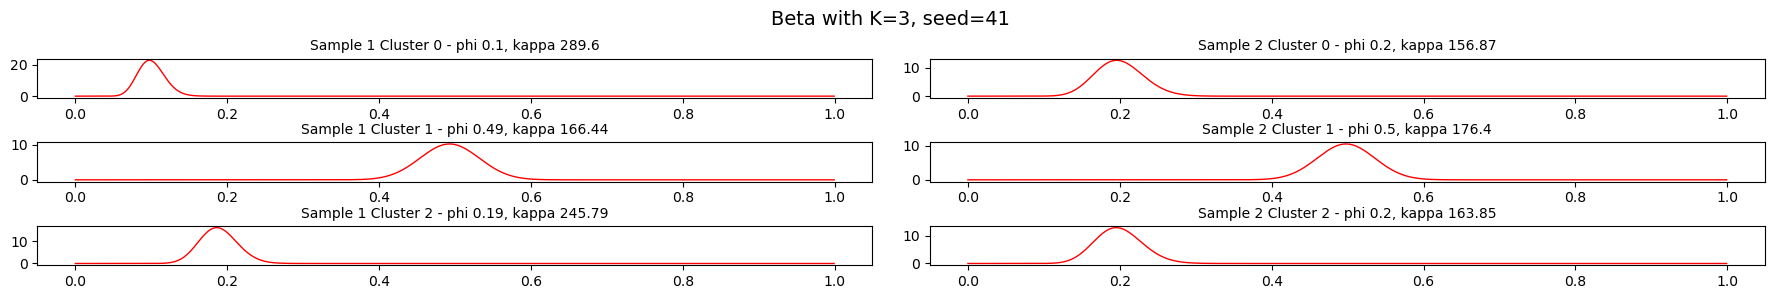

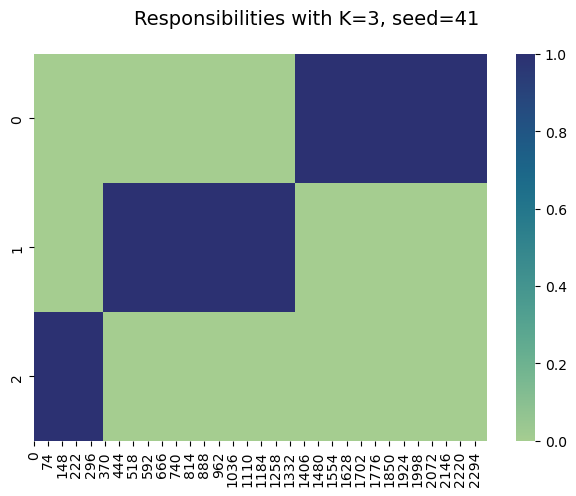

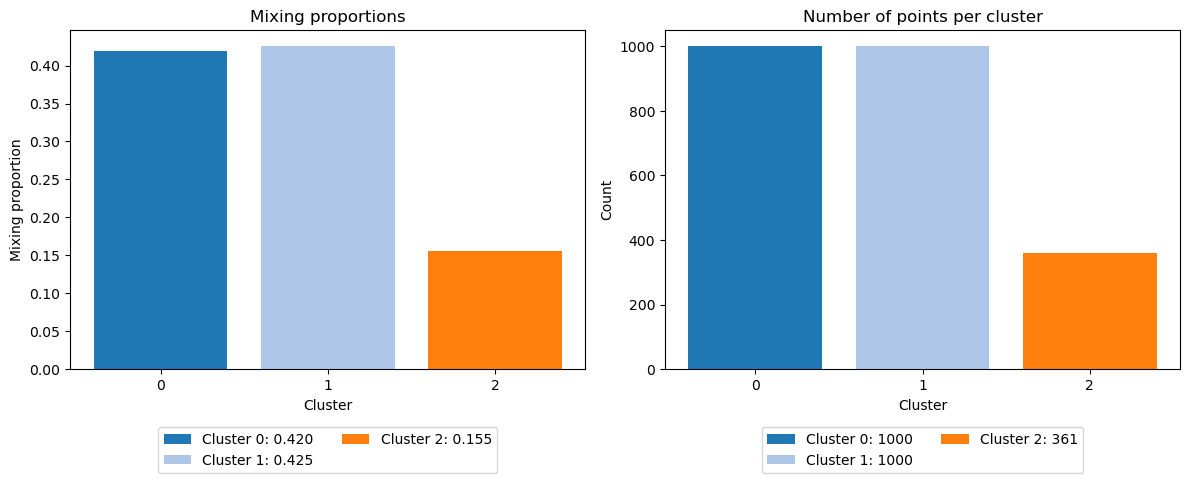

Selected number of clusters is 3 with seed 41


In [13]:
K_list = [3]
seed_list = [40,41]
mb_list, best_K, best_seed = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = K_list, seed = seed_list, lr = 0.01)

In [16]:
for i in range(len(mb_list)):
    print("K = ", mb_list[i].K)
    bic = mb_list[i].final_dict['bic']
    print("\t BIC: ", bic.item())
    print("\t Loss: ", mb_list[i].final_dict['final_loss'])
    print("\t Likelihood: ", mb_list[i].final_dict['final_likelihood'].item())

K =  3
	 BIC:  51393.453125
	 Loss:  55969397.00569558
	 Likelihood:  -25444.525390625


### Approximated Dirac delta

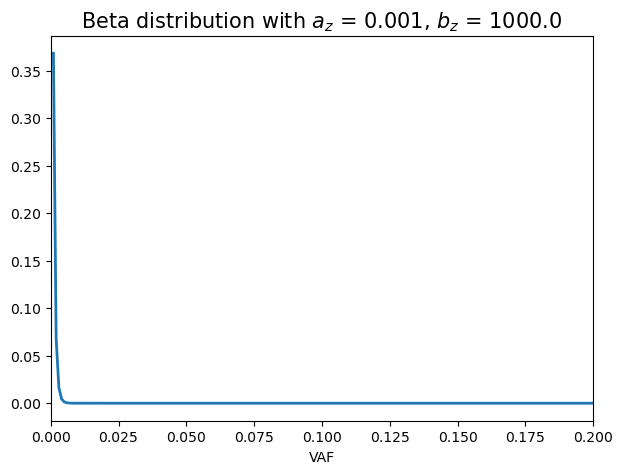

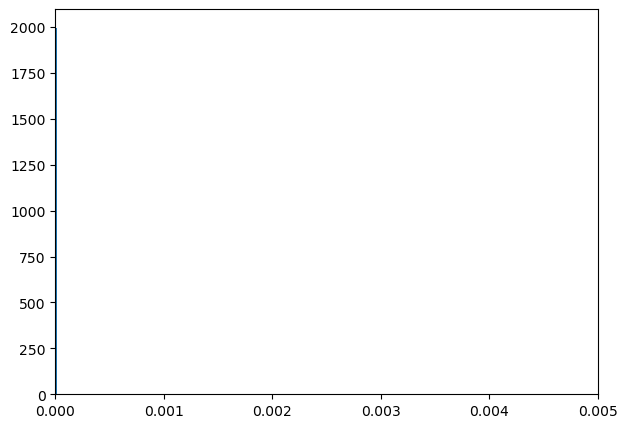

In [17]:
x = np.linspace(0.001, 0.999, 1000)
a_beta = 1e-3
b_beta = 1e3
pdf = beta.pdf(x, a_beta, b_beta)


plt.figure(figsize=(7, 5))
plt.xlim([0,0.2])
plt.xlabel('VAF')
plt.title(f"Beta distribution with $a_z$ = {a_beta}, $b_z$ = {b_beta}", fontsize = 15)
plt.plot(x, pdf,linewidth=2)

plt.figure(figsize=(7, 5))
samples = dist.Beta(a_beta, b_beta).sample([2000])
plt.xlim([0,0.005])
plt.hist(samples, bins = 50);

Exponential distribution with $\lambda >>$

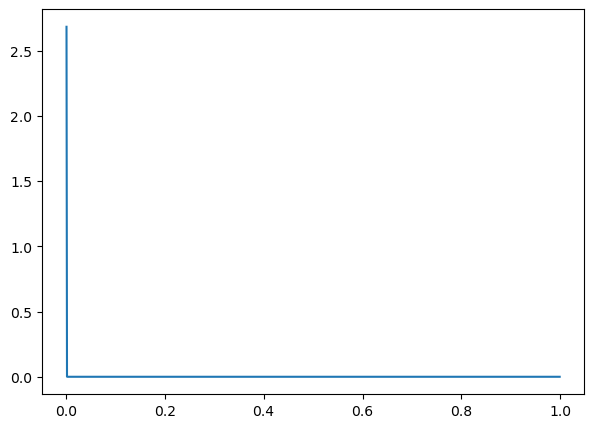

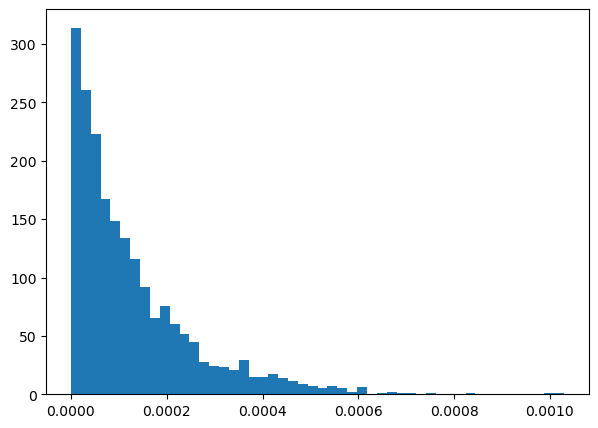

In [18]:
x = np.linspace(0.001, 0.999, 1000)
rate = 8000
pdf = expon.pdf(x, scale = 1/rate)

plt.figure(figsize=(7, 5))
# plt.xlim([0,0.2])
plt.plot(x, pdf,linewidth=1.5)


plt.figure(figsize=(7, 5))
samples = dist.Exponential(rate).sample([2000])
# plt.xlim([0,0.001])
plt.hist(samples, bins = 50);

### Reconstructed rRACES multisample data

In [14]:
N1 = 500
N2 = 500
N3 = 500
N4 = 500
N5 = 500
N6 = 500
seed = 123
# Component 1
phi_beta_x = 0.5
k_beta_x = 400
phi_beta_y = 0.5
k_beta_y= 400
n1=100
NV1, DP1 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n1, N=N1, seed=seed)


# Component 2
phi_beta_x = 0.5
k_beta_x = 400
phi_beta_y = 1e-10
k_beta_y= 400
n2=100
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV2[:,1] = torch.tensor(0, dtype=NV2.dtype)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.2
k_beta_x = 400
phi_beta_y = 1e-10
k_beta_y= 400
n3=100
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV3[:,1] = torch.tensor(0, dtype=NV3.dtype)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))


# Component 4
phi_beta_x = 1e-10
k_beta_x = 400
phi_beta_y = 0.4
k_beta_y= 350
n4=100
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n4, N=N4, seed=seed)
NV4[:,0] = torch.tensor(0, dtype=NV4.dtype)
NV = torch.concat((NV,NV4))
DP = torch.concat((DP,DP4))


# Component 5
L_pareto = 0.05
H_pareto = 0.5
alpha_pareto = 1.5 # x-axis
phi_beta = 1e-10 # y-axis
k_beta = 400
n5=100
NV5, DP5 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5,exchanged = False, seed = seed)
NV5[:,1] = torch.tensor(0, dtype=NV1.dtype)
NV5[np.where(NV5[:,0] == 0), 0] = torch.tensor(1, dtype=NV5.dtype)
NV = torch.concat((NV,NV5))
DP = torch.concat((DP,DP5))
print(NV.shape)
print(DP.shape)


# Component 6
alpha_pareto = 1.5
phi_beta = 1e-10
k_beta = 400
n6=100
NV6, DP6 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n6, N=N6, exchanged = True, seed = seed)
NV6[:,0] = torch.tensor(0, dtype=NV6.dtype)
NV6[np.where(NV6[:,1] == 0), 1] = torch.tensor(1, dtype=NV6.dtype)
NV = torch.concat((NV,NV6))
DP = torch.concat((DP,DP6))

torch.Size([2500, 2])
torch.Size([2500, 2])


In [5]:
def get_a_beta(phi, kappa):
    return phi * (kappa)

def get_b_beta(phi, kappa):
    return (1-phi) * (kappa)

In [15]:
print(NV/DP)
print("BetaBinomial zeros:\n", dist.BetaBinomial(1e-3,1e3,total_count=DP).log_prob(NV))

phi = 0.5
kappa = 300
a = get_a_beta(phi,kappa)
b = get_b_beta(phi,kappa)
print("BetaBinomial:\n", dist.BetaBinomial(a,b, total_count=DP).log_prob(NV))

print("Binomial (tail):\n", dist.Binomial(total_count=DP, probs = 0.01).log_prob(NV))

tensor([[0.4400, 0.4800],
        [0.4600, 0.5500],
        [0.5200, 0.4700],
        ...,
        [0.0000, 0.0500],
        [0.0000, 0.4400],
        [0.0000, 0.1900]])
BetaBinomial zeros:
 tensor([[-126.5239, -138.4580],
        [-132.4566, -160.0396],
        [-150.6753, -135.4487],
        ...,
        [   0.0000,  -20.5927],
        [   0.0000, -126.5239],
        [   0.0000,  -57.0616]])


NameError: name 'get_a_beta' is not defined

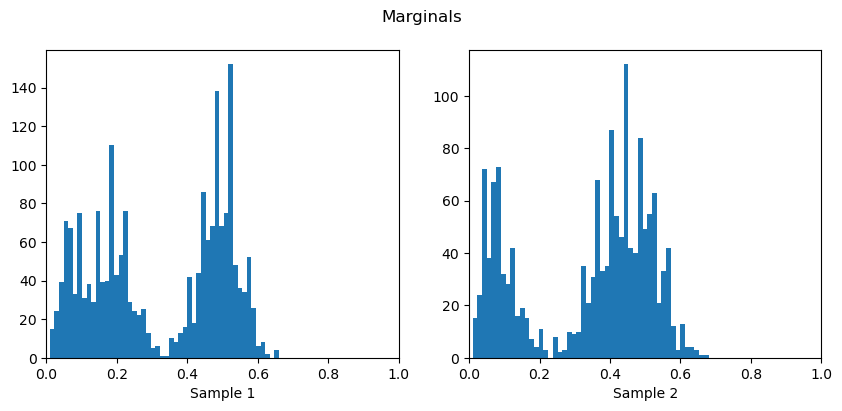

In [7]:
vaf = NV/DP
condition = (vaf == 0) | (vaf > 0.04)
mask = torch.all(condition, dim=1)
# vaf = vaf[mask]
# NV = NV[mask]
# DP = DP[mask]

D = NV.shape[1]
fig, axes = plt.subplots(1, D, figsize=(5*D, 4))
plt.suptitle("Marginals")

for i in range(D):
    x = vaf[:, i].numpy()
    
    x = x[x > 0]
    axes[i].hist(x, bins = 50)    
    
    axes[i].set_xlabel(f"Sample {i+1}")
    axes[i].set_xlim([0,1])

plt.show()

In [8]:
vaf = NV/DP
copy_vaf = torch.clone(vaf)
# Replace zeros with a large value that will not be considered as minimum (i.e. 1)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value for each column excluding zeros
min_values, _ = torch.min(masked_tensor, dim=0)
min_vaf = torch.min(min_values)
print("Minimum detected VAF:", min_vaf)

Minimum detected VAF: tensor(0.0100)


In [16]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N4)*3
labels = np.concatenate((labels, labels_4))
labels_5 = np.ones(N5)*4
labels = np.concatenate((labels, labels_5))
labels_6 = np.ones(N6)*5
labels = np.concatenate((labels, labels_6))

/Users/elenarivaroli/miniconda3/envs/mobster/lib/python3.11/site-packages/matplotlib/collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


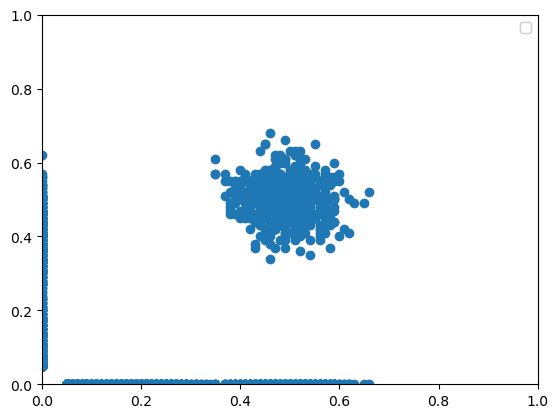

In [17]:
fig, ax = plt.subplots()

# scatter = ax.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)
scatter = ax.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best")
ax.add_artist(legend1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])

plt.show()

In [19]:
def get_a_beta(phi, kappa):
    return phi * kappa
def get_b_beta(phi, kappa):
    return (1-phi) * (kappa)

def beta_lk(data, phi,kappa):
    """
    Compute log probabilities of beta for a single dimension of a single cluster.
    """
    a_beta = get_a_beta(phi,kappa)
    b_beta = get_b_beta(phi,kappa)
    beta = dist.Beta(a_beta, b_beta).log_prob(data)
    return beta

def pareto_lk(data, alpha, pareto_L, pareto_H):
    """
    Compute log probabilities of pareto for a single dimension of a single cluster.
    """
    pareto = BoundedPareto(pareto_L, alpha, pareto_H).log_prob(data)
    return pareto

start = 0.011
end = 0.5
step = 0.001
vaf_range = torch.arange(start, end, step)
phi = 0.12
kappa = 200.
alpha = 1.5
pareto_L = 0.01
pareto_H = 0.5
pareto_ = []
beta_ = []
for i in vaf_range:
    pareto_.append(pareto_lk(i, alpha, pareto_L, pareto_H))
    beta_.append(beta_lk(i, phi, kappa))


In [20]:
for i in range(len(vaf_range)):
    if beta_[i]>pareto_[i]:
        print(vaf_range[i])
        break

tensor(0.0710)


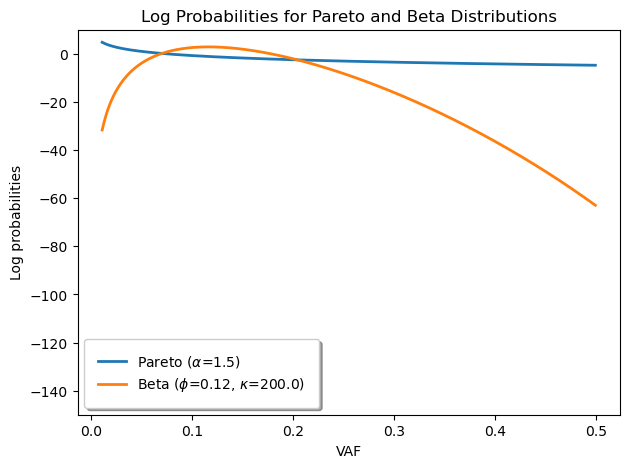

In [21]:
plt.figure(figsize=(7, 5))
plt.plot(vaf_range, pareto_, label=f'Pareto ($\\alpha$={alpha})', linestyle='-', linewidth=2)
plt.plot(vaf_range, beta_, label=f'Beta ($\\phi$={phi}, $\\kappa$={kappa})', linestyle='-', linewidth=2)

plt.xlabel('VAF')
plt.ylabel('Log probabilities')
plt.title('Log Probabilities for Pareto and Beta Distributions')
plt.legend(loc ='best',fontsize=10, frameon=True, shadow=True, borderpad=1)
# plt.grid()
plt.ylim([-150,10])

plt.show()

No GPU available.
RUN WITH K = 6 AND SEED = 41
Minimum detected VAF: tensor(0.0500)


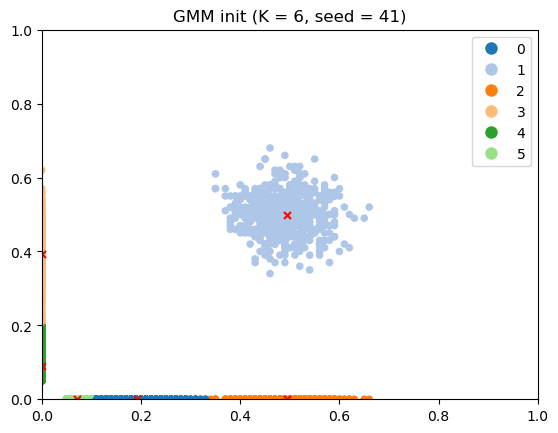

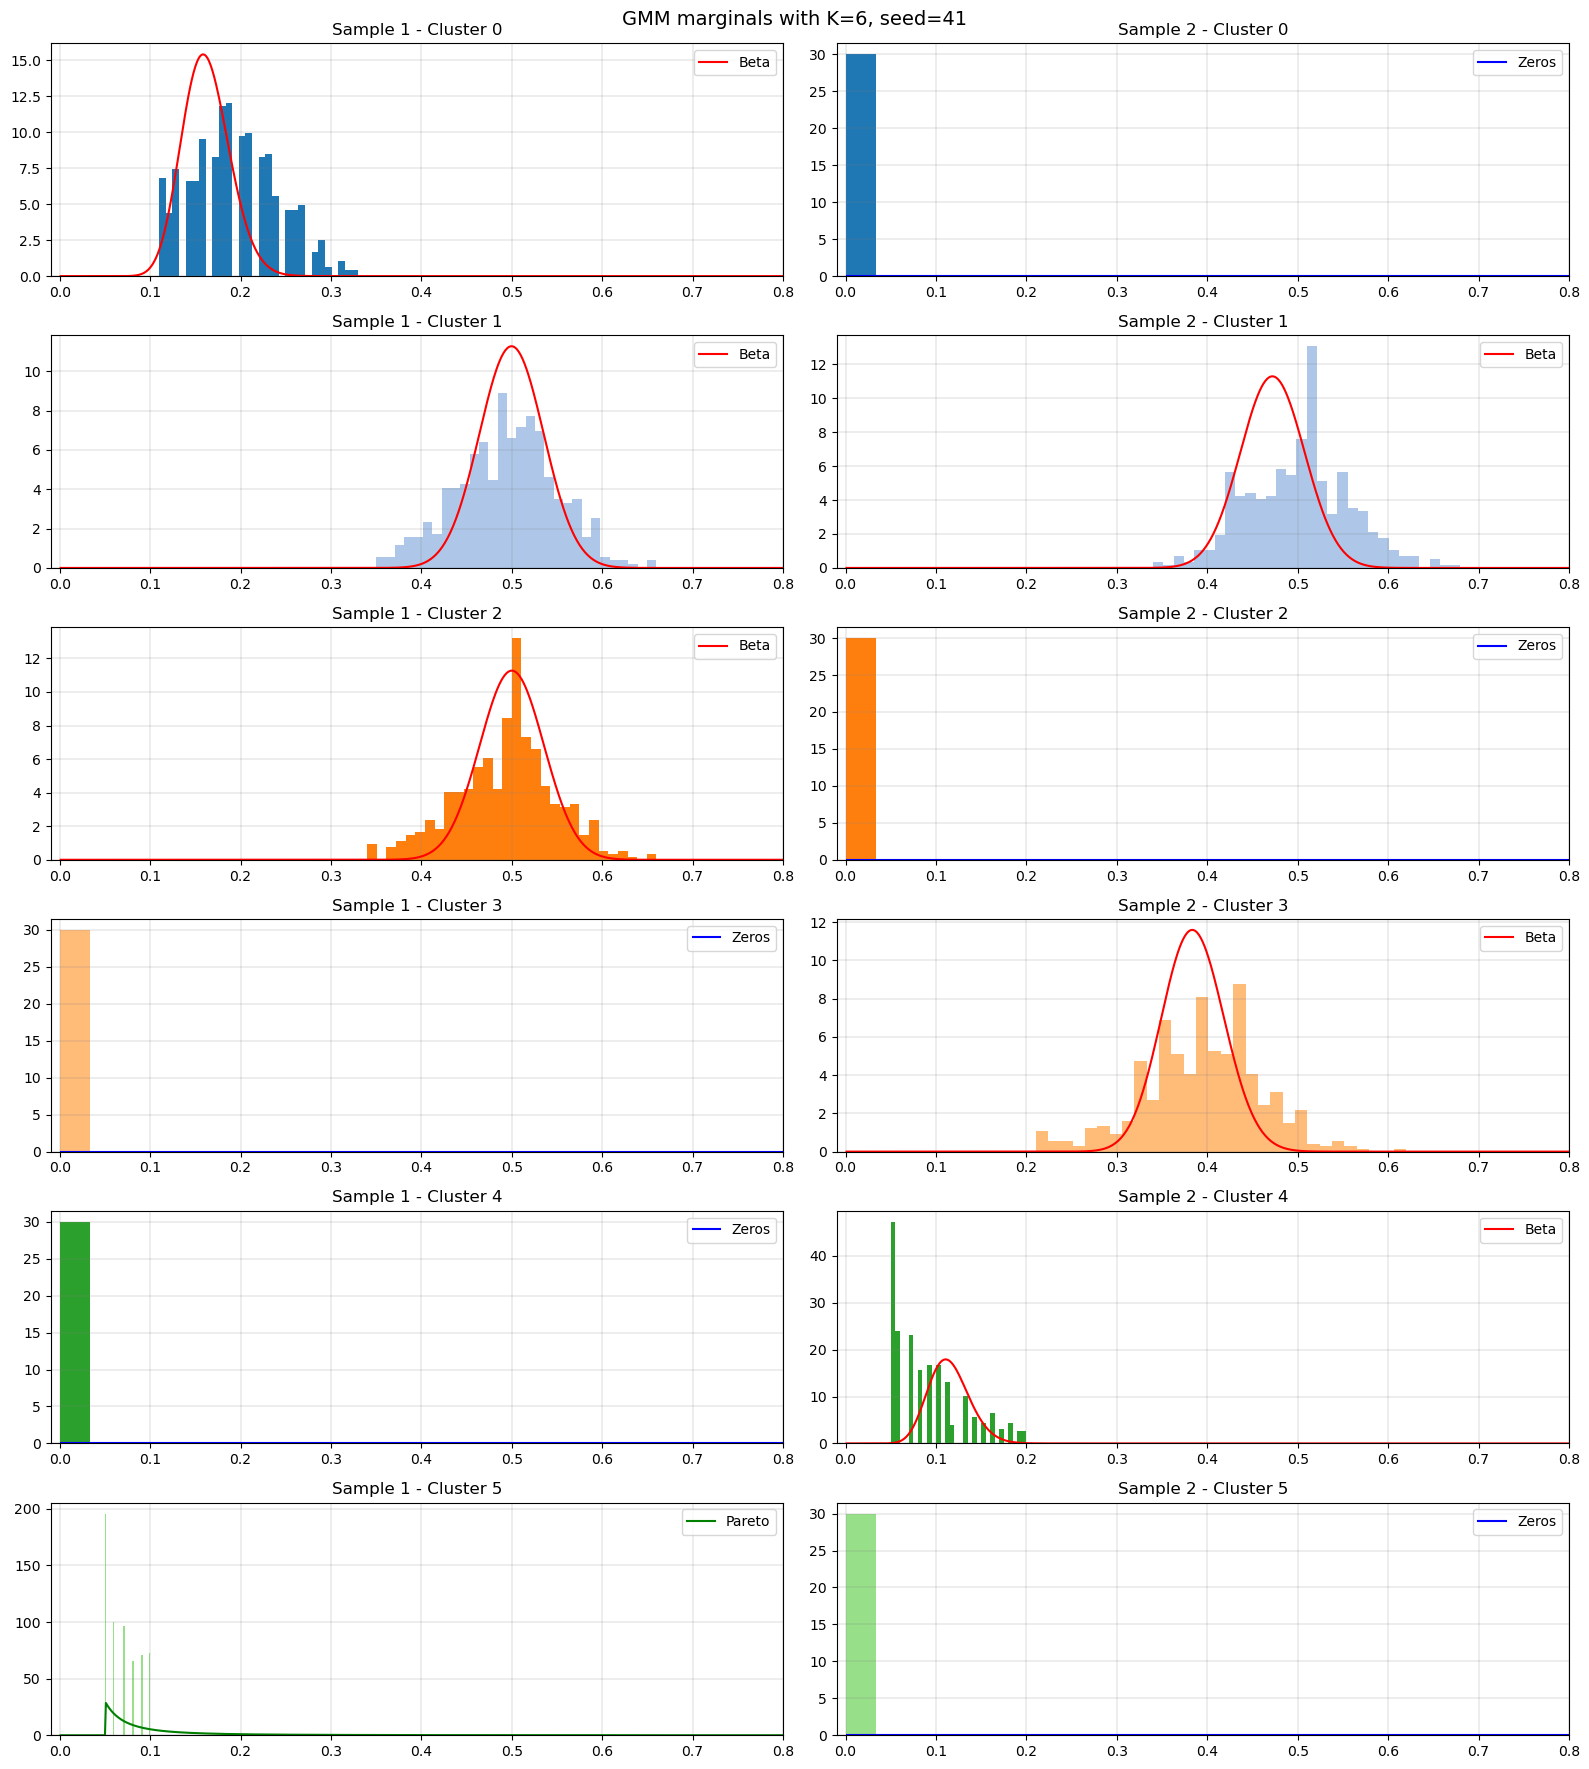

Iteration 0: Loss = 49826754.31810039
Iteration 50: Loss = 47219163.37391312
Iteration 100: Loss = 47012026.12720055
Iteration 150: Loss = 46941990.45114618
Iteration 200: Loss = 46898884.9121816
Iteration 250: Loss = 46872996.66034695
Iteration 300: Loss = 46856003.43527763
Iteration 350: Loss = 46845083.11842975


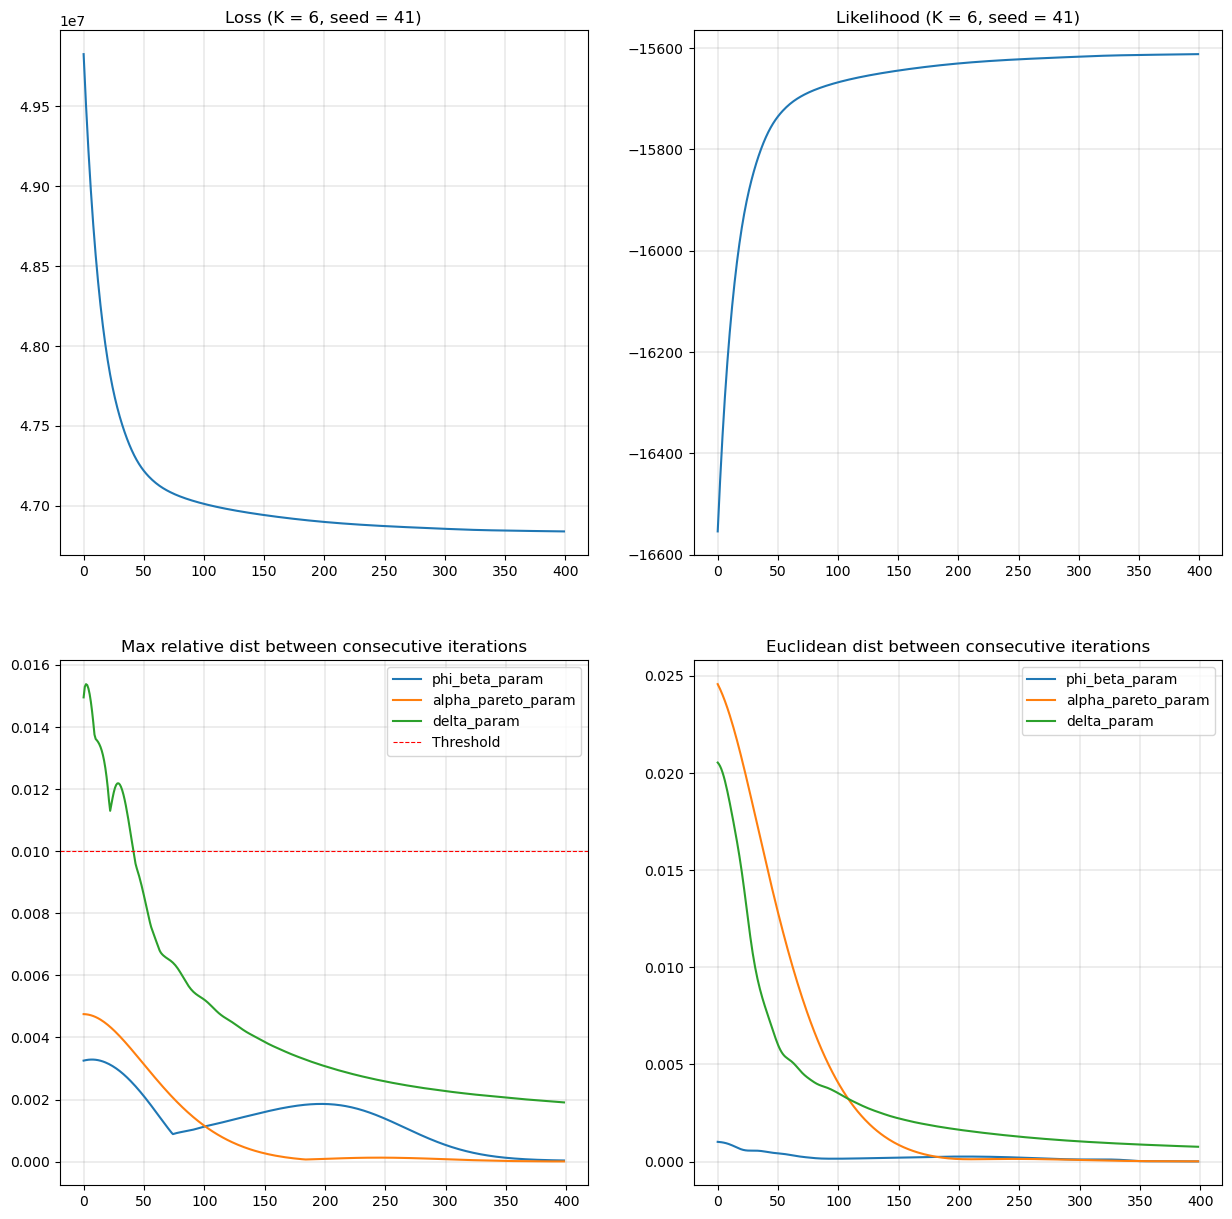

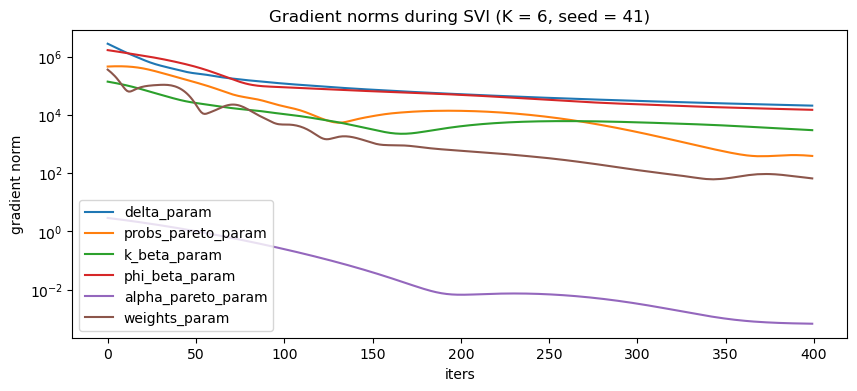

Inference lk:  -15611.795777554322
Final lk (integr):  tensor(-15762.5254, grad_fn=<SumBackward0>)
n_params:  90
n:  tensor(3000)
lk:  tensor(-15762.5254, grad_fn=<SumBackward0>)
bic: 32245.623046875 



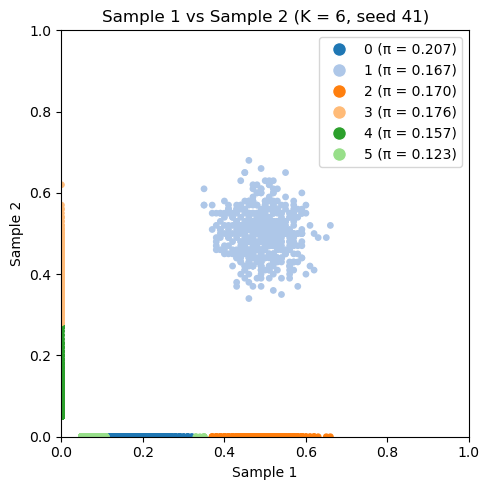

Time taken for K = 6 and seed = 41: 8.677 seconds


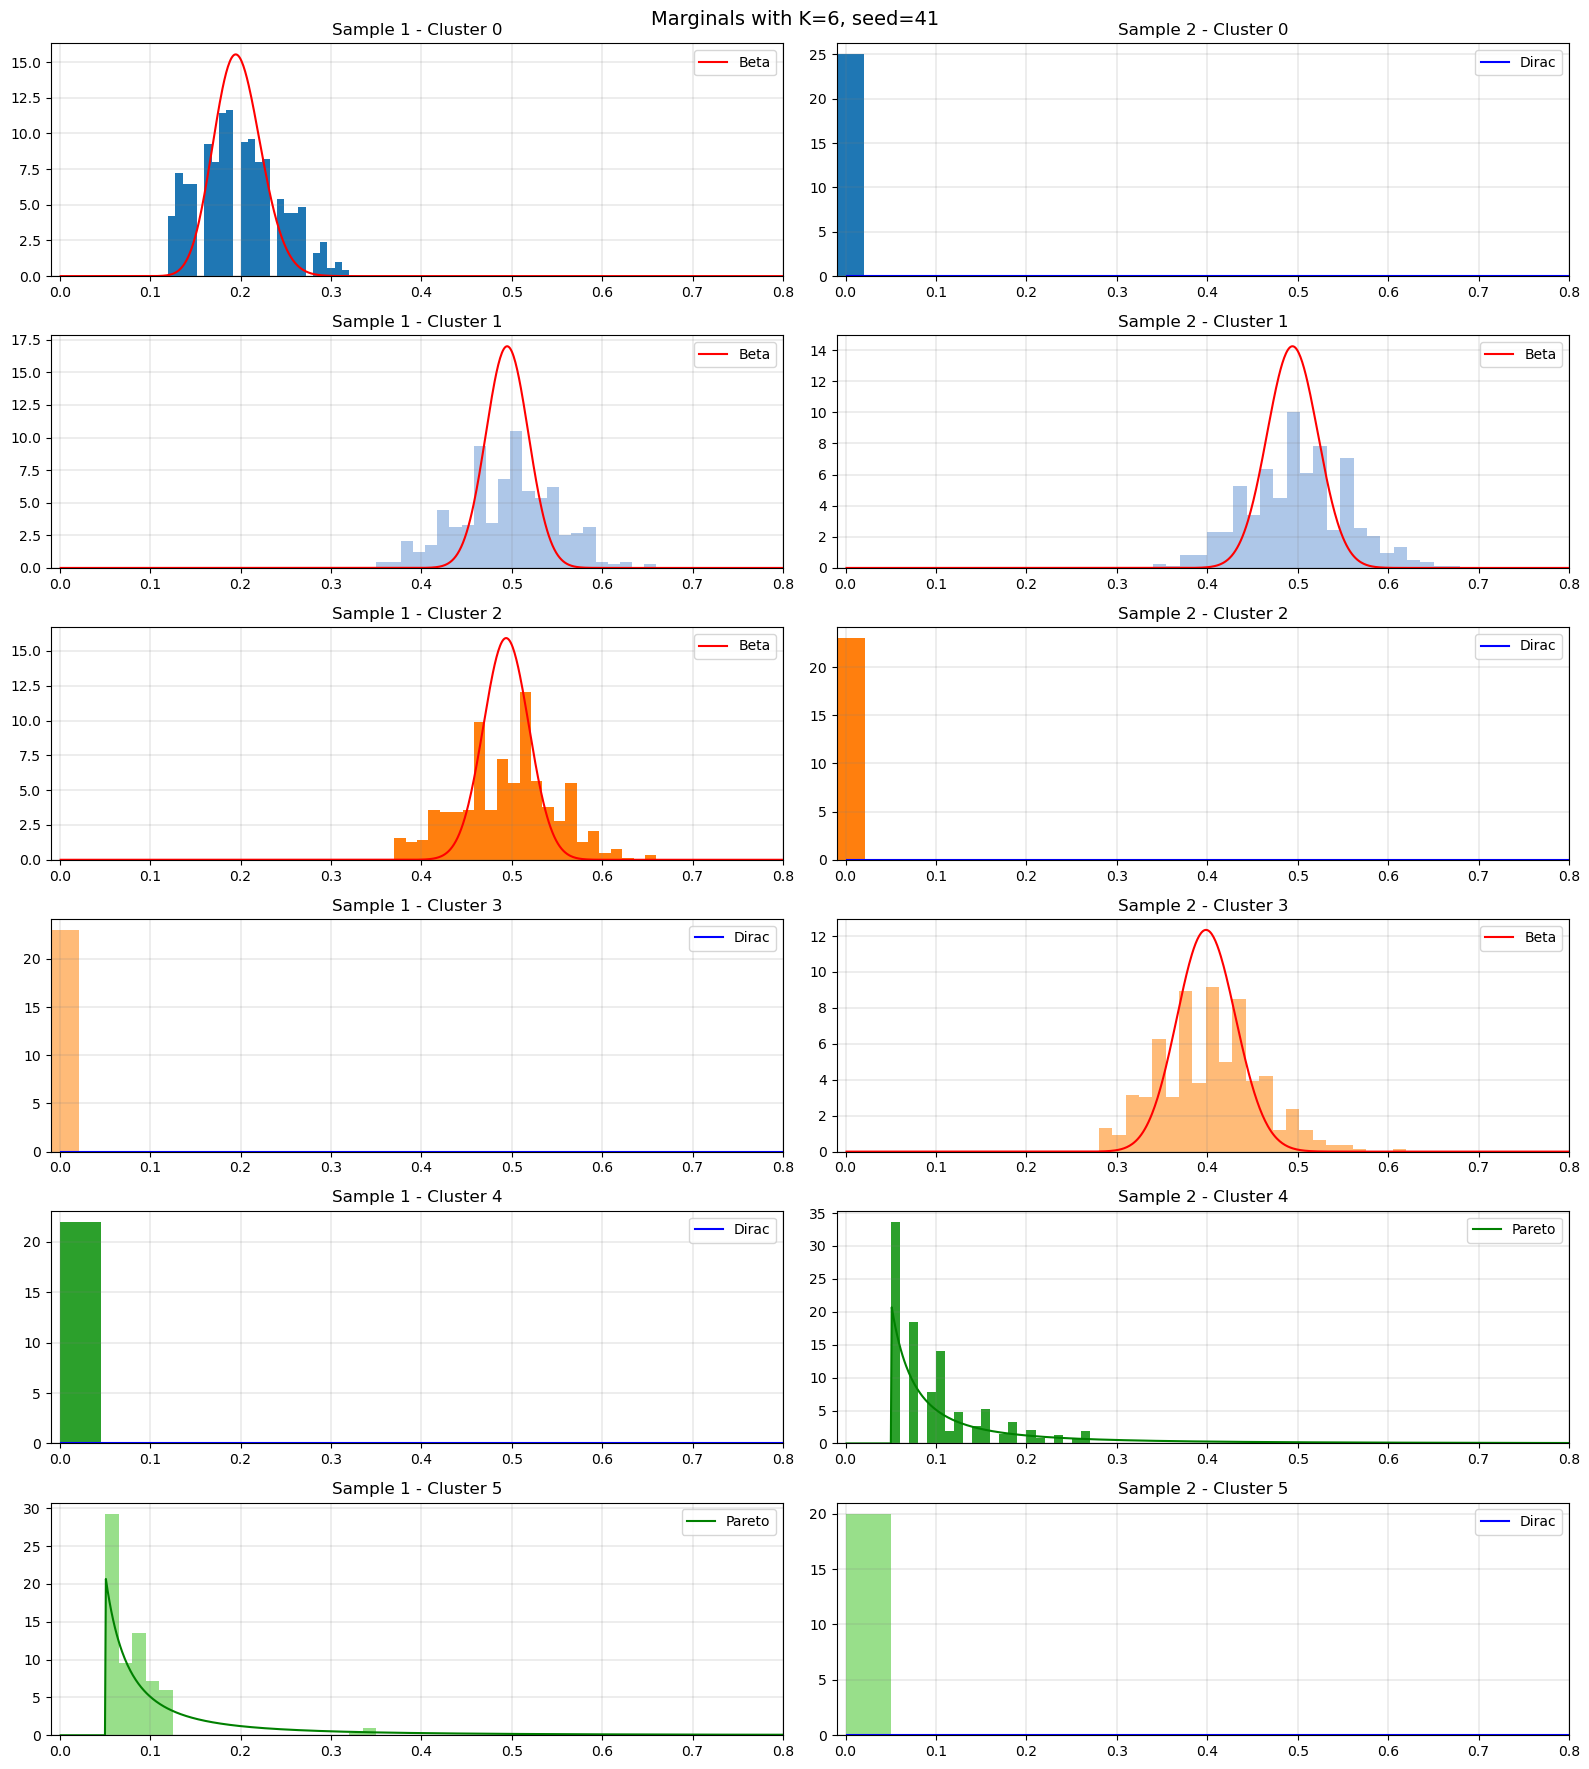

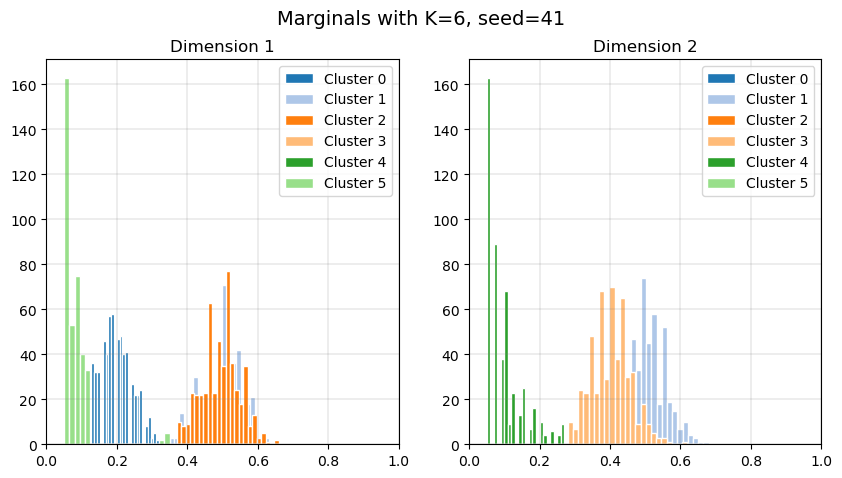

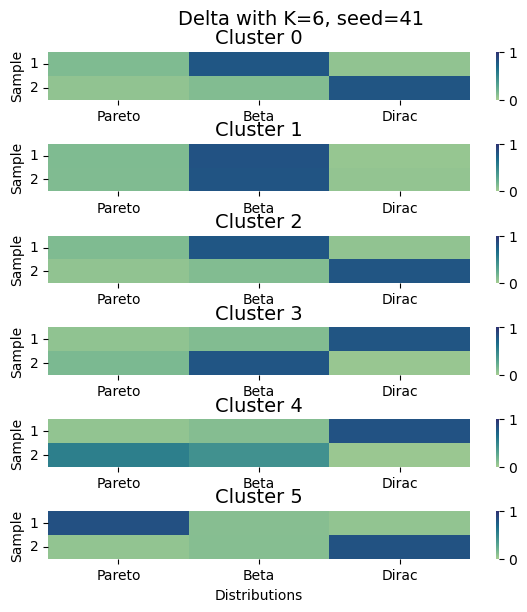

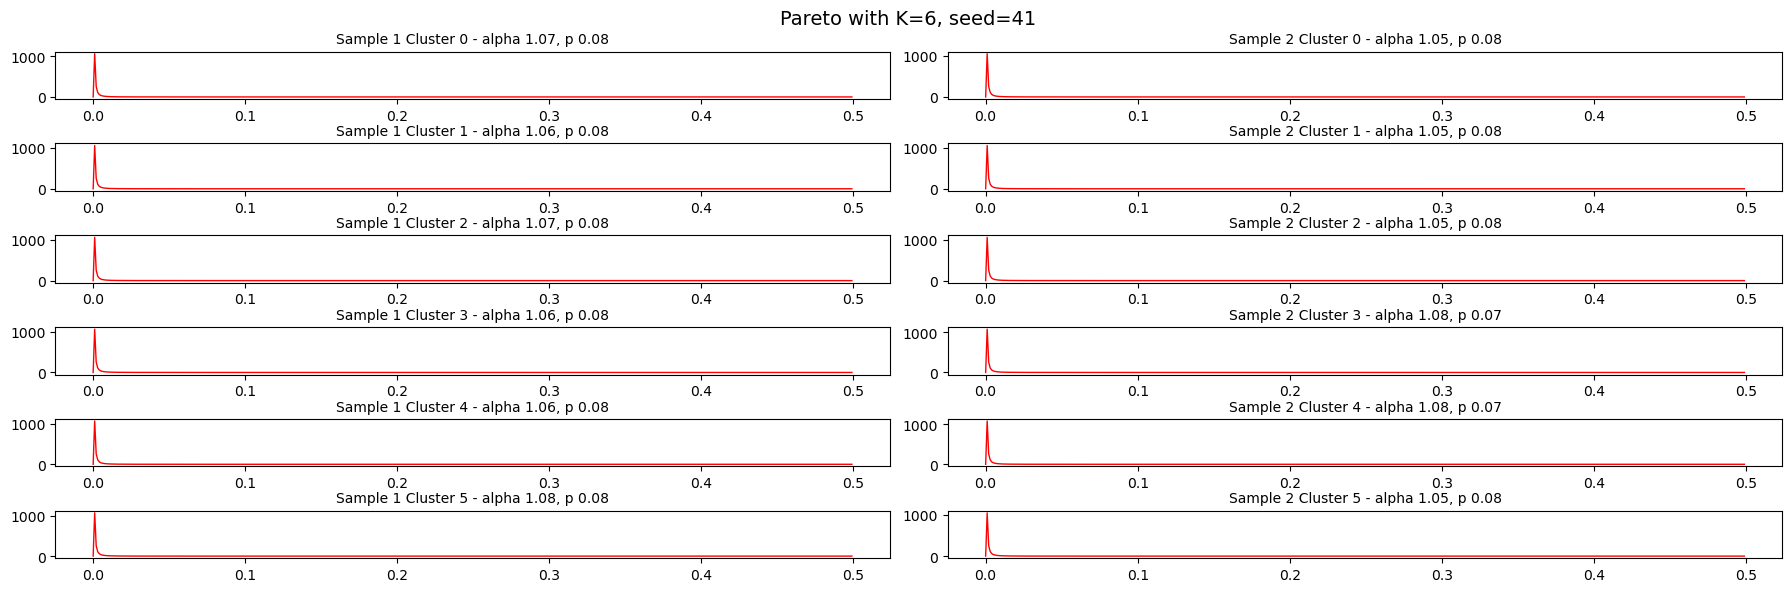

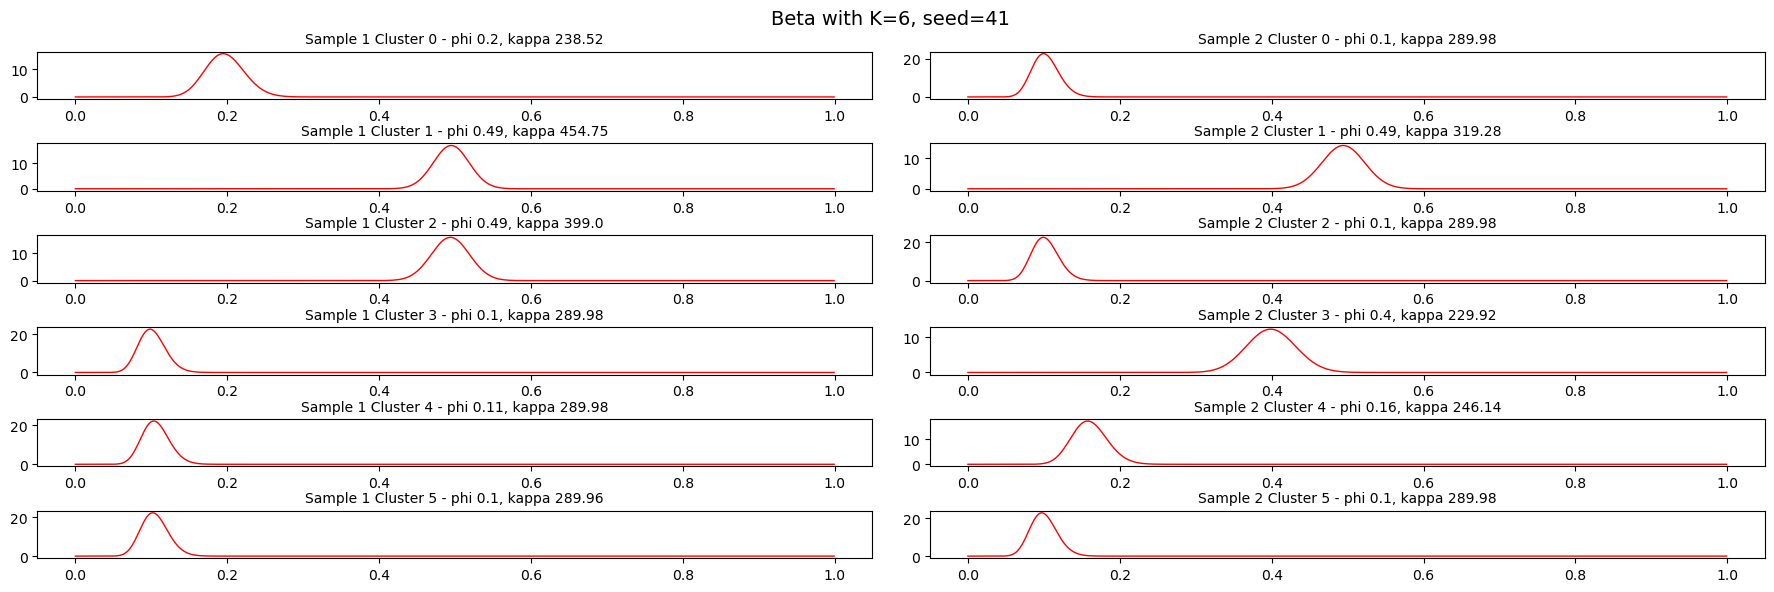

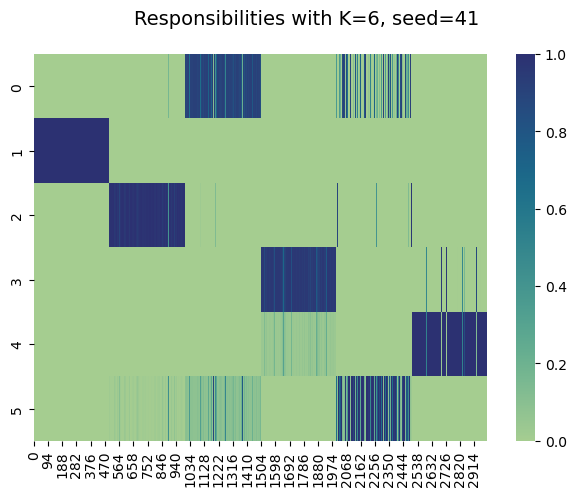

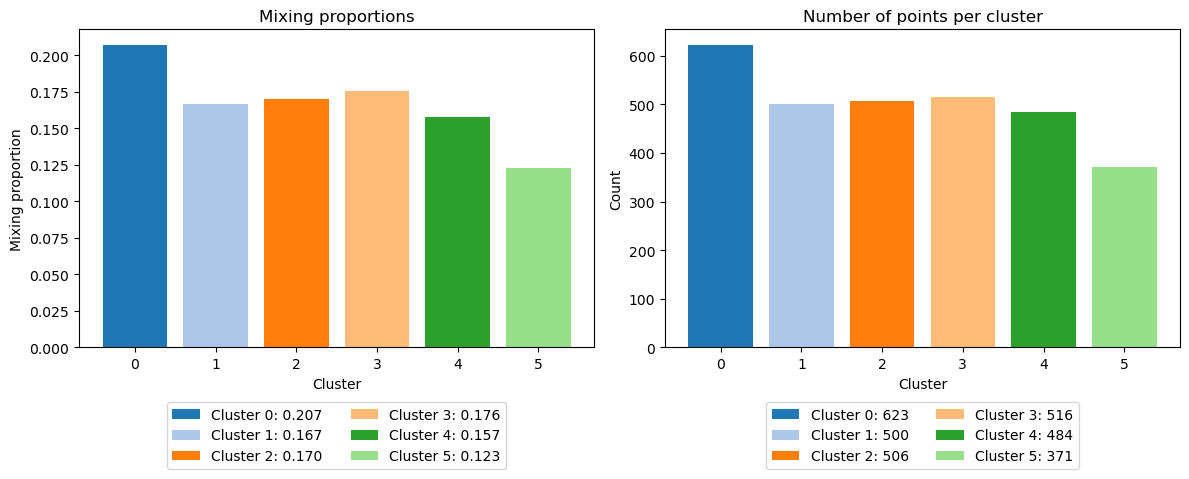

Selected number of clusters is 6 with seed 41


In [18]:
K_list = [6]
seed_list = [41]
mb_list, best_K, best_seed = model_mobster_mv.fit(NV, DP, num_iter = 2000, K = K_list,  par_threshold = 0.01, seed = seed_list, lr = 0.01)

In [41]:
def beta_lk(mb,idx,  d, a_beta, b_beta):
    """
    Compute beta-binomial likelihood for a single dimension of a single cluster.
    """
    betabin = dist.BetaBinomial(a_beta, b_beta, total_count=mb.DP[idx,d]).log_prob(mb.NV[idx,d])
    return betabin # simply does log(weights) + log(density)

def expon_lk(mb, idx,  d):
    """
    Compute exponential likelihood for a single dimension of a single cluster.
    """
    exp = dist.Exponential(mb.rate_expon).log_prob(mb.NV[idx,d])
    return exp # simply does log(weights) + log(density)

def pareto_binomial_pmf(mb, NV, DP, alpha):
    integration_points=5000
    # Generate integration points across all rows at once
    t = torch.linspace(mb.pareto_L, mb.pareto_H, integration_points).unsqueeze(0)  # Shape (1, integration_points)
    NV_expanded = NV.unsqueeze(-1)  # Shape (NV.shape[0], NV.shape[1], 1)
    DP_expanded = DP.unsqueeze(-1)  # Shape (NV.shape[0], DP.shape[1], 1)
    binom_vals = dist.Binomial(total_count=DP_expanded, probs=t).log_prob(NV_expanded).exp()
    pareto_vals = BoundedPareto(mb.pareto_L, alpha, mb.pareto_H).log_prob(t).exp()  # Shape (1, integration_points)
    integrand = binom_vals * pareto_vals

    pmf_x = torch.trapz(integrand, t, dim=-1).log()  # Shape (NV.shape[0], NV.shape[1])

    return pmf_x.tolist()  # Convert the result to a list

def pareto_lk(mb, idx, d, alpha):
    paretobin = torch.tensor(pareto_binomial_pmf(mb, NV=mb.NV[idx, d], DP=mb.DP[idx, d], alpha=alpha))
    return paretobin # tensor of len N (if D = 1, only N)

In [42]:
mb = mb_list[0]
s = 2
c = 1
d = s -1
labels = mb.params['cluster_assignments']
delta = mb.params['delta_param']
alpha = mb.params['alpha_pareto_param'][c,d]
phi = mb.params['phi_beta_param'][c,d]
kappa = mb.params['k_beta_param'][c,d]
a_beta = get_a_beta(phi, kappa)
b_beta = get_b_beta(phi, kappa)
idx = np.where((labels == c))
print(pareto_lk(mb, idx, d, alpha).sum())
print(beta_lk(mb, idx,  d, a_beta, b_beta).sum())


tensor(-4327.9551)
tensor(-1576.2844, grad_fn=<SumBackward0>)


In [ ]:

labels = mb.params['cluster_assignments']
colors = ['#FFD700', '#33A02C', '#17BECF', '#FF7F00', '#E377C2', '#B15928']
# colors = cm.get_cmap('Set1')

# colors = [
#     "tab:red",  # Darker red
#     "#A6CEE3",  # Darker blue
#     "tab:green",  # Darker green
#     "#b084b8",  # Darker purple
#     "#FFD700",  # Darker orange
#     "#4169E1",
#     "#e6e600",  # Darker yellow
#     "#b3865b",  # Darker brown
#     "#f28ab6"   # Darker pink
# ]


# colors = [  '#D3D3D3',  # Light grey
#                 '#EE82EE', # violet
#                 '#FFD700', #yellow
#                 '#8B0000', # Dark red
#                 '#A6CEE3',  # Light Blue
#                 '#FFC87C', # light orange
#                 '#000000',  # Black
#                 '#4169E1']  # Darker blue

for i, cluster in enumerate(torch.unique(labels)):
    mask = (labels == cluster)
      # Mask for current cluster
    plt.scatter(NV[mask, 0].numpy() / DP[mask, 0].numpy(), 
                NV[mask, 1].numpy() / DP[mask, 1].numpy(), 
                color=colors[i],
                label=f'{cluster}', 
                s=50, alpha=0.7)

plt.legend(loc='best')
plt.title(f"Inference with K = {mb.K}", fontsize = 18)
plt.xlabel('Sample 1')
plt.ylabel('Sample 2')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True, color='gray', linestyle='-', linewidth=0.2)
plt.show()
plt.close()

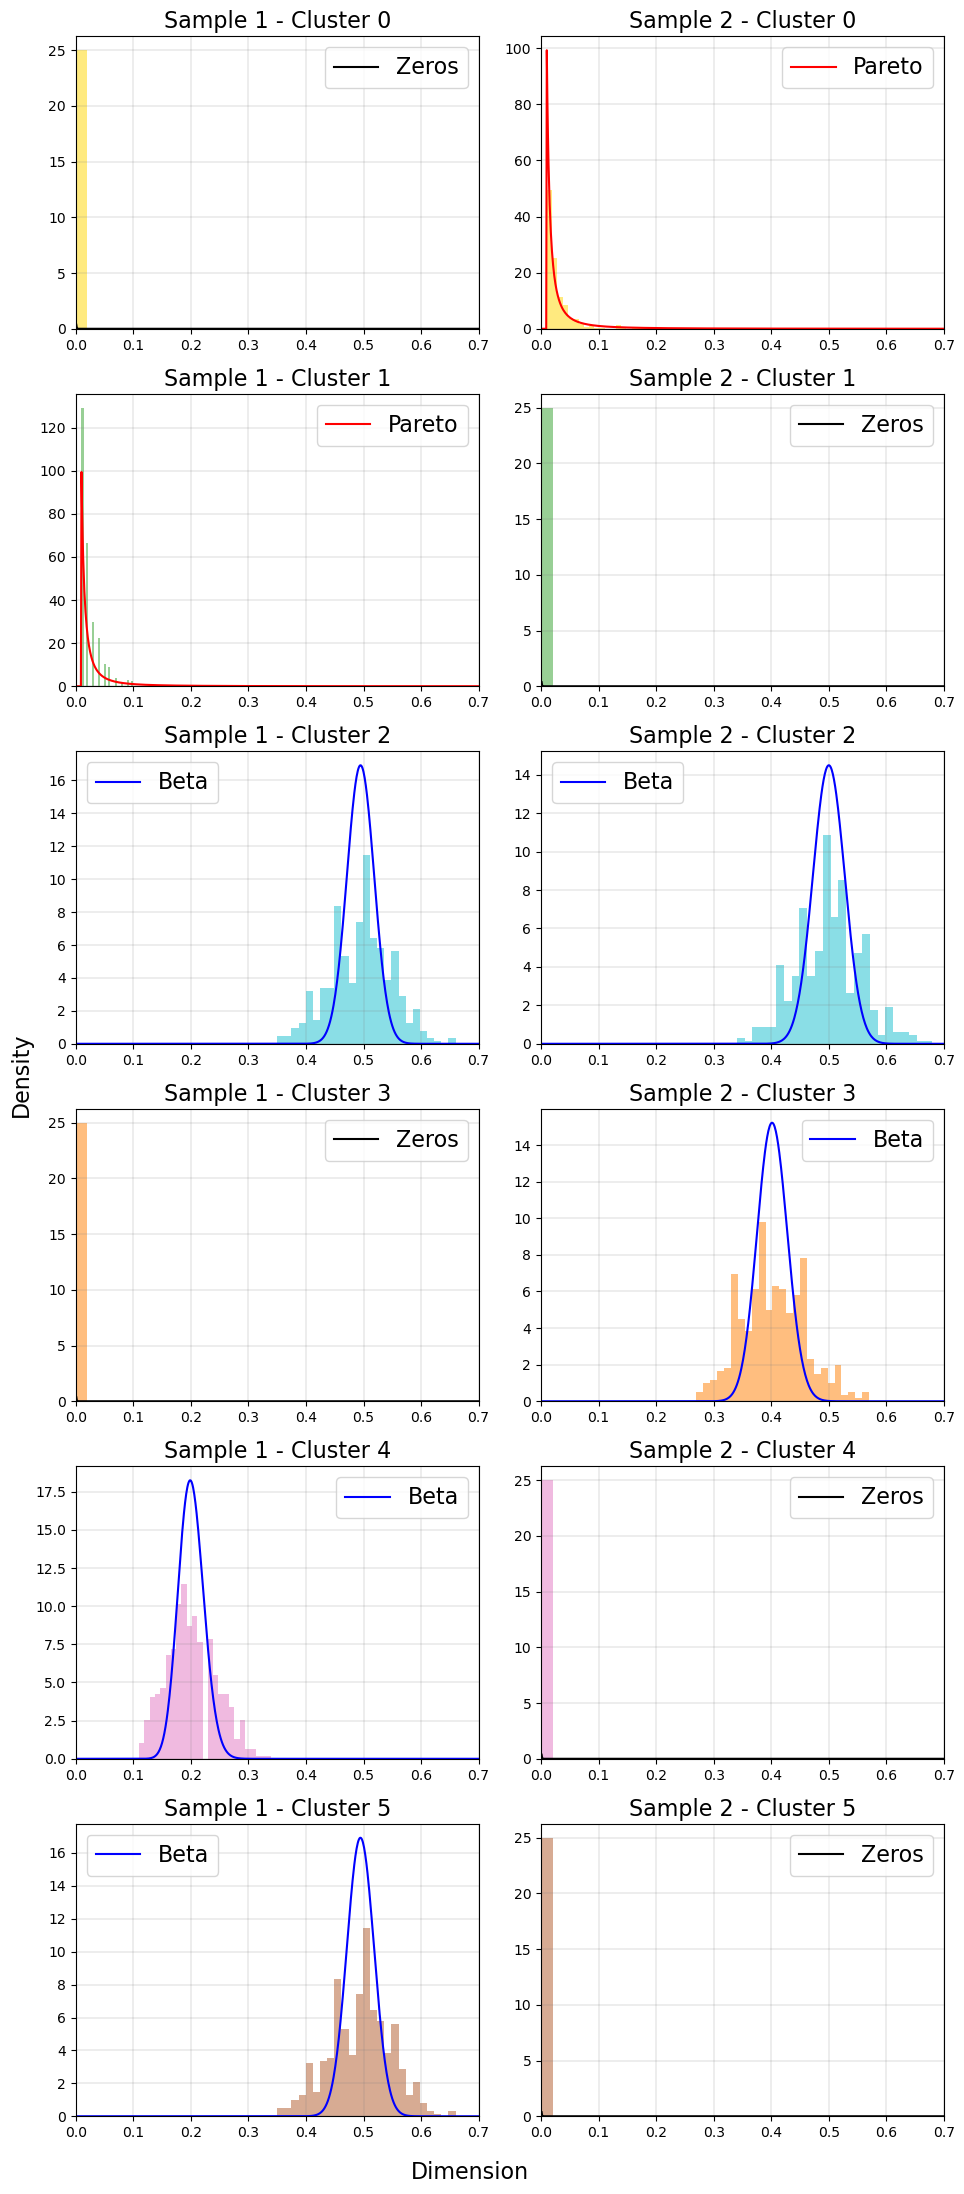

In [100]:
from scipy.stats import binom, beta, pareto

pareto_L = 0.01
x = np.linspace(0.001, 1, 1000)
fig, axes = plt.subplots(mb.K, NV.shape[1], figsize=(10, mb.K*4))

phi_beta = mb.params['phi_beta_param'].detach().numpy()
kappa_beta = mb.params['k_beta_param'].detach().numpy()
alpha = mb.params['alpha_pareto_param'].detach().numpy()
delta = mb.params['delta_param']

for k in range(mb.K):
    for d in range(mb.NV.shape[1]):
        delta_kd = delta[k, d]
        maxx = torch.argmax(delta_kd)
        if maxx == 1:
            # plot beta
            a = phi_beta[k,d] * kappa_beta[k,d]
            b = (1-phi_beta[k,d]) * kappa_beta[k,d]
            pdf = beta.pdf(x, a, b)# * weights[k]
            # axes[k,d].plot(x, pdf, linewidth=1.5, label='Beta', color=colors[k])
            axes[k,d].plot(x, pdf, linewidth=1.5, label='Beta', color='b')
            axes[k,d].legend()
        elif maxx == 0:
            #plot pareto
            pdf = pareto.pdf(x, alpha[k,d], scale=mb.pareto_L) #* weights[k]
            # axes[k,d].plot(x, pdf, linewidth=1.5, label='Pareto', color=colors[k])
            axes[k,d].plot(x, pdf, linewidth=1.5, label='Pareto', color='r')
            axes[k,d].legend()
        else:
            # print("Dirac")
            pdf = beta.pdf(x, mb.a_beta_zeros, mb.b_beta_zeros) # delta_approx
            # axes[k,d].plot(x, pdf, linewidth=1.5, label='Zeros', color=colors[k])
            axes[k,d].plot(x, pdf, linewidth=1.5, label='Zeros', color='black')
            axes[k,d].legend()

        data = mb.NV[:,d].numpy()/mb.DP[:,d].numpy()
        # for i in np.unique(labels):
        # axes[k,d].hist(data[labels == k], density=True, bins=30, alpha=0.5)#, color=cmap(i))
        axes[k,d].set_title(f"Sample {d+1} - Cluster {k}", fontsize = 16)
        plt.tight_layout()

        if torch.is_tensor(NV):
            data = NV[:, d].numpy() / DP[:, d].numpy()
        else:
            data = np.array(NV[:, d]) / np.array(DP[:, d])

        # Plot histogram
        axes[k, d].hist(data[labels == k], density=True, bins=25, 
                        alpha=0.5, color=colors[k])
        axes[k,d].grid(True, color='gray', linestyle='-', linewidth=0.2)
    
    
    # if k == 0:
    #     axes[k, d].set_title(f"Dimension {d}", fontsize=14)
    
        axes[k, d].legend(fontsize = 16)
        axes[k, d].set_xlim([0, 0.7])
        # axes[k, d].set_ylim([0, 15])

# Add global labels
fig.text(0.5, 0.04, 'Dimension', ha='center', fontsize=16)  # X label (bottom of plot)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=16)  # Y label (left side)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Adjust layout to make space for the labels
plt.show()


### Reconstructed rRACES longitudinal data 

In [19]:
N1 = 500
N2 = 500
N3 = 500
N4 = 500
N5 = 500
N6 = 500
seed = 123
# Component 1
alpha_pareto = 1.2
L_pareto = 0.01
H_pareto = 0.5
phi_beta = 0.5
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)


# Component 2
phi_beta_x = 0.5
k_beta_x = 150
phi_beta_y = 0.5
k_beta_y= 150
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.25
k_beta_x = 100
phi_beta_y = 1e-10
k_beta_y= 100
n3=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV3[:,1] = torch.tensor(0, dtype=NV3.dtype)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))


# Component 4
phi_beta_x = 1e-10
k_beta_x = 150
phi_beta_y = 0.25
k_beta_y= 150
n4=150
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n4, N=N4, seed=seed)
NV4[:,0] = torch.tensor(0, dtype=NV4.dtype)
NV = torch.concat((NV,NV4))
DP = torch.concat((DP,DP4))


# Component 5
alpha_pareto = 1.5
phi_beta = 1e-10
k_beta = 150
n5=150
NV5, DP5 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5,exchanged = False, seed = seed)
NV5[:,1] = torch.tensor(0, dtype=NV1.dtype)
NV = torch.concat((NV,NV5))
DP = torch.concat((DP,DP5))
print(NV.shape)
print(DP.shape)


# Component 6
alpha_pareto = 1.5
phi_beta = 1e-10
k_beta = 150
n6=150
NV6, DP6 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n5, N=N5, exchanged = True, seed = seed)
NV6[:,0] = torch.tensor(0, dtype=NV6.dtype)
NV = torch.concat((NV,NV6))
DP = torch.concat((DP,DP6))

torch.Size([2500, 2])
torch.Size([2500, 2])


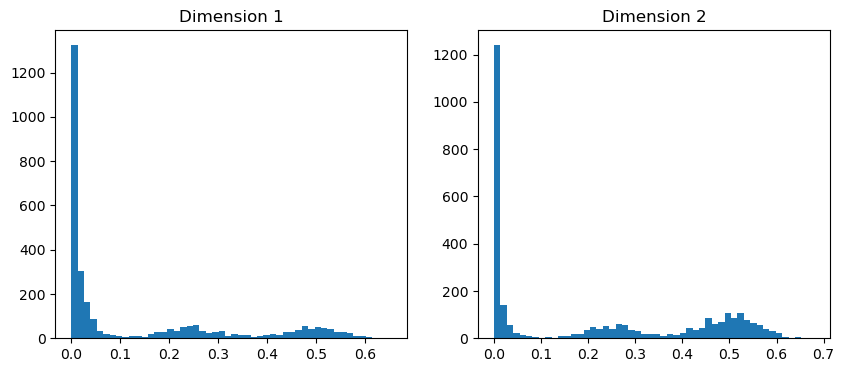

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [20]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N4)*3
labels = np.concatenate((labels, labels_4))
labels_5 = np.ones(N5)*4
labels = np.concatenate((labels, labels_5))
labels_6 = np.ones(N6)*5
labels = np.concatenate((labels, labels_6))

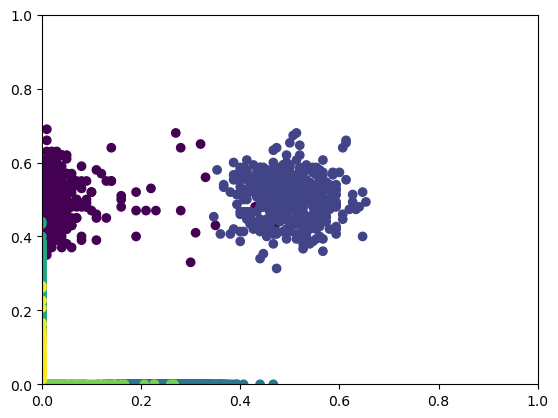

In [21]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

No GPU available.
RUN WITH K = 7 AND SEED = 41
Minimum detected VAF: tensor(0.0300)


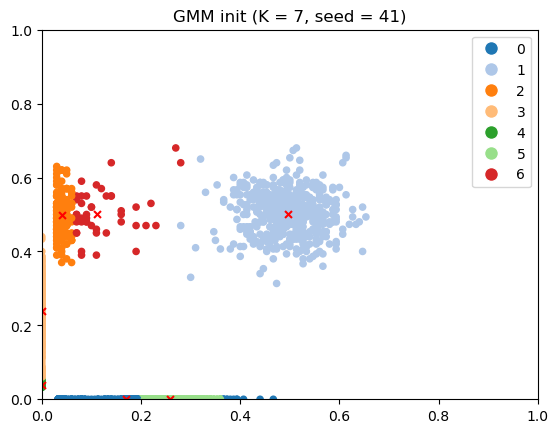

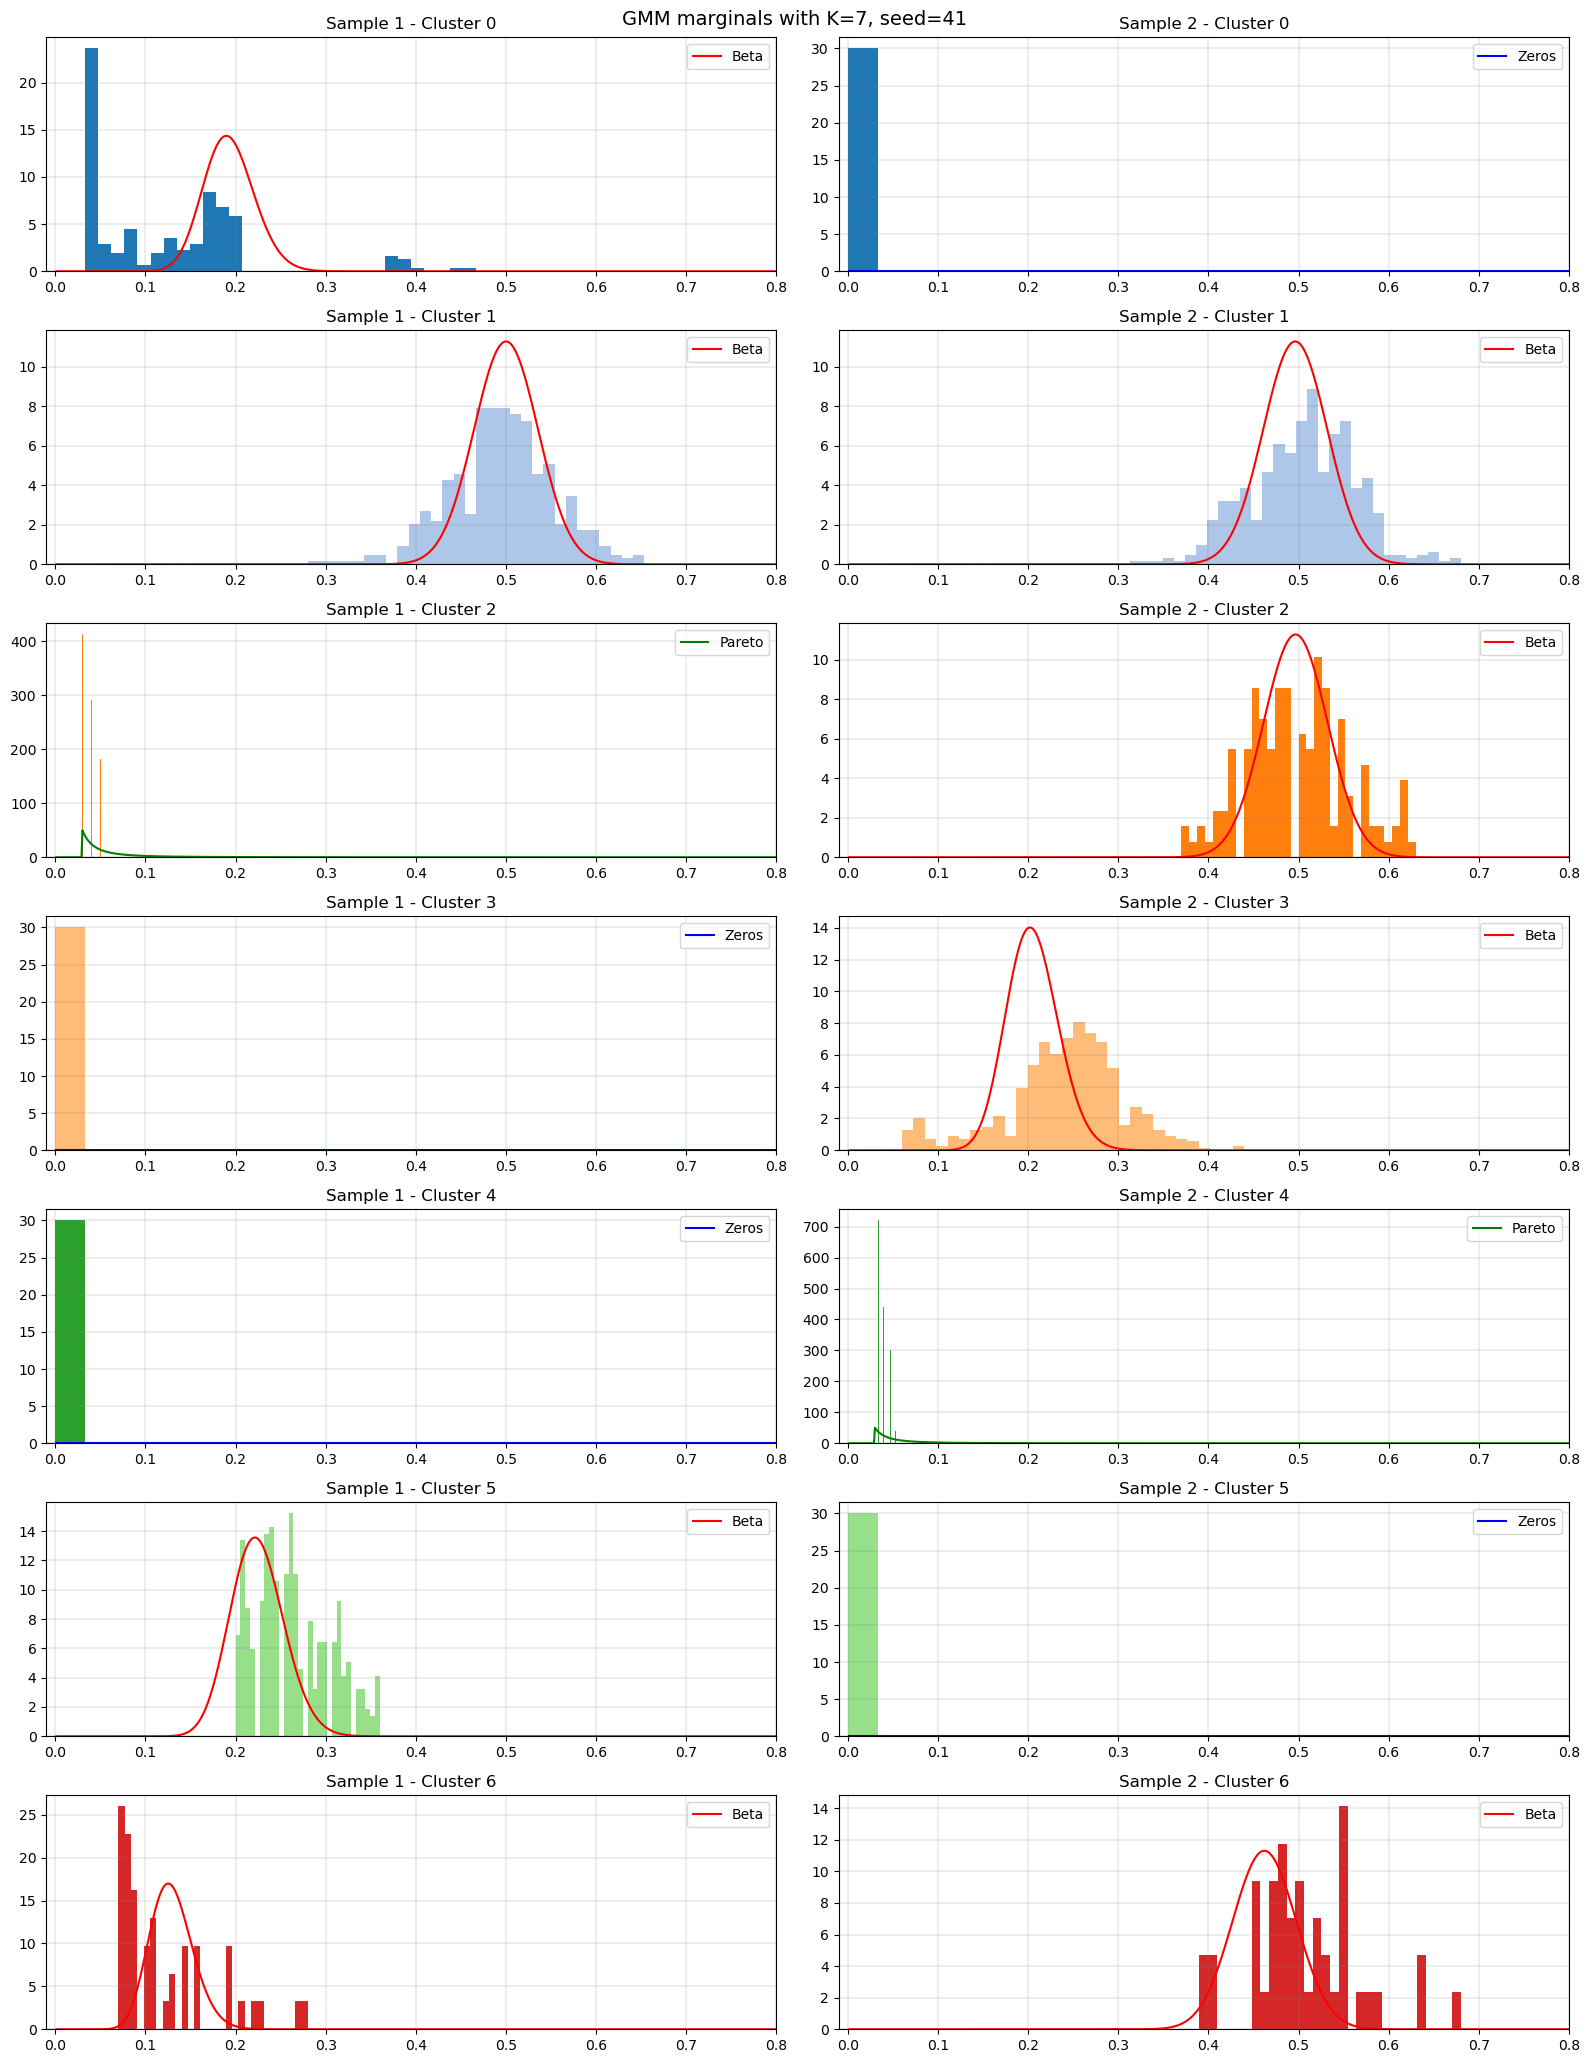

Iteration 0: Loss = 26048717.68585752
Iteration 50: Loss = 23743609.74751532
Iteration 100: Loss = 23424269.771826796
Iteration 150: Loss = 23341878.62950629
Iteration 200: Loss = 23299964.012617692
Iteration 250: Loss = 23282174.994921044
Iteration 300: Loss = 23272298.14034026
Iteration 350: Loss = 23267920.44152015
Iteration 400: Loss = 23265760.585910883
Iteration 450: Loss = 23264307.550840482


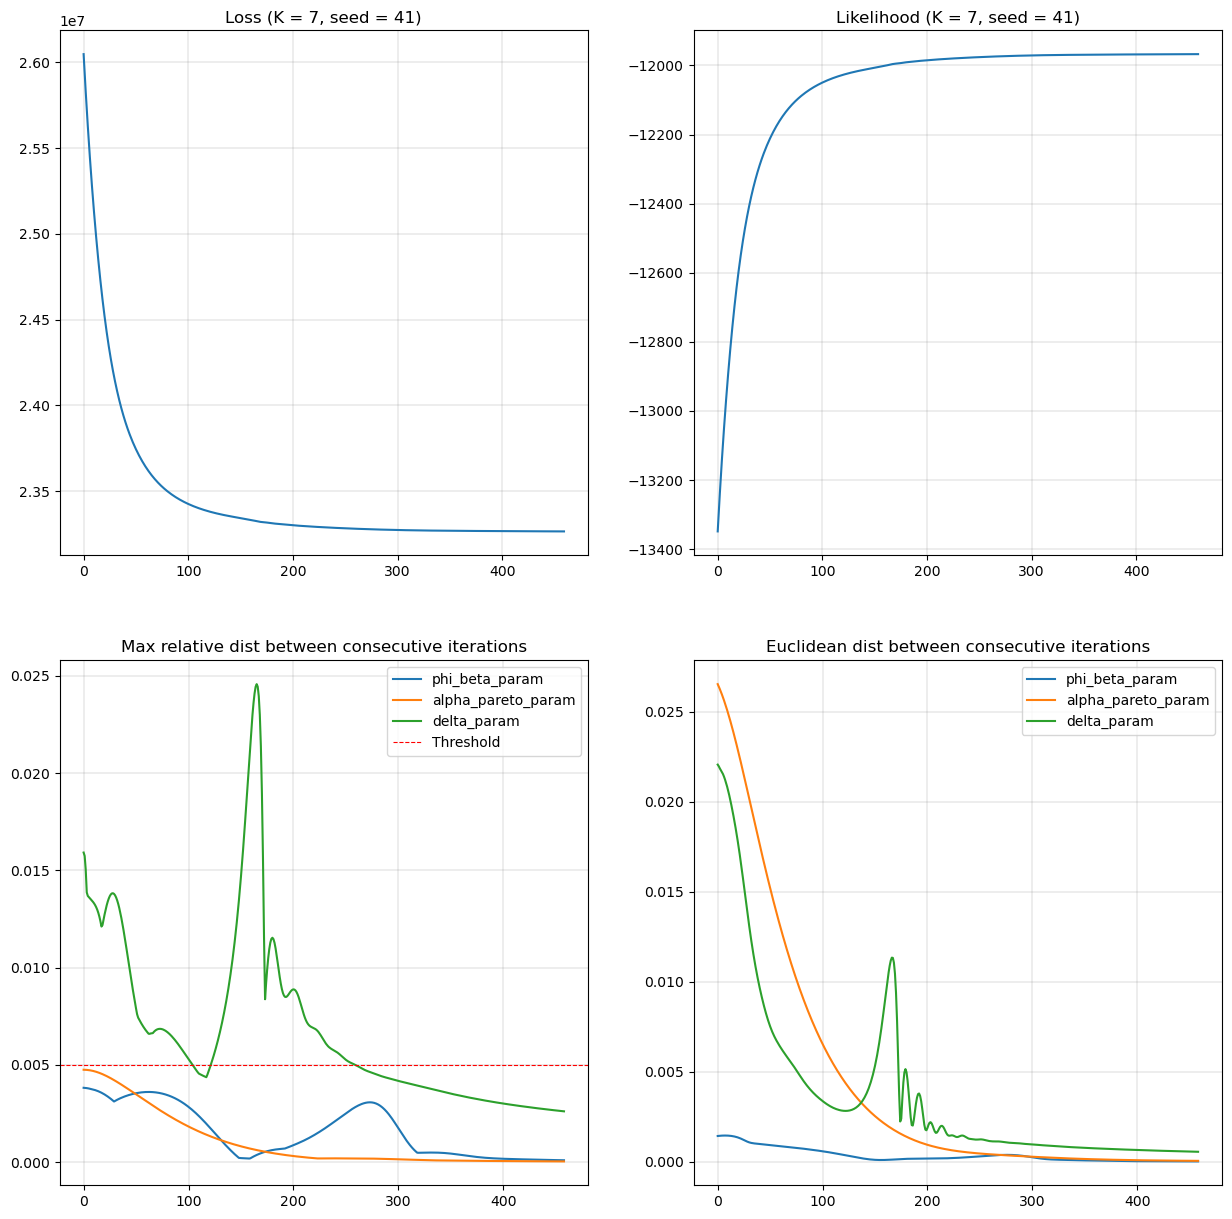

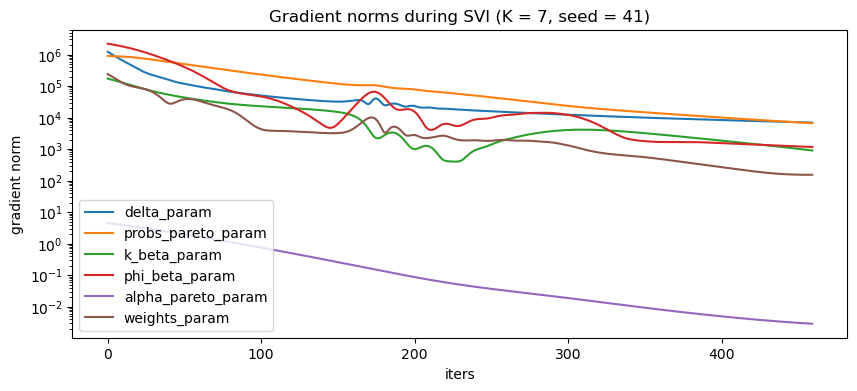

Inference lk:  -11967.25277937457
Final lk (integr):  tensor(-12789.8721, grad_fn=<SumBackward0>)
n_params:  105
n:  tensor(1943)
lk:  tensor(-12789.8721, grad_fn=<SumBackward0>)
bic: 26374.802734375 



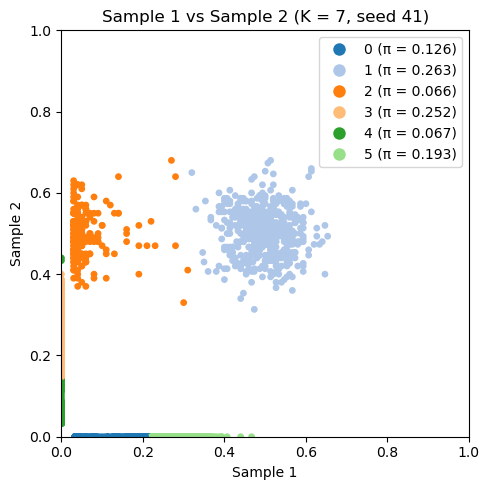

Time taken for K = 7 and seed = 41: 8.539 seconds


/Users/elenarivaroli/miniconda3/envs/mobster/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


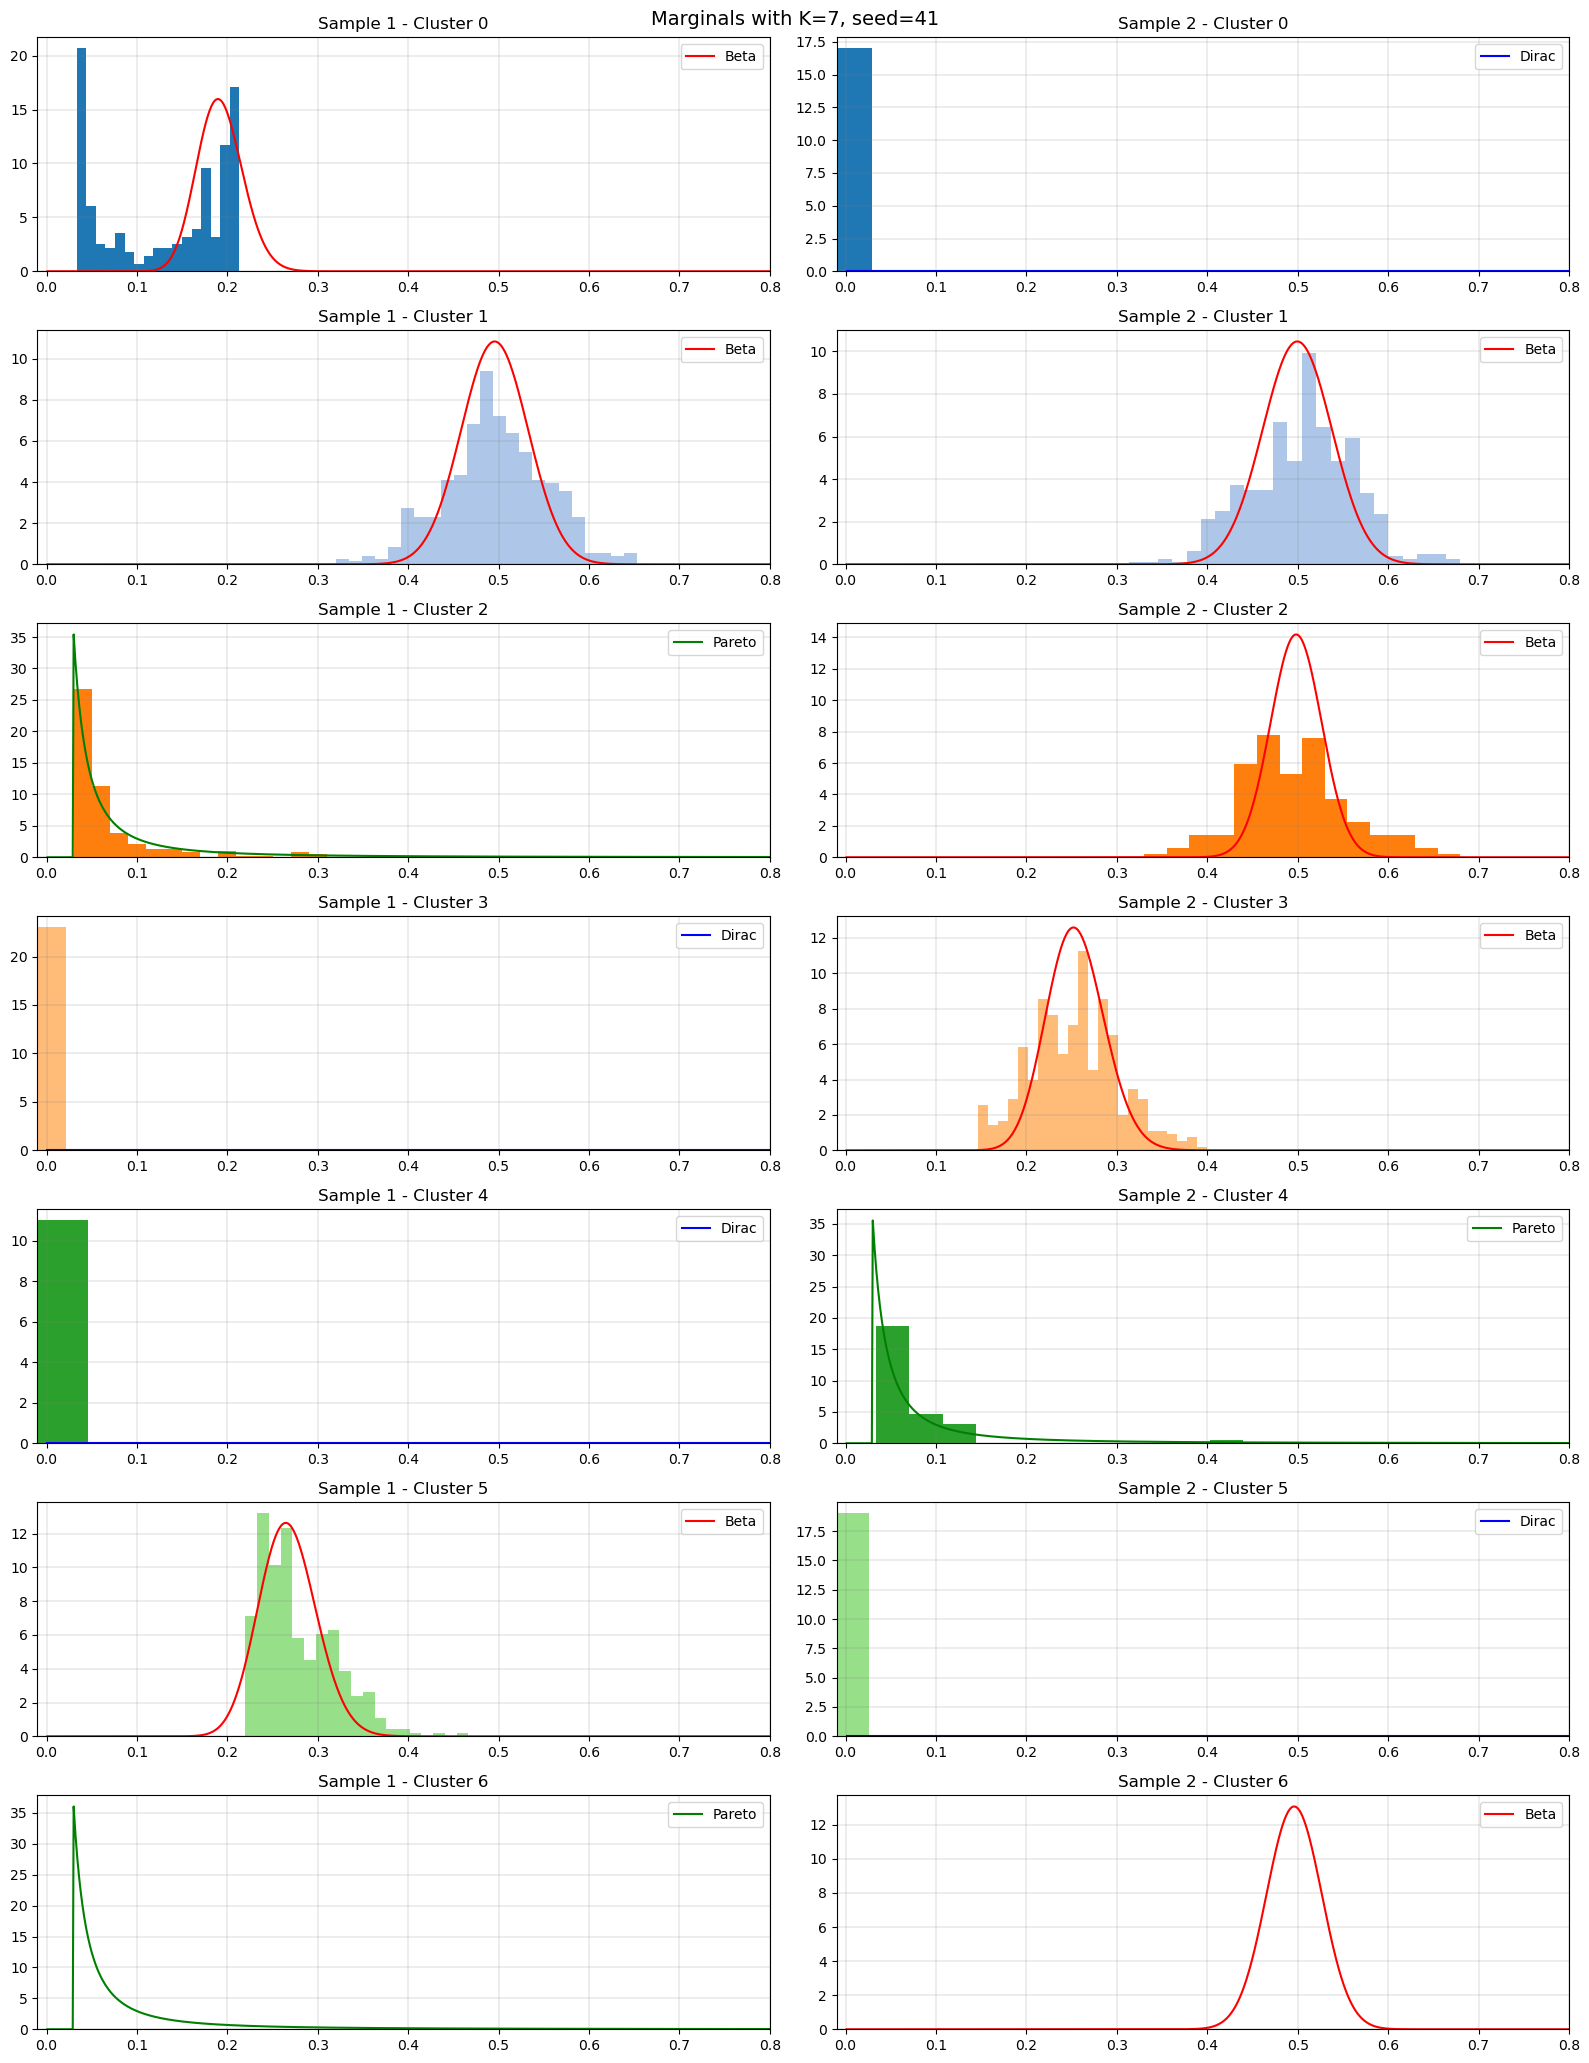

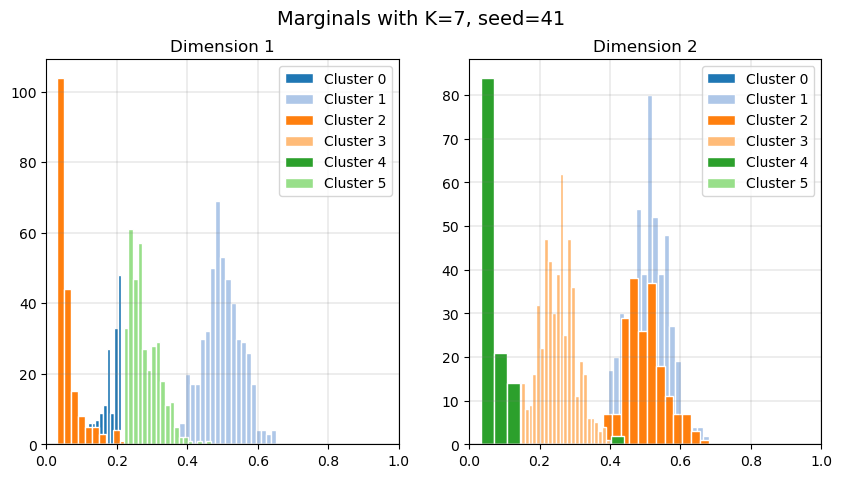

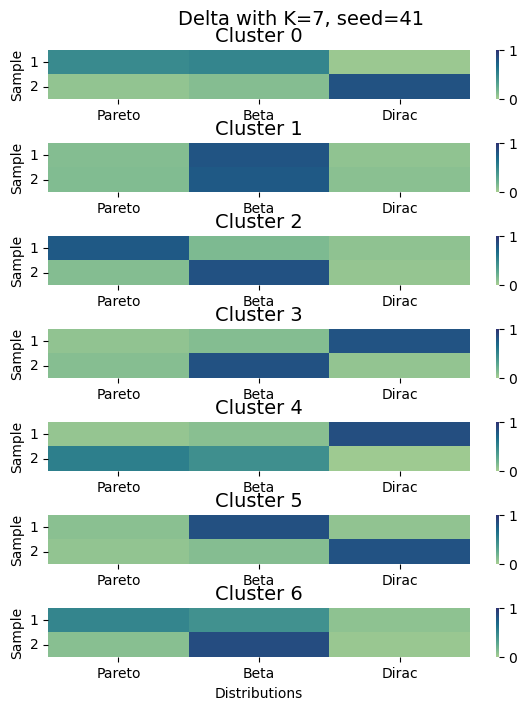

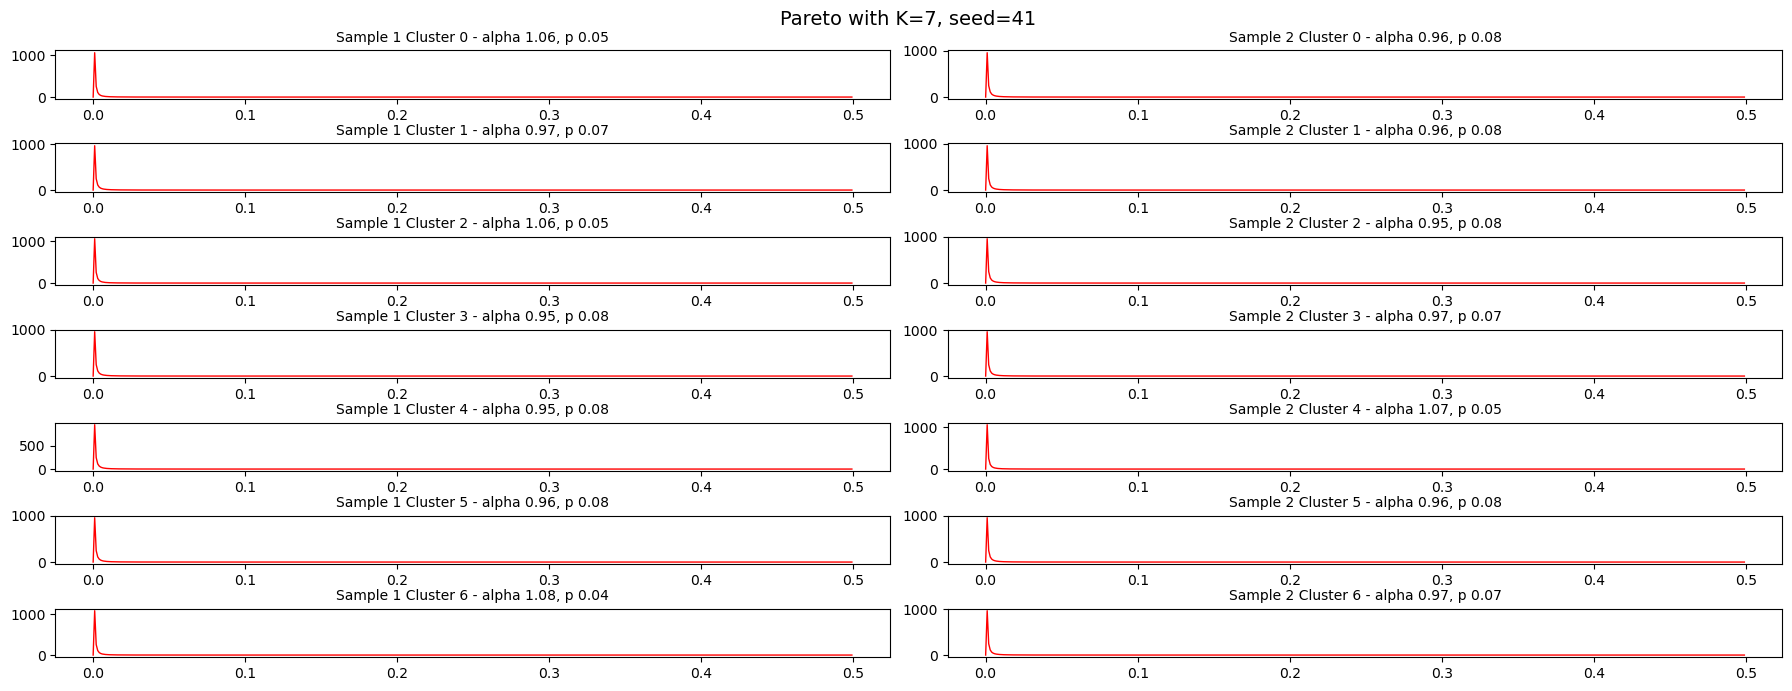

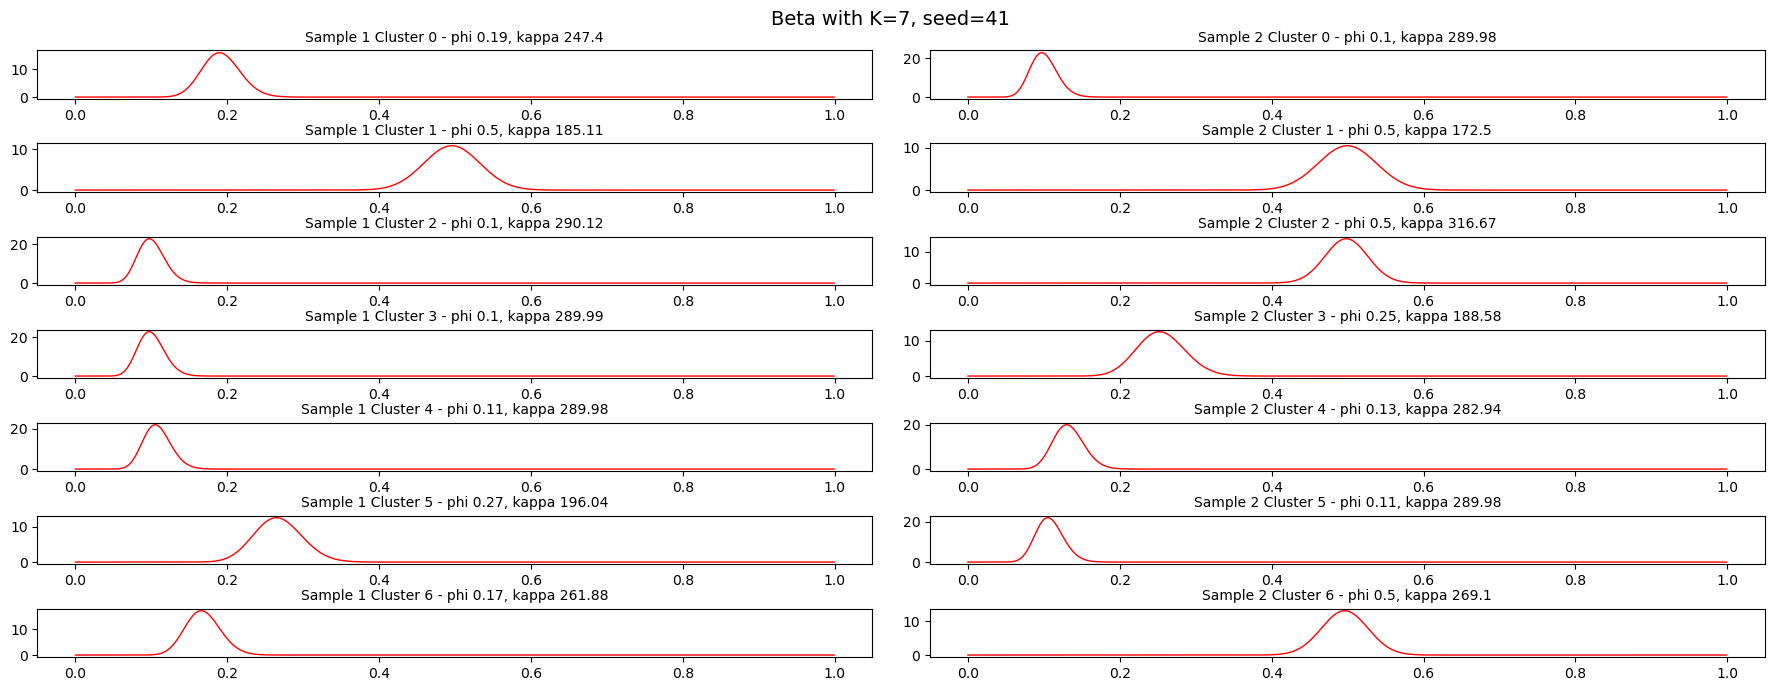

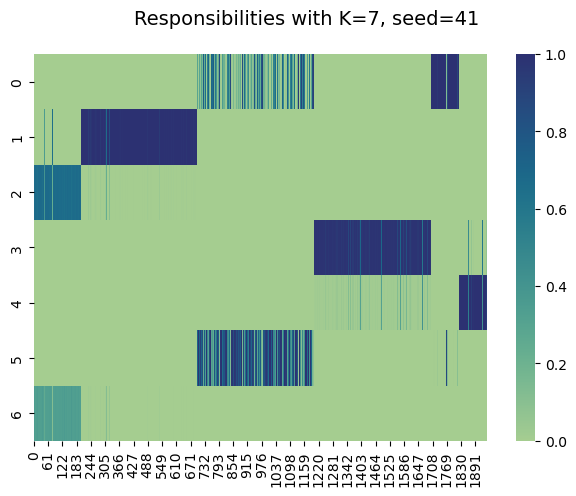

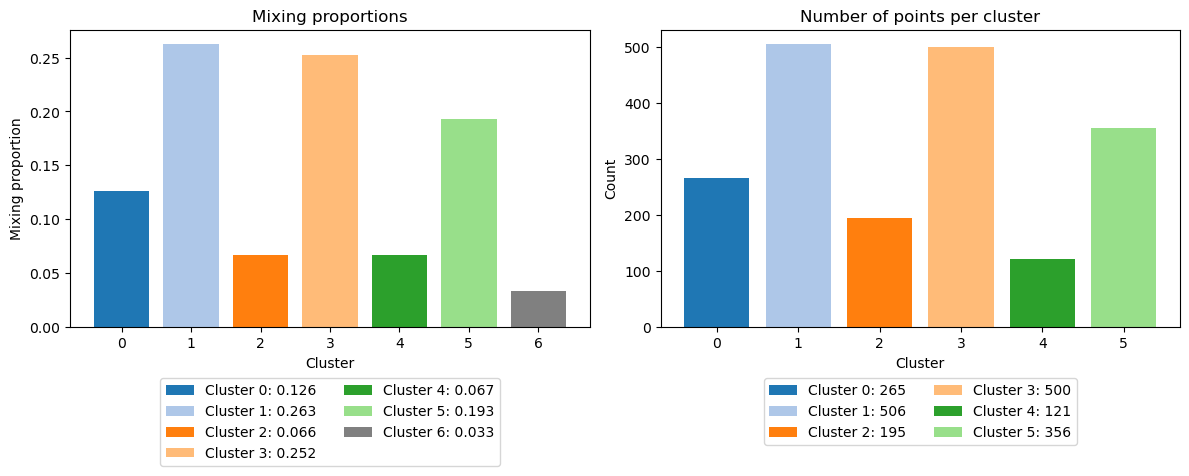

Selected number of clusters is 7 with seed 41


In [22]:
K_list = [7]
seed_list = [41]
mb_list, best_K, best_seed = model_mobster_mv.fit(NV, DP, num_iter = 2000, K = K_list, seed = seed_list, lr = 0.01)

### rRACES data

In [23]:
NV_r = pd.read_csv("./rRACES_data/NV2.csv")
DP_r = pd.read_csv("./rRACES_data/DP2.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

FileNotFoundError: [Errno 2] No such file or directory: './rRACES_data/NV2.csv'

In [7]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0097)
tensor(0.0092)


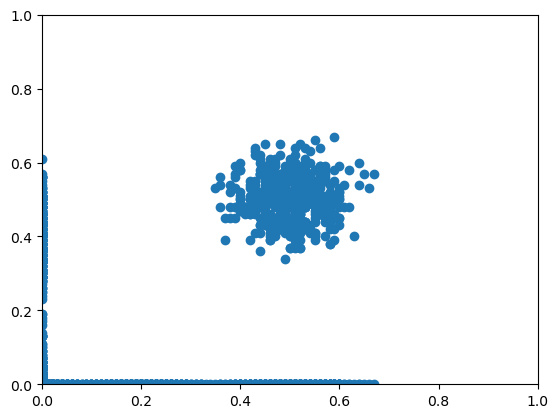

In [12]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

In [13]:
torch.sum((NV[:,0] == 0) & (NV[:,1]/DP[:,1] < 0.18))

tensor(585)

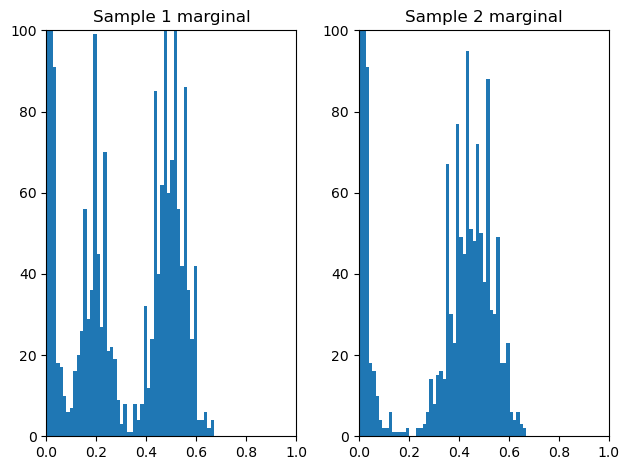

In [14]:
# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[4.9860e-01, 5.0390e-01],
        [1.0810e-02, 1.2115e-02],
        [4.9878e-01, 1.6391e-07],
        [7.1526e-07, 4.0264e-01],
        [2.0169e-01, 1.0000e-03]])
Cluster Sizes: [500 988 500 503 509]
Cluster Sizes Vector: [0.16666667 0.32933333 0.16666667 0.16766667 0.16966667]
Cluster variances [[ 151.07040603  151.07040603]
 [1137.16010595 1137.16010595]
 [ 328.74064707  328.74064707]
 [ 260.1387847   260.1387847 ]
 [ 478.76734762  478.76734762]]


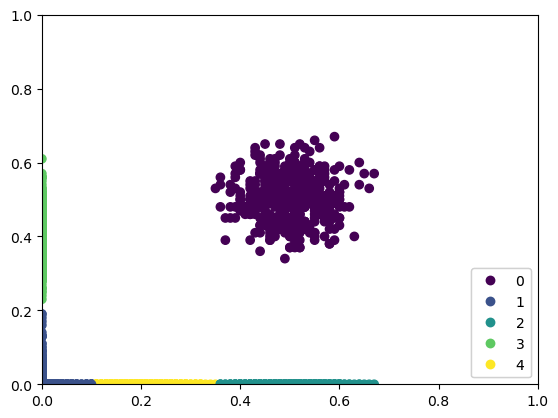

In [ ]:
from sklearn.cluster import KMeans
K = 5
kmeans = KMeans(n_clusters=K, random_state=123, n_init=2).fit((NV/DP).numpy())
labels = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

plt.xlim([0,1])
plt.ylim([0,1])
sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)
legend1 = plt.legend(*sc.legend_elements(), loc="lower right")
plt.gca().add_artist(legend1)

# print(labels.astype(int))
# Compute cluster sizes
cluster_sizes = np.bincount(labels.astype(int), minlength=K)
print("Cluster Sizes:", cluster_sizes)

# Convert to a 1D vector
cluster_sizes_vector = cluster_sizes.reshape(-1)/np.sum(cluster_sizes.reshape(-1))
print("Cluster Sizes Vector:", cluster_sizes_vector)

centroids = kmeans.cluster_centers_
variances = []
for i in range(kmeans.n_clusters):
    vaf = NV/DP
    points_in_cluster = vaf[labels == i]
    
    # Get the centroid of the current cluster
    centroid = centroids[i]

    # Calculate the squared distances of points to the centroid
    distances = np.linalg.norm(points_in_cluster - centroid, axis=1) ** 2

    # Compute the variance (mean of squared distances)
    cluster_variance = np.mean(distances)
    variances.append(cluster_variance)

kappas = [1 / variance if variance > 0 else np.inf for variance in variances]
kappas = np.tile(kappas, (NV.shape[1], 1)).T
print("Cluster variances", kappas)

No GPU available. Training will run on CPU.
RUN WITH K = 5 AND SEED = 41
Minimum detected VAF: tensor(0.0100)
tensor([[[0.0422, 0.8085, 0.1492],
         [0.3199, 0.0801, 0.5999]],

        [[0.3487, 0.0128, 0.6385],
         [0.2294, 0.0761, 0.6945]],

        [[0.8369, 0.1334, 0.0297],
         [0.1824, 0.7358, 0.0819]],

        [[0.2208, 0.7215, 0.0577],
         [0.3092, 0.0881, 0.6027]],

        [[0.1755, 0.6874, 0.1371],
         [0.0197, 0.4465, 0.5337]]], grad_fn=<DivBackward0>)
tensor([[[0.0429, 0.8054, 0.1517],
         [0.3238, 0.0811, 0.5951]],

        [[0.3532, 0.0129, 0.6339],
         [0.2326, 0.0772, 0.6902]],

        [[0.8341, 0.1357, 0.0302],
         [0.1851, 0.7319, 0.0831]],

        [[0.2240, 0.7174, 0.0586],
         [0.3129, 0.0892, 0.5979]],

        [[0.1779, 0.6831, 0.1390],
         [0.0201, 0.4464, 0.5335]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 4051002.064599037
tensor([[[0.0436, 0.8023, 0.1541],
         [0.3276, 0.0820, 0.5903]],

        [[0.

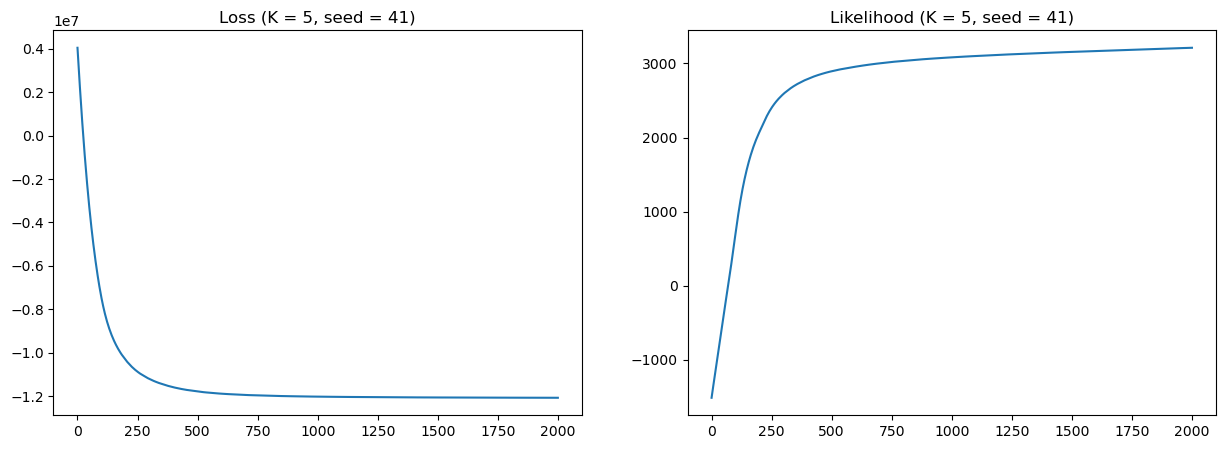

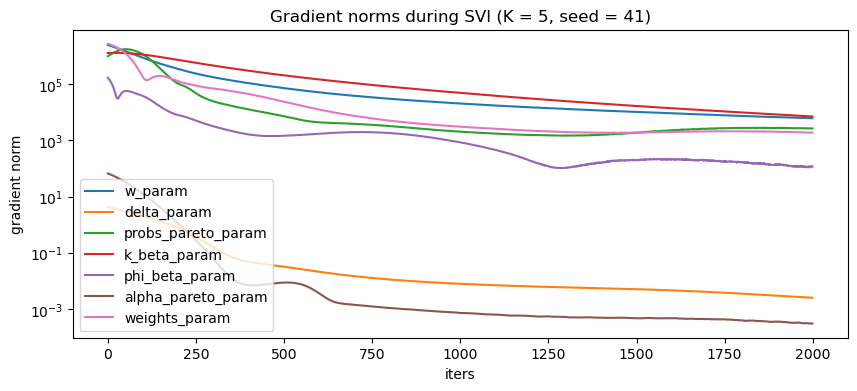

Inference lk:  3210.4958
Final lk (integr):  tensor(-1.1695e+08, grad_fn=<SumBackward0>)
INTEGR: 
n_params:  105
n:  tensor(3000)
lk:  tensor(-1.1695e+08, grad_fn=<SumBackward0>)
bic: 233902976.0 

Weights:  [0.15340945 0.31924124 0.34015438 0.01496132 0.1722336 ]


c:\Users\Administrator\Documents\Università\Tesi magistrale\subclonal_deconvolution_mv\new_model.py:742: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(NV_S1/DP_S1, NV_S2/DP_S2, c=colors, cmap = 'Set3') # tab10


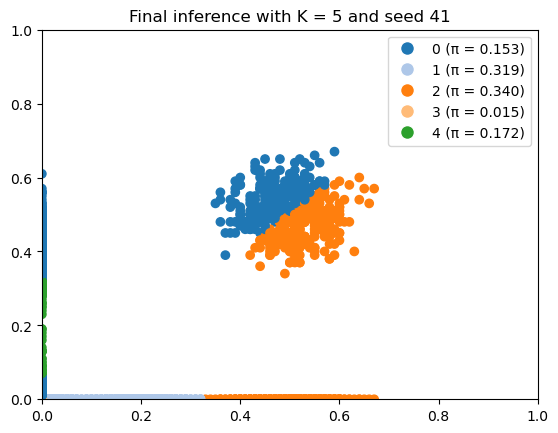

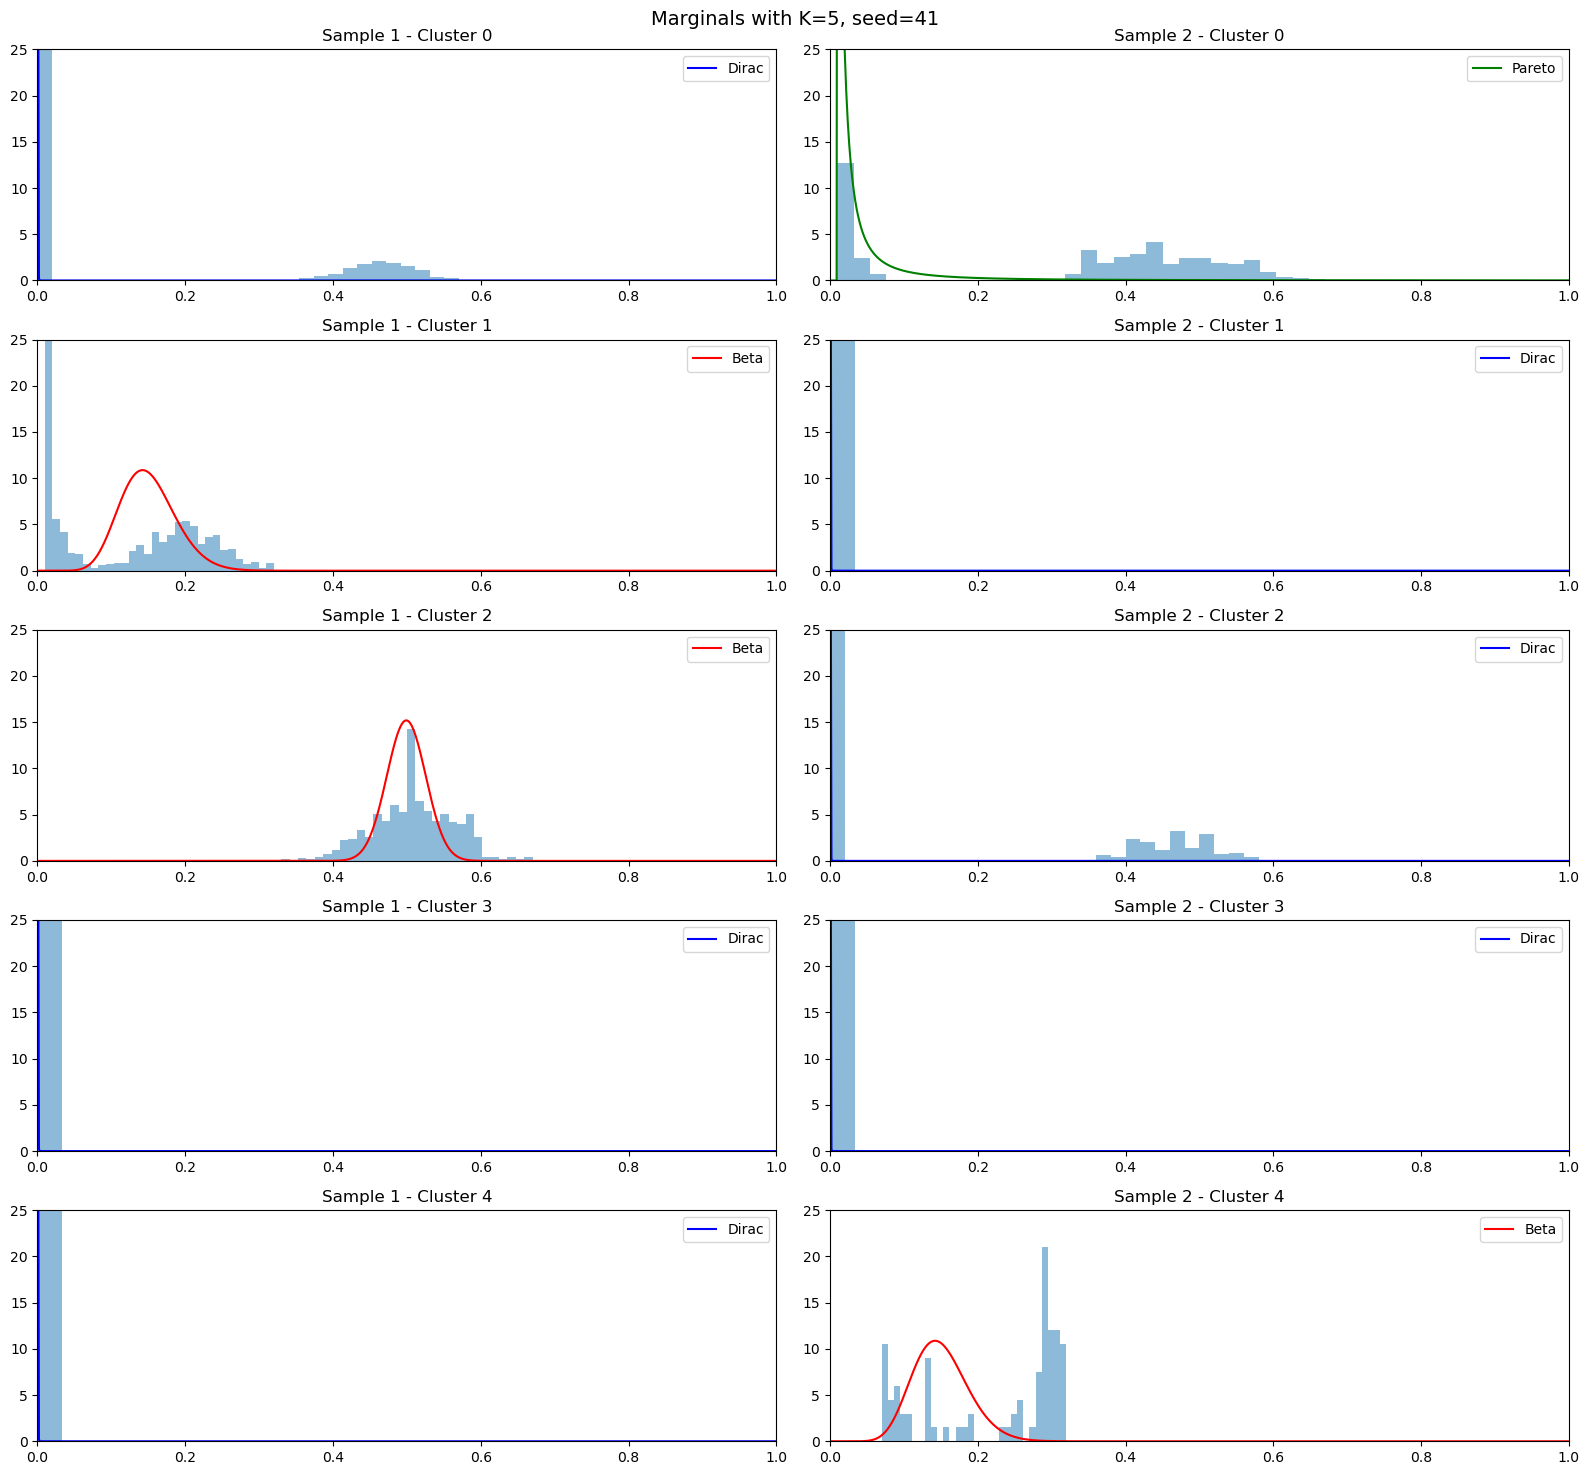

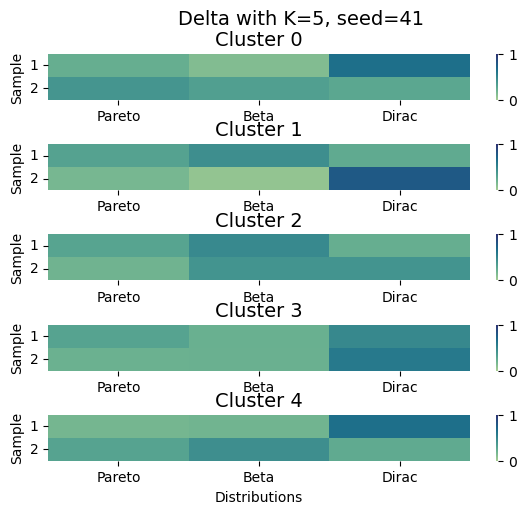

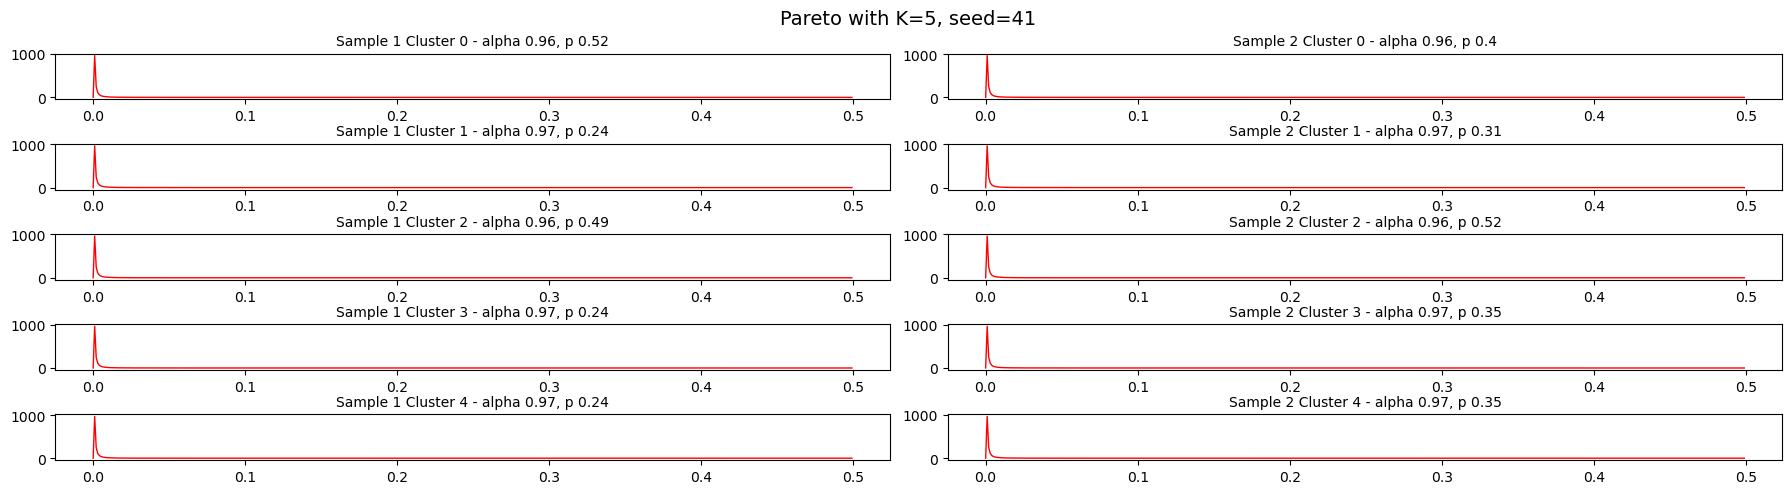

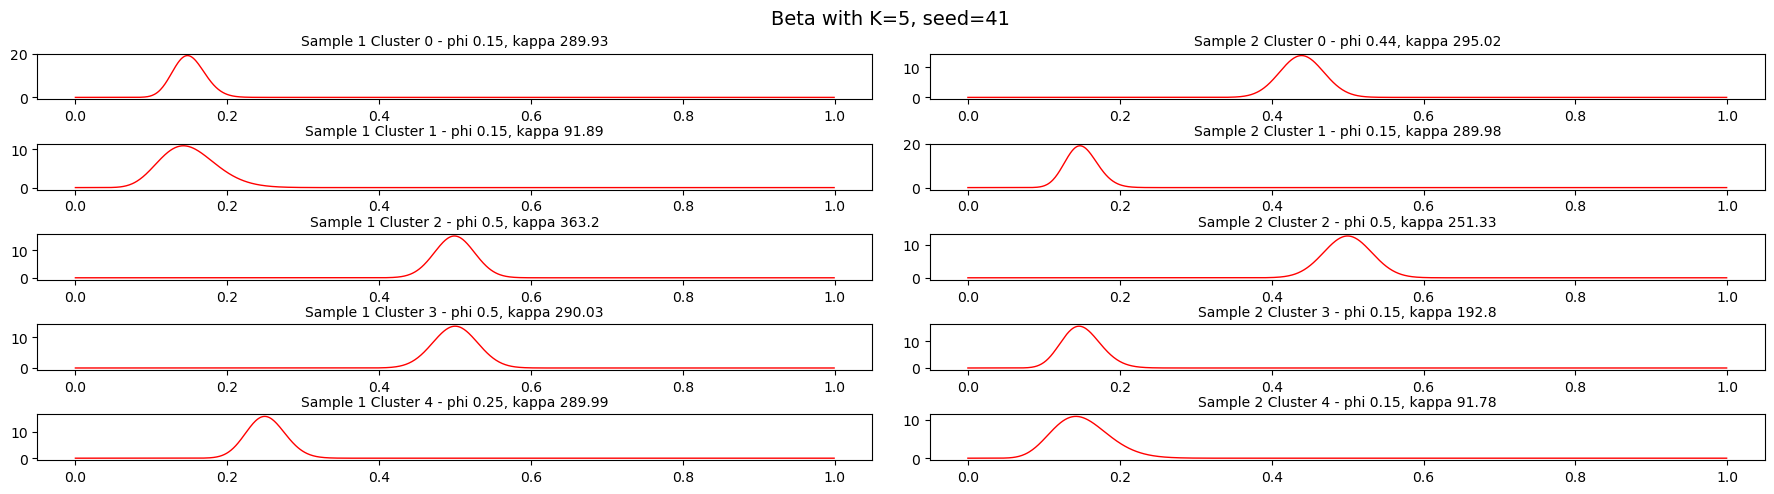

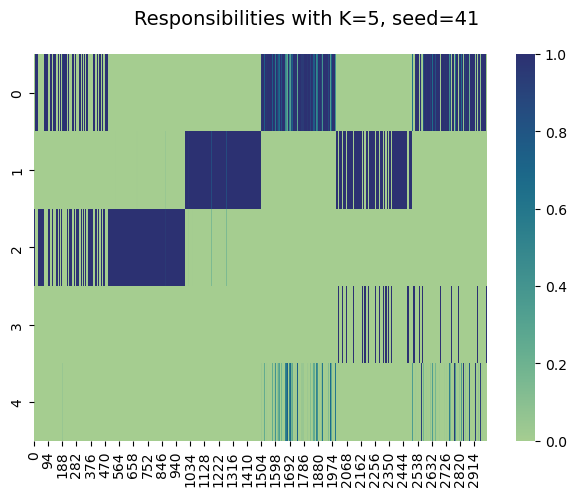

Selected number of clusters is 5 with seed 41


In [16]:
K_list = [5]
seed_list = [41]
mb_list, best_K, best_seed = model_mobster_mv.fit(NV, DP, num_iter = 2000, K = K_list, seed = seed_list, lr = 0.01)

In [18]:
NV[np.where(mb_list[0].params['cluster_assignments'] == 3)]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

### rRACES longitudinal data

In [3]:
NV_r = pd.read_csv("./rRACES_data/NV_long.csv")
DP_r = pd.read_csv("./rRACES_data/DP_long.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([1224, 2])
torch.Size([1224, 2])


In [4]:
torch.sum((NV[:,0]/DP[:,0] < 0.15) & (NV[:,0]/DP[:,0] > 0.))

tensor(424)

In [5]:
# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,0]/DP[:,0]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

# Replace zeros with a large value that will not be considered as minimum
vaf = NV[:,1]/DP[:,1]
copy_vaf = torch.clone(vaf)
masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

# Find the minimum value excluding zeros
min_value = torch.min(masked_tensor)
print(min_value)

tensor(0.0094)
tensor(0.0095)


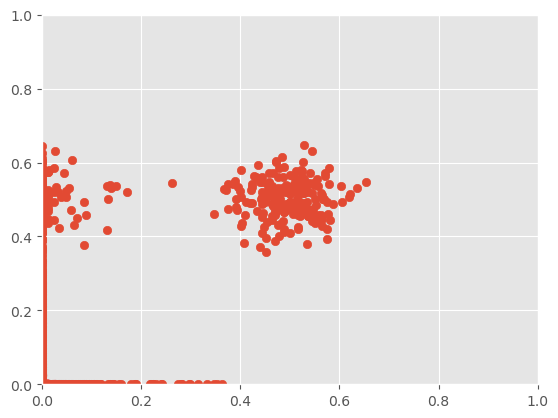

In [6]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

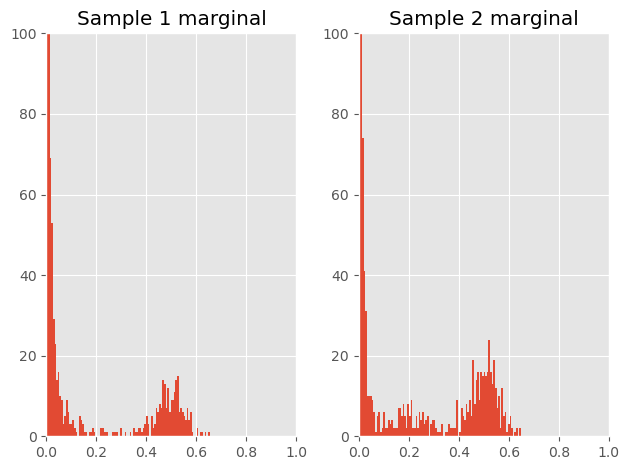

In [7]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 100)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 100)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[1.4442e-02, 1.1785e-02],
        [4.9358e-01, 5.0280e-01],
        [1.6109e-02, 4.9525e-01],
        [2.2913e-01, 1.4901e-08],
        [1.4901e-08, 2.1557e-01]])


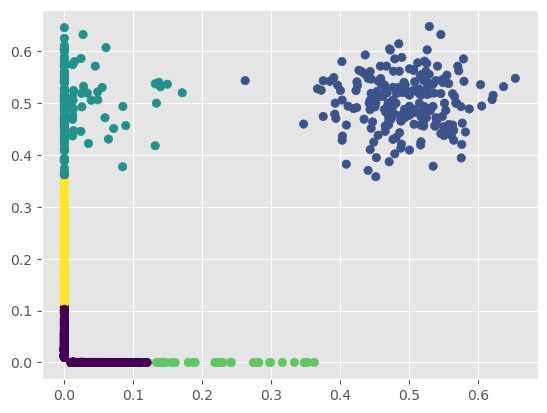

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

RUN WITH K = 5 AND SEED = 40
NV = 0 before: tensor(965)
NV = 0 after: tensor(965)
delta_param tensor([[[0.3992, 0.6008],
         [0.4028, 0.5972]],

        [[0.6042, 0.3958],
         [0.4042, 0.5958]],

        [[0.4043, 0.5957],
         [0.4042, 0.5958]],

        [[0.3960, 0.6040],
         [0.4044, 0.5956]],

        [[0.3960, 0.6040],
         [0.6040, 0.3960]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 9667181.218276024
Iteration 200: Loss = 8378602.860245705
Iteration 400: Loss = 8563805.271439552
Iteration 600: Loss = 8667509.96601963
Iteration 800: Loss = 7767619.638627052
Iteration 1000: Loss = 8016712.499466896
Iteration 1200: Loss = 8537165.956009865
Iteration 1400: Loss = 7348366.254349709
Iteration 1600: Loss = 7793398.791947365
Iteration 1800: Loss = 8820129.803177834
Iteration 2000: Loss = 8378946.28218174
Iteration 2200: Loss = 7546939.73921299
Iteration 2400: Loss = 8502245.992142677
Iteration 2600: Loss = 10284397.900345802
Iteration 2800: Loss = 7609825.866166

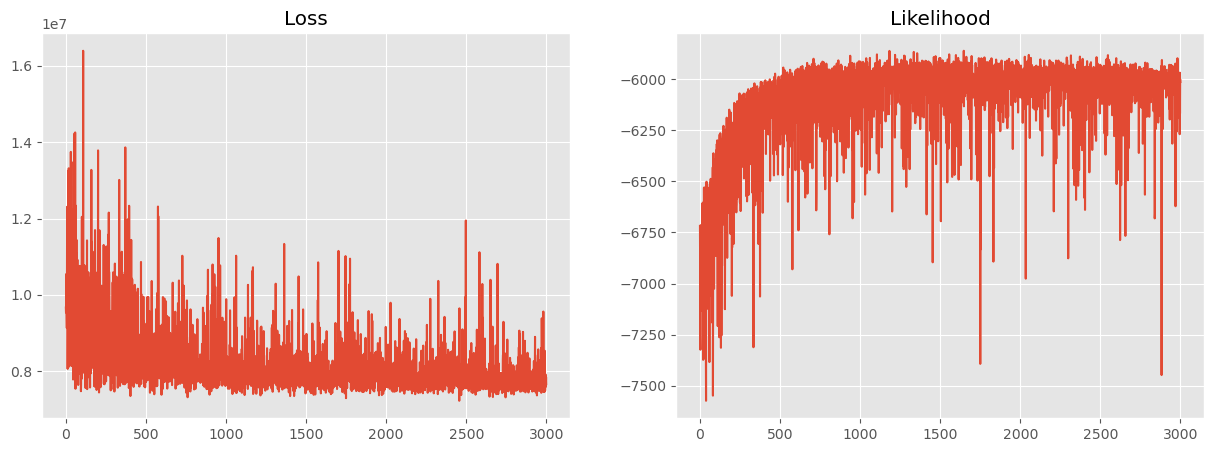

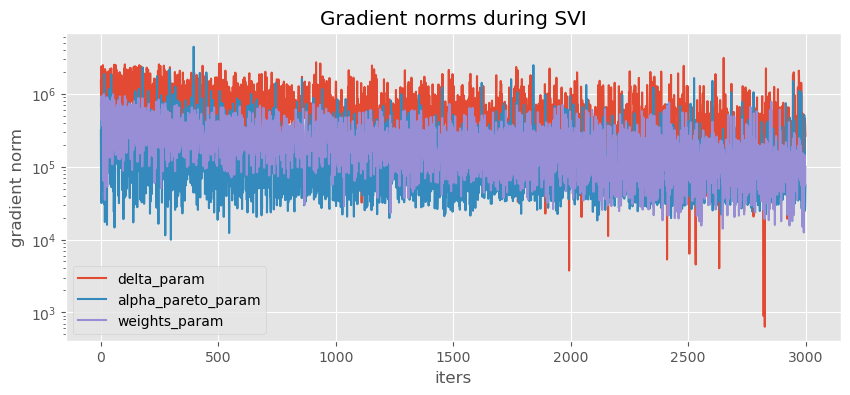

bic:  tensor(64942.1406, grad_fn=<RsubBackward1>)


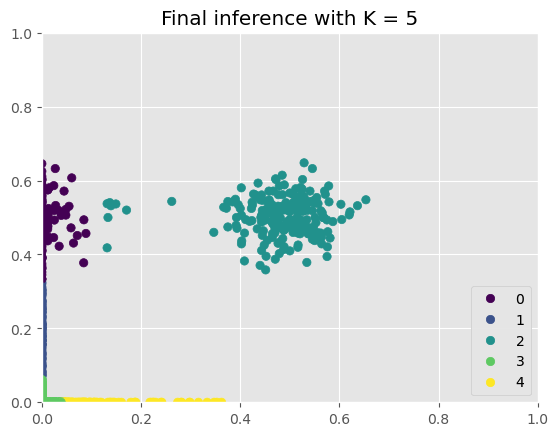

RUN WITH K = 5 AND SEED = 41
NV = 0 before: tensor(965)
NV = 0 after: tensor(965)
delta_param tensor([[[0.4040, 0.5960],
         [0.4040, 0.5960]],

        [[0.6042, 0.3958],
         [0.4006, 0.5994]],

        [[0.4026, 0.5974],
         [0.3960, 0.6040]],

        [[0.4042, 0.5958],
         [0.4042, 0.5958]],

        [[0.4043, 0.5957],
         [0.6042, 0.3958]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 11033636.230294228
Iteration 200: Loss = 10974478.94221592
Iteration 400: Loss = 9634997.9427042
Iteration 600: Loss = 8265647.926468849
Iteration 800: Loss = 7773214.20405674
Iteration 1000: Loss = 7816185.073197365
Iteration 1200: Loss = 7957319.63374424
Iteration 1400: Loss = 8803613.581986427
Iteration 1600: Loss = 7789709.794388771
Iteration 1800: Loss = 7510386.583939552
Iteration 2000: Loss = 7998164.67280674
Iteration 2200: Loss = 7841934.515091896
Iteration 2400: Loss = 7875140.988724709
Iteration 2600: Loss = 8569658.366654396
Iteration 2800: Loss = 7596627.97456455

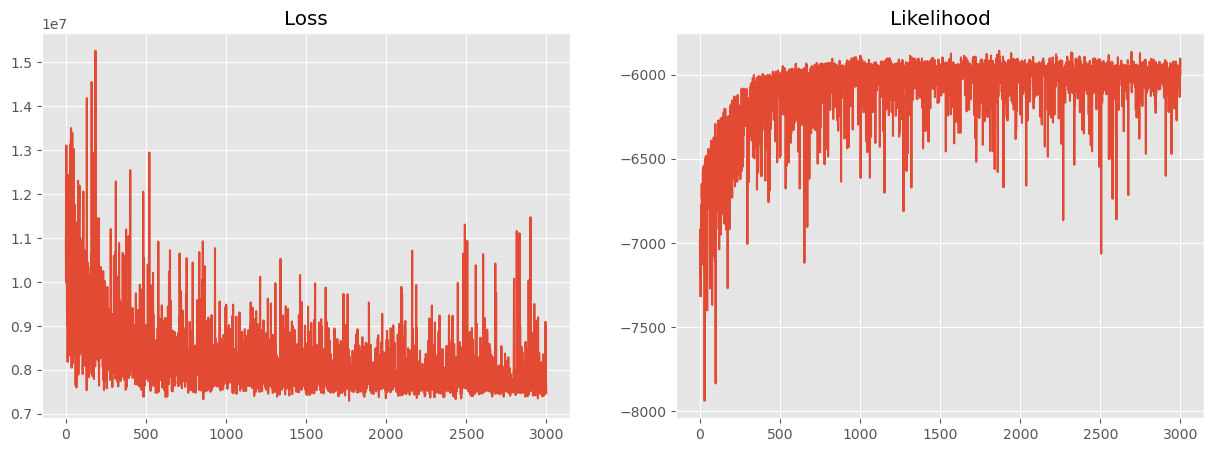

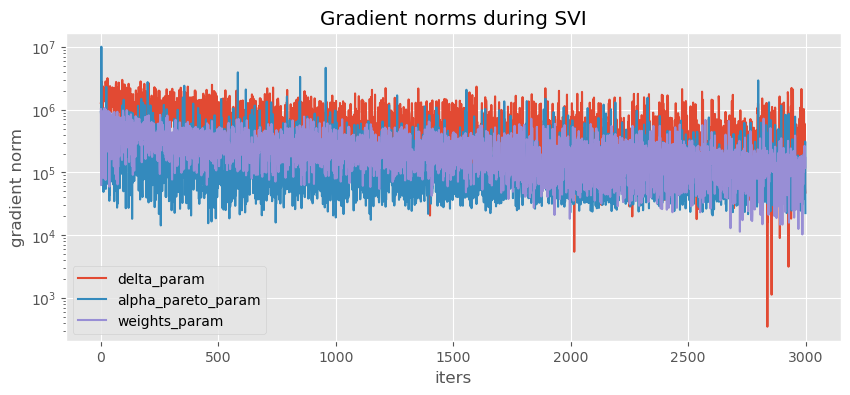

bic:  tensor(65110.6758, grad_fn=<RsubBackward1>)


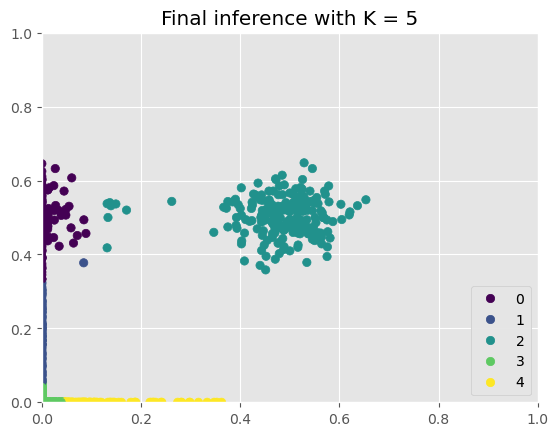

RUN WITH K = 5 AND SEED = 42
NV = 0 before: tensor(965)
NV = 0 after: tensor(965)
delta_param tensor([[[0.4042, 0.5958],
         [0.4046, 0.5954]],

        [[0.6043, 0.3957],
         [0.3957, 0.6043]],

        [[0.4040, 0.5960],
         [0.3959, 0.6041]],

        [[0.4043, 0.5957],
         [0.4042, 0.5958]],

        [[0.4047, 0.5953],
         [0.6042, 0.3958]]], grad_fn=<DivBackward0>)
Iteration 0: Loss = 9547698.230294228
Iteration 200: Loss = 8044141.451737404
Iteration 400: Loss = 8200626.592972755
Iteration 600: Loss = 8386107.795365334
Iteration 800: Loss = 8181075.00483799
Iteration 1000: Loss = 10226915.952103615
Iteration 1200: Loss = 7611071.402787209
Iteration 1400: Loss = 7512190.507767677
Iteration 1600: Loss = 8614024.865189552
Iteration 1800: Loss = 7711670.040482521
Iteration 2000: Loss = 8751983.402298927
Iteration 2200: Loss = 7874595.66108799
Iteration 2400: Loss = 7529863.209427834
Iteration 2600: Loss = 7816502.931107521
Iteration 2800: Loss = 7566031.65522

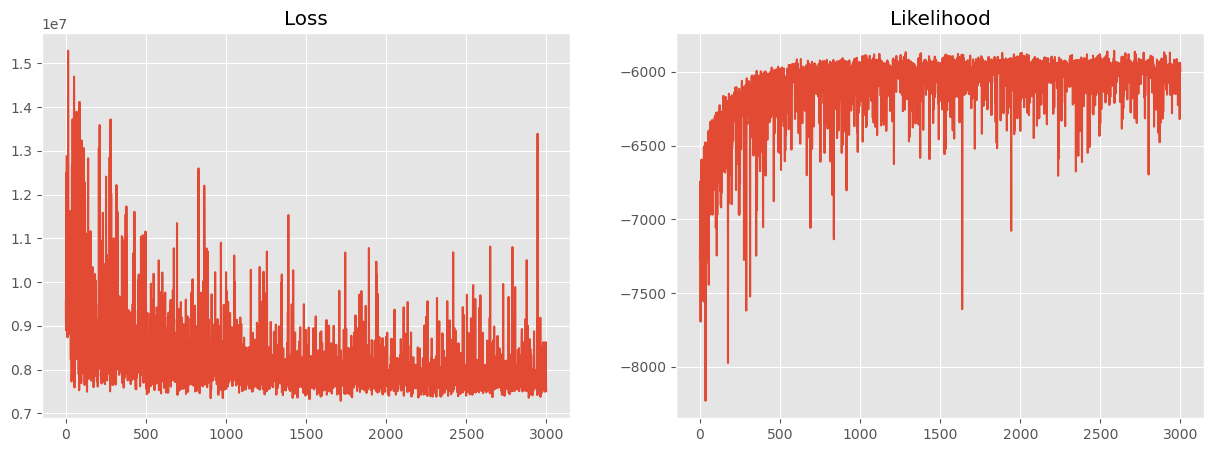

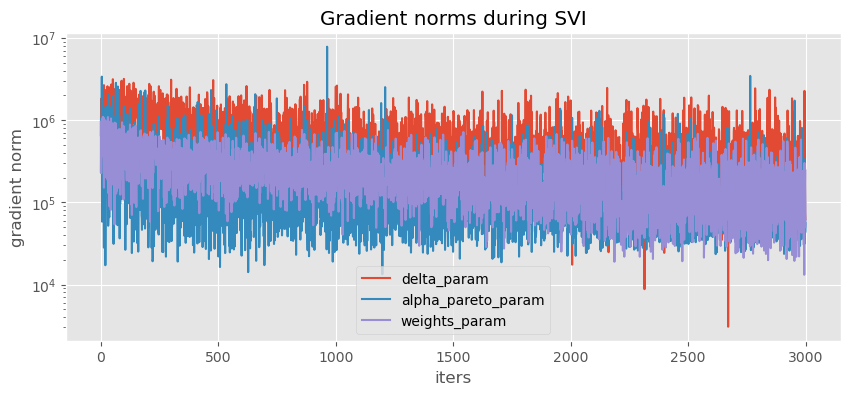

bic:  tensor(67924.7109, grad_fn=<RsubBackward1>)


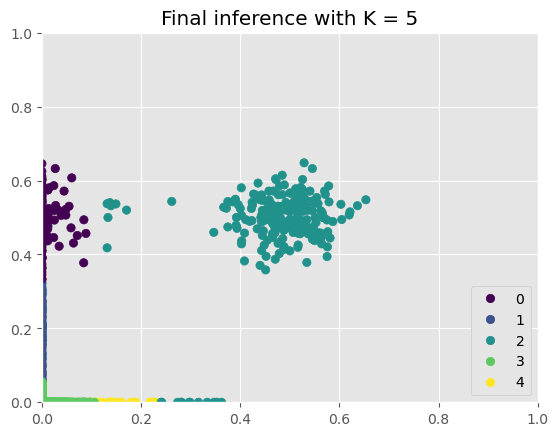

Selected number of clusters is 5 with seed 40


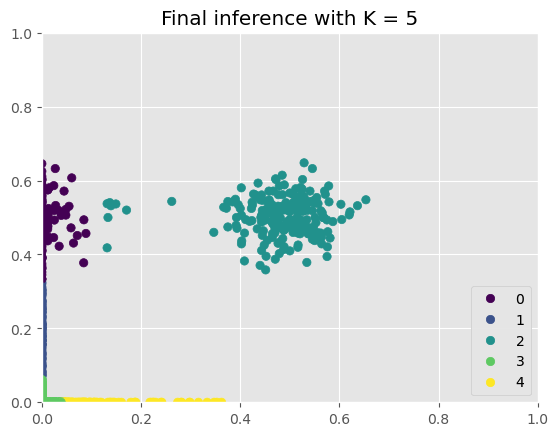

In [9]:
final_mb, mb_list = model_mobster_mv.fit(NV, DP, num_iter = 3000, K = [5], seed = [40,41,42], lr = 0.005)

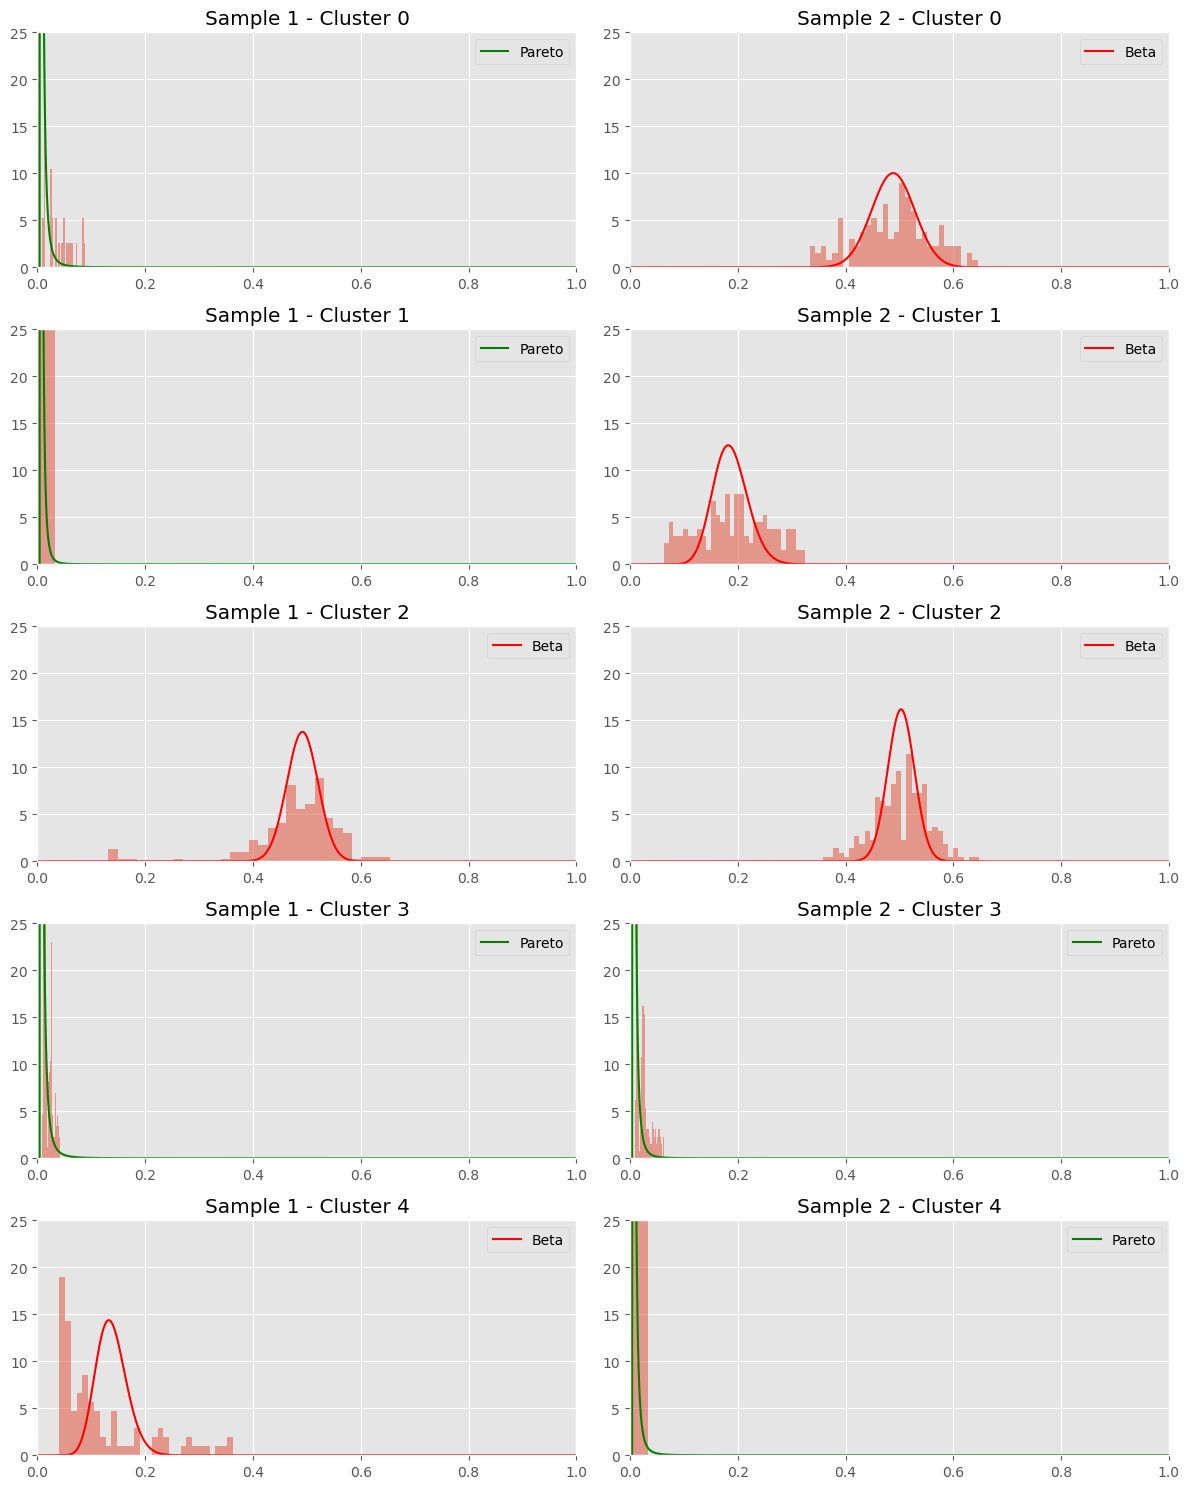

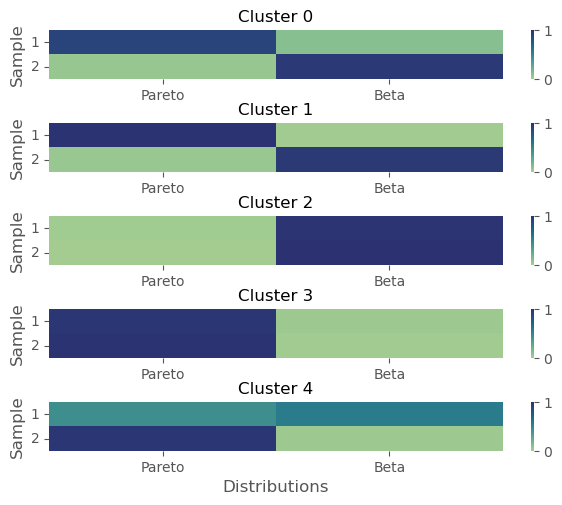

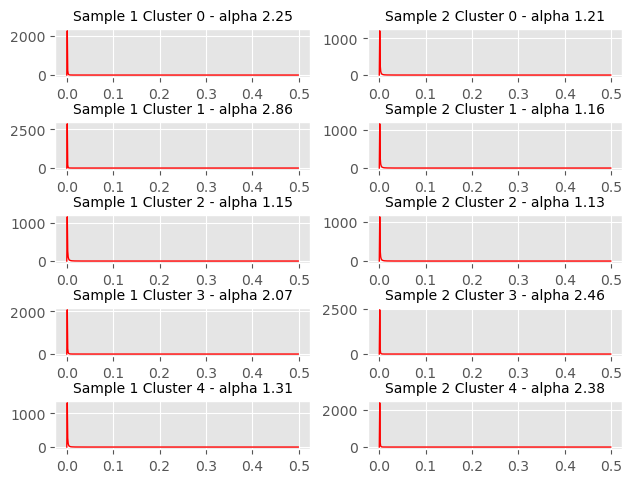

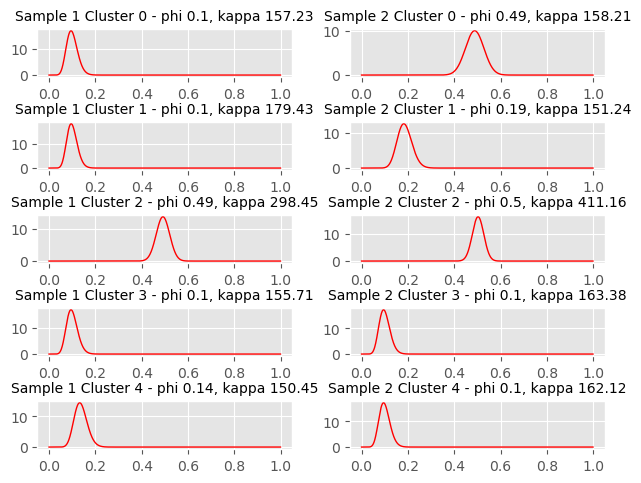

In [10]:
plot_marginals(final_mb)
plot_deltas(final_mb)
plot_paretos(final_mb)
plot_betas(final_mb)

In [11]:
final_mb.params

{'weights_param': tensor([0.1144, 0.1352, 0.1816, 0.4390, 0.1298], dtype=torch.float64,
        grad_fn=<DivBackward0>),
 'alpha_pareto_param': tensor([[2.2464, 1.2096],
         [2.8588, 1.1572],
         [1.1535, 1.1251],
         [2.0691, 2.4609],
         [1.3089, 2.3770]], grad_fn=<AddBackward0>),
 'phi_beta_param': tensor([[0.1000, 0.4884],
         [0.1000, 0.1865],
         [0.4916, 0.5029],
         [0.1000, 0.1000],
         [0.1372, 0.1000]], grad_fn=<AddBackward0>),
 'k_beta_param': tensor([[157.2252, 158.2113],
         [179.4272, 151.2379],
         [298.4548, 411.1562],
         [155.7134, 163.3846],
         [150.4542, 162.1190]], grad_fn=<AddBackward0>),
 'delta_param': tensor([[[0.8958, 0.1042],
          [0.0470, 0.9530]],
 
         [[0.9878, 0.0122],
          [0.0456, 0.9544]],
 
         [[0.0174, 0.9826],
          [0.0073, 0.9927]],
 
         [[0.9701, 0.0299],
          [0.9855, 0.0145]],
 
         [[0.4389, 0.5611],
          [0.9705, 0.0295]]], grad_fn=<Di